In [20]:
import numpy as np
import glob, os, json
import pickle

import matplotlib.pyplot as plt
import corner
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import multiprocessing as mp

import os, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import healpy as hp
import time
import scipy

from corner import corner

from astropy.time import Time
from matplotlib.colors import LogNorm
from matplotlib.colors import Normalize


from enterprise.pulsar import Pulsar

from la_forge.core import Core
from la_forge.diagnostics import plot_chains

nano12_pkl = '/home/nima/nanograv/12p5yr_bwm/channelized_12yr_v3_partim_py3.pkl'
with open(nano12_pkl, 'rb') as f:
    allpsrs=pickle.load(f)

In [21]:
chartdir=chartdir= '/home/nima/nanograv/12p5yr_bwm/ULvSky_charts/'
charts=os.listdir(chartdir)
print(len(charts))
print("expected {} charts".format(768*8))

print(charts)

4902
expected 6144 charts
['117_3.txt', '571_4.txt', '421_0.txt', '250_2.txt', '507_6.txt', '531_6.txt', '420_7.txt', '401_3.txt', '396_4.txt', '556_6.txt', '252_5.txt', '31_3.txt', '153_3.txt', '240_5.txt', '111_0.txt', '288_4.txt', '161_0.txt', '565_3.txt', '455_5.txt', '277_6.txt', '234_2.txt', '82_6.txt', '472_6.txt', '151_1.txt', '11_6.txt', '467_4.txt', '86_6.txt', '411_7.txt', '300_6.txt', '559_2.txt', '321_7.txt', '362_6.txt', '55_5.txt', '380_5.txt', '490_4.txt', '462_6.txt', '577_4.txt', '170_0.txt', '482_1.txt', '551_0.txt', '299_6.txt', '584_2.txt', '11_4.txt', '441_6.txt', '36_2.txt', '215_3.txt', '16_7.txt', '115_5.txt', '110_5.txt', '251_0.txt', '515_6.txt', '516_7.txt', '552_5.txt', '247_0.txt', '493_2.txt', '364_1.txt', '71_4.txt', '9_1.txt', '236_3.txt', '364_2.txt', '16_6.txt', '123_6.txt', '123_3.txt', '579_4.txt', '282_7.txt', '95_6.txt', '476_7.txt', '98_1.txt', '164_1.txt', '587_0.txt', '435_6.txt', '248_6.txt', '242_3.txt', '565_1.txt', '371_4.txt', '245_0.txt',

In [8]:
skypixs = np.arange(hp.nside2npix(8))
npix = hp.nside2npix(8)
bwm_pols = np.arange(0, np.pi, np.pi/8)
amps = np.linspace(-17,-11,45, endpoint=True)
nano12_Ts = np.linspace(53216.13175403865+180, 57933.45642396011-180, 157)

# Let's write a function to marginalize over polarizations

In [16]:
pol_marged_outdir = '/home/nima/nanograv/12p5yr_bwm/ULvSky_charts_crnmarg_polmarged/'
os.makedirs(pol_marged_outdir, exist_ok=True)
for skypix in range(npix):
    charts = []
    combined_chart = np.zeros((len(amps),len(nano12_Ts)))
    for pol_idx, pol in enumerate(bwm_pols):
        charts.append(np.loadtxt(chartdir + '{}_{}.txt'.format(skypix, pol_idx)))
    
    for col_idx, t0 in enumerate(nano12_Ts):
        reduction_factor = max([np.amax(chart[:,col_idx]) for chart in charts])
        for chart in charts:
            for row_idx, amp in enumerate(amps):
                combined_chart[row_idx, col_idx]+= np.exp(chart[row_idx,col_idx] - reduction_factor)
        for row_idx, amp in enumerate(amps):
            combined_chart[row_idx, col_idx] = np.log(combined_chart[row_idx, col_idx]) + reduction_factor

    np.savetxt(pol_marged_outdir + '{}.txt'.format(skypix), combined_chart)
    

/tmp/ipykernel_26735/189956808.py:15: RuntimeWarning: divide by zero encountered in log
  combined_chart[row_idx, col_idx] = np.log(combined_chart[row_idx, col_idx]) + reduction_factor


In [18]:
import random
def sample_hist(weights, centers, num_points=int(1e5), sample_bounds=None, verbose=False):
    #make sure the weights are properly normalized
    #print(weights)
    #print(centers)
    norm = np.sum(weights)
    normed_weights = weights/norm
    #print(normed_weights)
    
    #go through weights and see if there are lower and upper bounds. This will speed up resampling
    
            
            
    #print("lower, upper bounds are: {} and {}\nthe likelihoods between are {}:".format(lower, upper, normed_weights[lower:upper]))    
    
    
    accepted = 0
    
    resampled_chain = []    
    likelihood_interp = scipy.interpolate.interp1d(centers, normed_weights)
    if sample_bounds is None:
        while accepted < num_points:
            amp = random.uniform(centers[0], centers[-1])
            #print("trying amplitude: {}".format(amp))

            likelihood = likelihood_interp(amp)
            #print(likelihood)
            #print("likelihood of amp = {}".format(likelihood))
            if random.random() < likelihood:
                accepted+=1
                if accepted/num_points % 0.02 == 0 and verbose:
                    print("completed {}%".format(accepted/num_points * 100))
                resampled_chain.append(amp)
    else:
        while accepted < num_points:
            amp = random.uniform(sample_bounds[0], sample_bounds[1])
            #print("trying amplitude: {}".format(amp))

            likelihood = likelihood_interp(amp)
            #print(likelihood)
            #print("likelihood of amp = {}".format(likelihood))
            if random.random() < likelihood:
                accepted+=1
                if accepted/num_points % 0.02 == 0 and verbose:
                    print("completed {}%".format(accepted/num_points * 100))
                resampled_chain.append(amp)

        
    #print(sorted(resampled_chain))
    return sorted(resampled_chain)

In [6]:
# Let's make a worker function that does this for a particular epoch and multiprocessify this

def epoch_sample_worker(skypix):
    this_skypix_samples = [] #this should be a list of amplitudes
    outf = '/home/nima/nanograv/12p5yr_bwm/ULvSky_samples/{}'
    chartdir = '/home/nima/nanograv/12p5yr_bwm/ULvSky_charts_crnmarg_polmarged/'.format(skypix)
    for skypix in range(npix):
        chart = np.loadtxt(chartdir + '{}.txt'.format(skypix))
        epoch_max = np.amax(chart[:, epoch_idx])
        # we want to get the weights/centers for the amplitudes
        logweights = np.zeros(len(amps))
        for amp_idx in range(len(logweights)):
            like = np.exp(chart[amp_idx, epoch_idx] - epoch_max) 
            logweights[amp_idx] = np.log(like) + epoch_max
            #reweight so that we have uniform priors in the bwm_amplitude
        #plt.close("all")
        #plt.xscale('log')
        #plt.plot(amps, weights)
        #plt.show()
        # Now we need to build weights from logweights
        weights=np.zeros(len(amps))

        maxlogweight = np.amax(logweights)
        for logweight_idx, logweight in enumerate(logweights):
            weights[logweight_idx] = 10**amps[logweight_idx] * np.exp(logweight - maxlogweight)
        '''
        plt.close("all")
        plt.xscale('log')
        plt.plot(amps, weights)
        plt.show()
        '''

        #now we can resample and add the elements of the chain to this epochs samples.
        sampled = sample_hist(weights, amps, num_points=1000, sample_bounds=[-17,-11])


        #now we just want to dump this into this_epoch_samples
        for el in sampled:
            this_epoch_samples.append(el)  
    
    #Now we've resampled this entire time bin for every source location
    #let's just plot some for now
    plt.close("all")
    plt.hist(this_epoch_samples,histtype='step',bins=30 )
    plt.title("Histogram for epoch {}".format(epoch_idx))
    plt.show()
    
    np.savetxt(outf, this_epoch_samples)
    

/tmp/ipykernel_21071/992575803.py:16: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max
/tmp/ipykernel_21071/992575803.py:16: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max
/tmp/ipykernel_21071/992575803.py:16: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max
/tmp/ipykernel_21071/992575803.py:16: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max
/tmp/ipykernel_21071/992575803.py:16: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max
/tmp/ipykernel_21071/992575803.py:16: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max
/tmp/ipykernel_21071/992575803.py:16: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max
/tmp/ipykernel_21071/992575803.py:16: Run

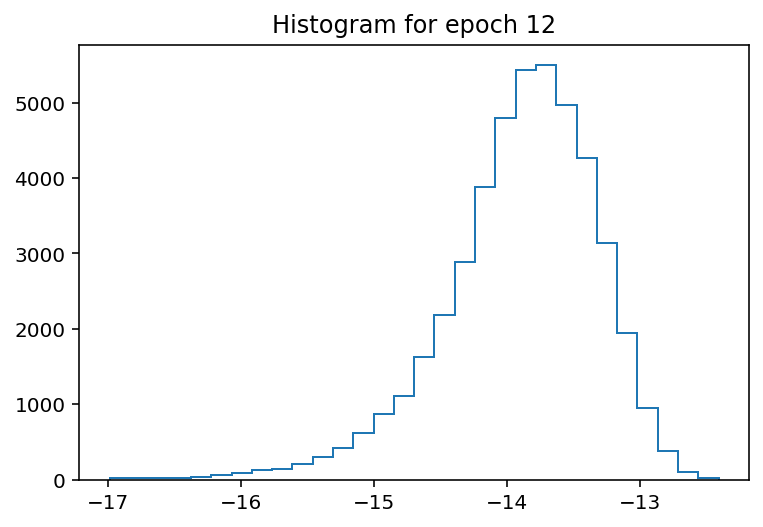

/tmp/ipykernel_21071/992575803.py:16: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


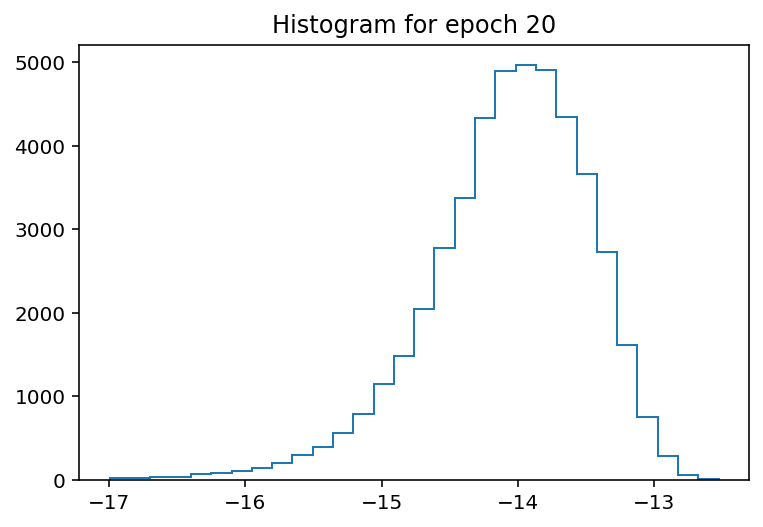

/tmp/ipykernel_21071/992575803.py:16: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


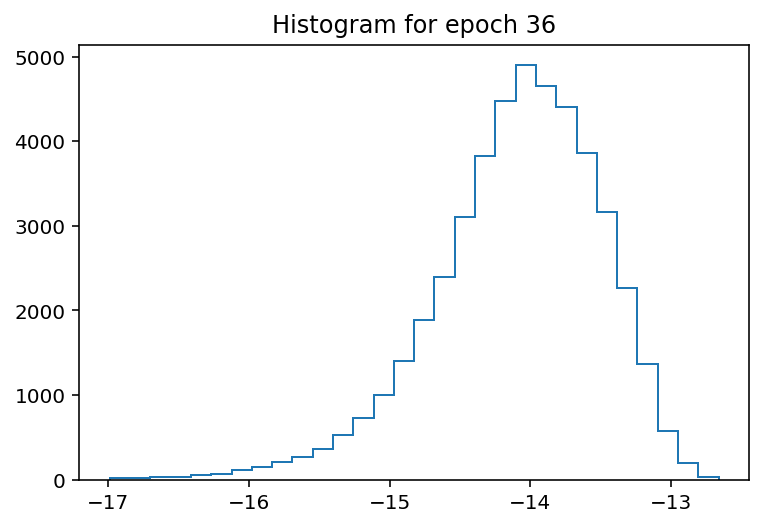

/tmp/ipykernel_21071/992575803.py:16: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


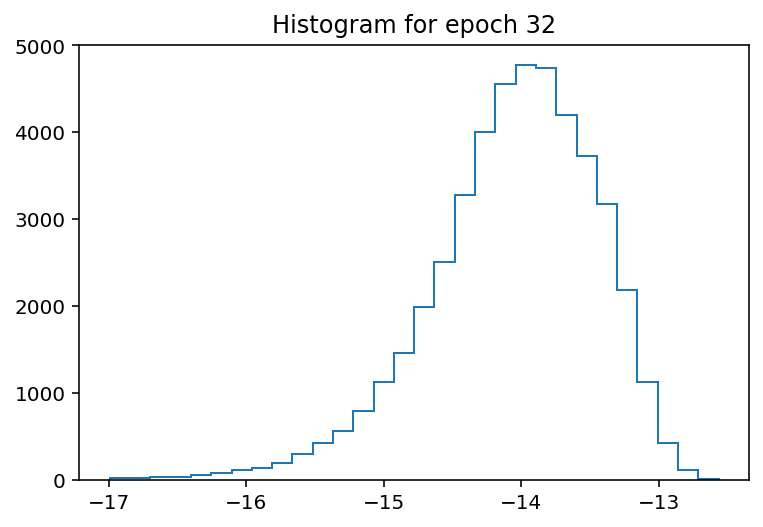

/tmp/ipykernel_21071/992575803.py:16: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


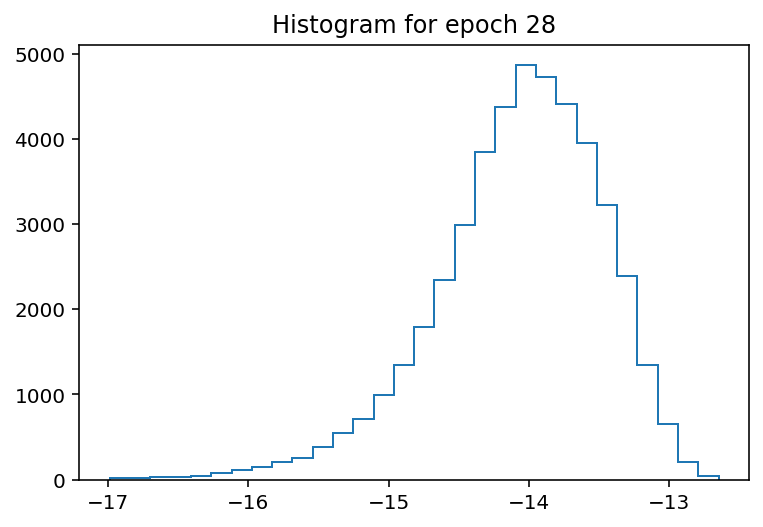

/tmp/ipykernel_21071/992575803.py:16: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


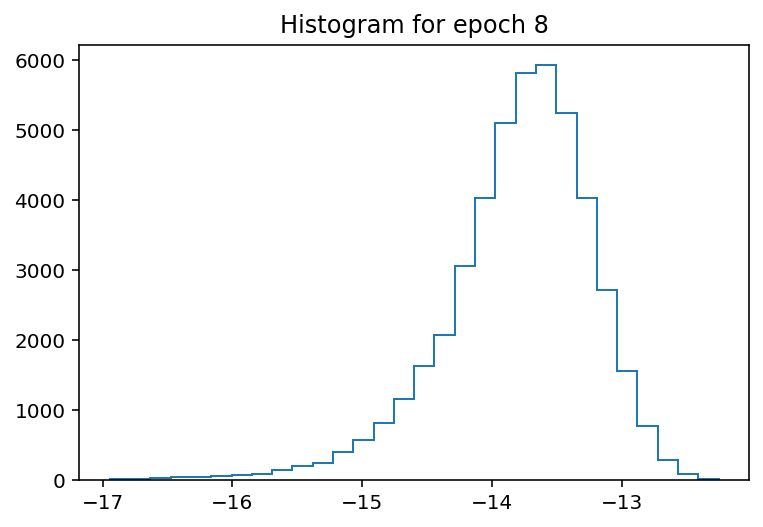

/tmp/ipykernel_21071/992575803.py:16: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


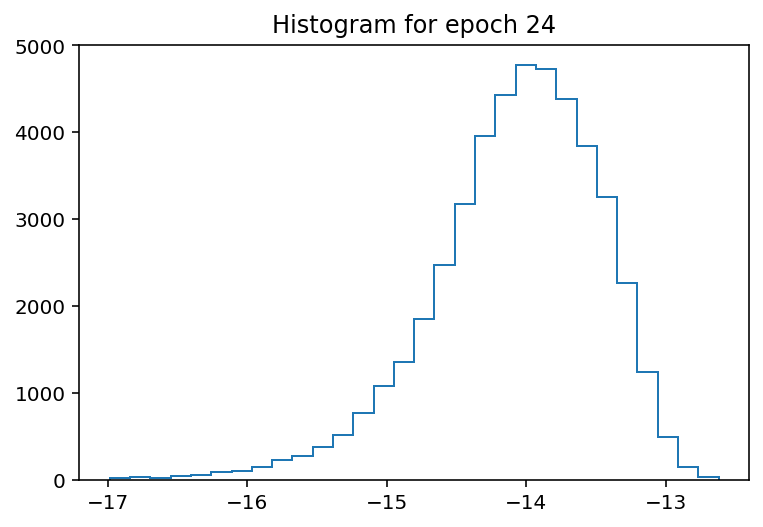

/tmp/ipykernel_21071/992575803.py:16: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


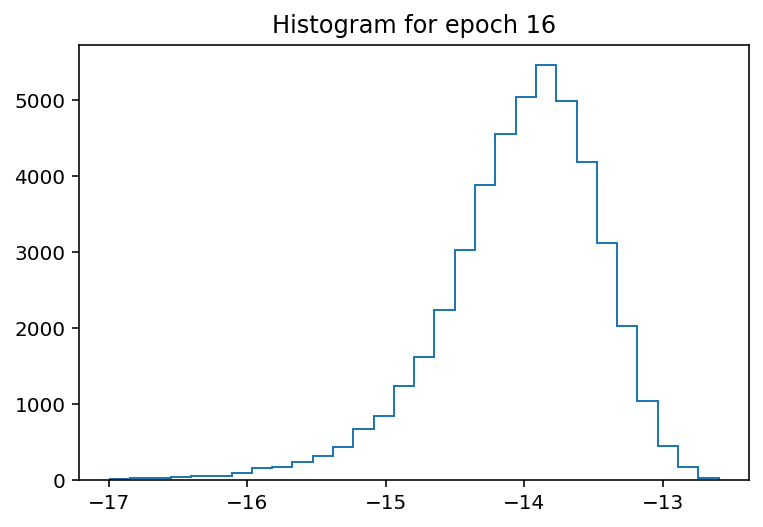

/tmp/ipykernel_21071/992575803.py:16: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


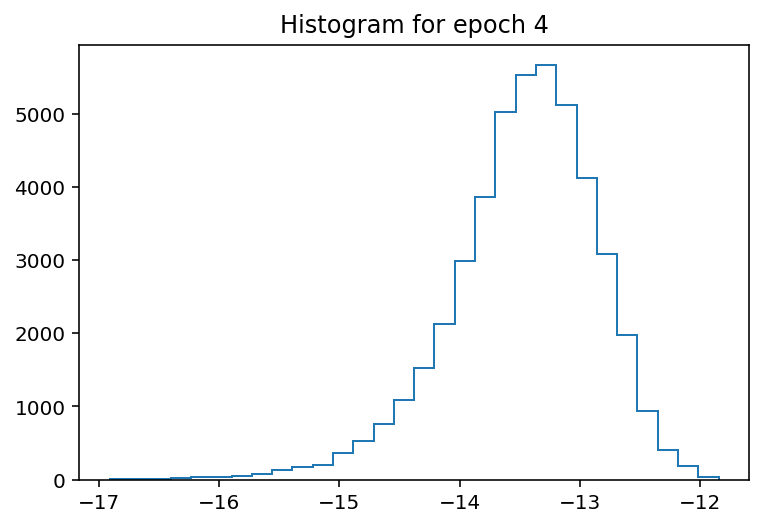

/tmp/ipykernel_21071/992575803.py:16: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


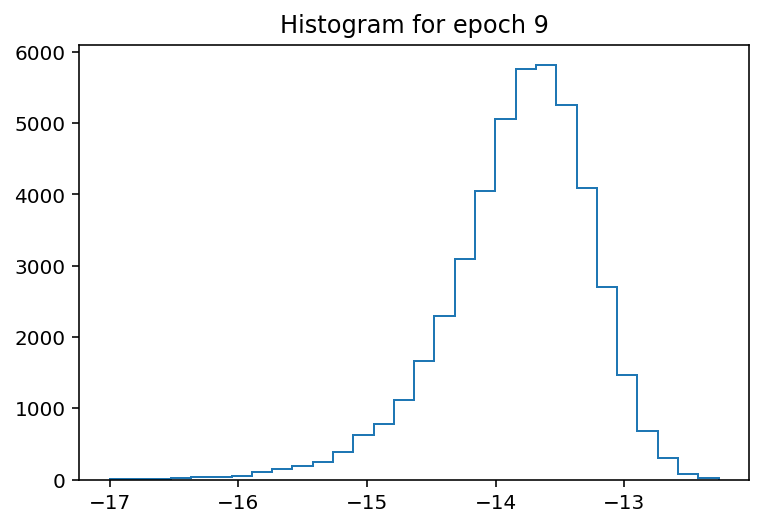

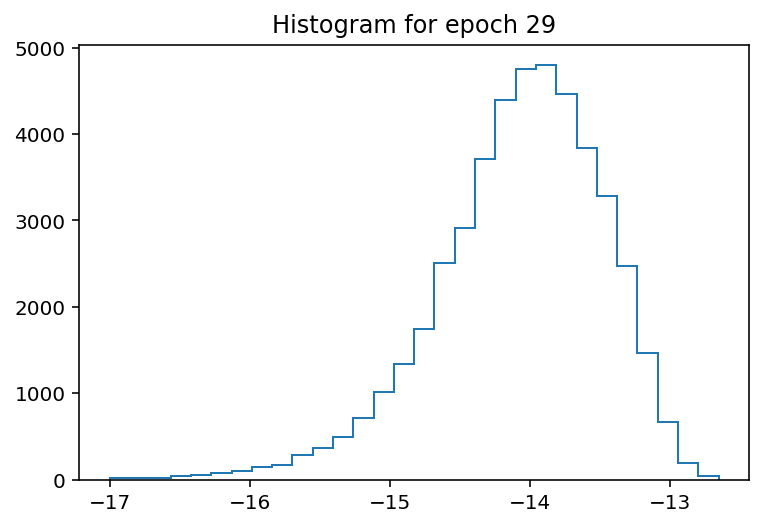

/tmp/ipykernel_21071/992575803.py:16: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max
/tmp/ipykernel_21071/992575803.py:16: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


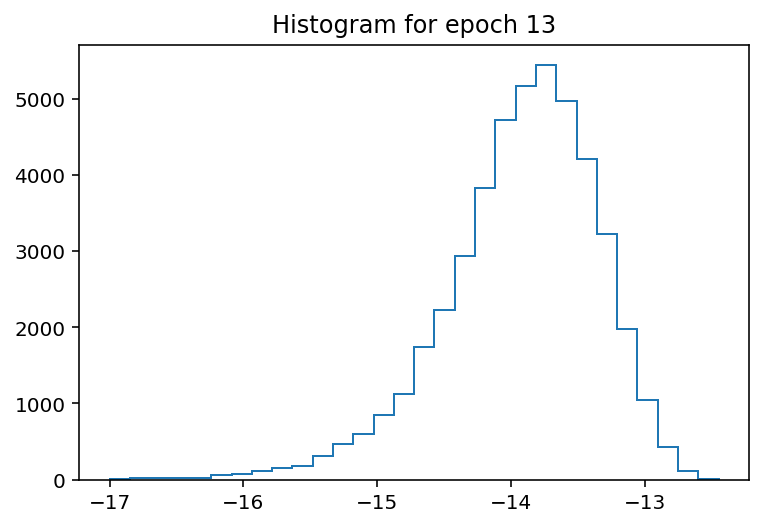

/tmp/ipykernel_21071/992575803.py:16: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


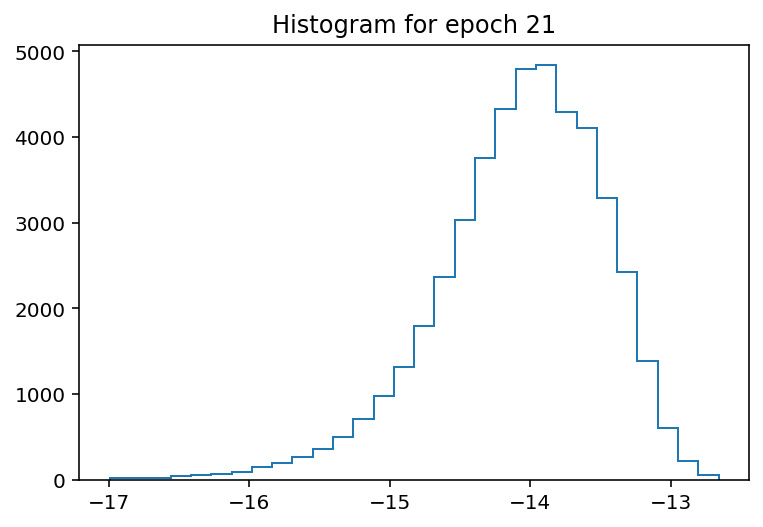

/tmp/ipykernel_21071/992575803.py:16: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


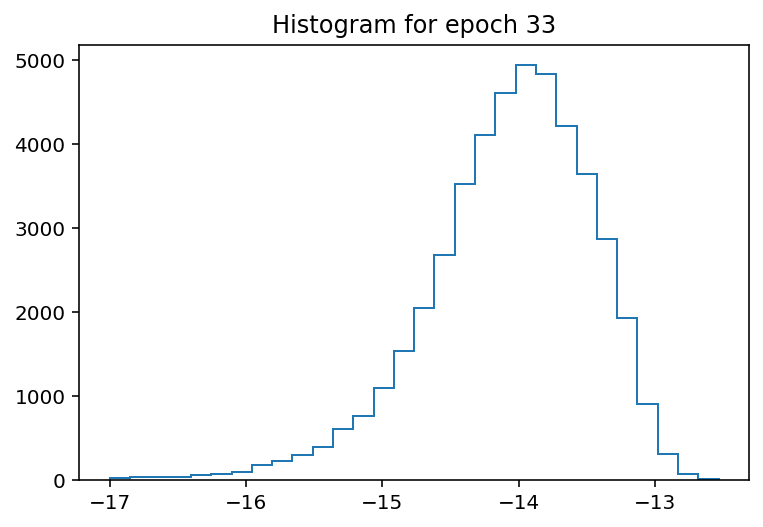

/tmp/ipykernel_21071/992575803.py:16: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max
/tmp/ipykernel_21071/992575803.py:16: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


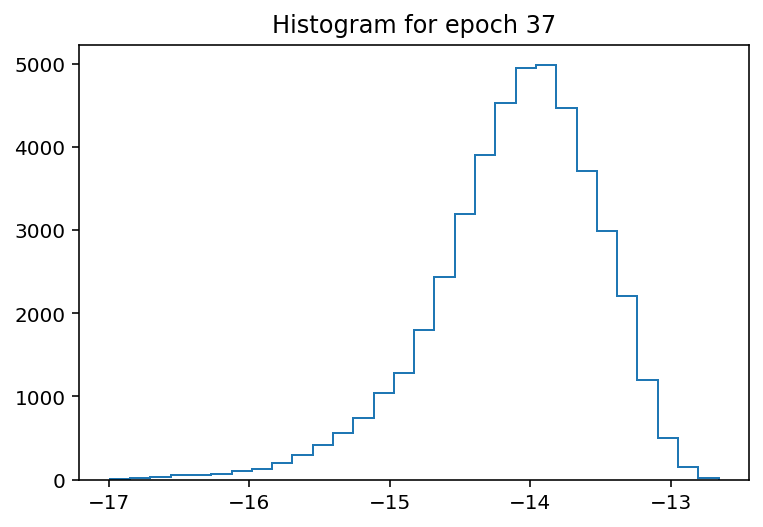

/tmp/ipykernel_21071/992575803.py:16: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


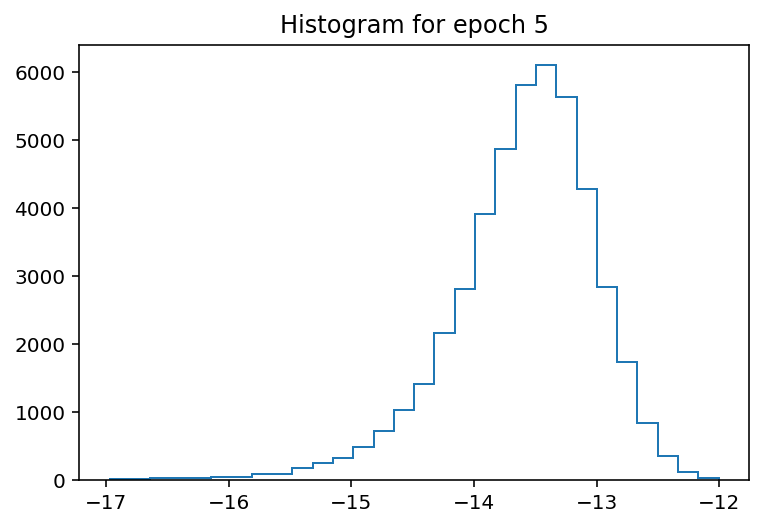

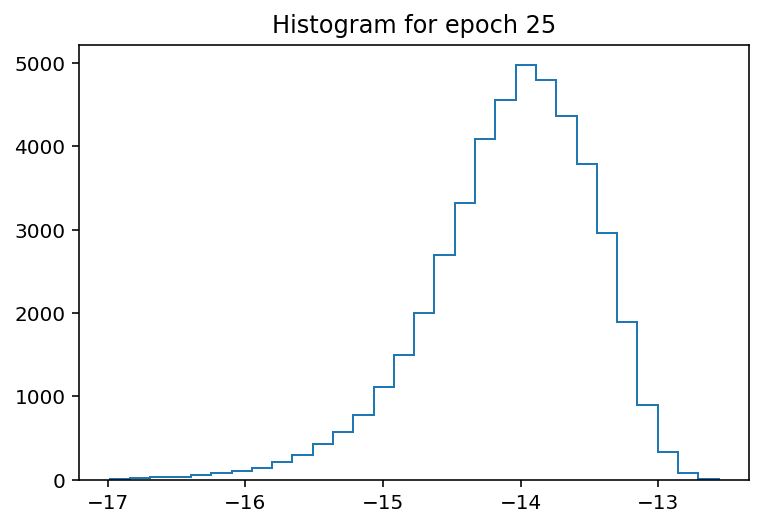

/tmp/ipykernel_21071/992575803.py:16: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max
/tmp/ipykernel_21071/992575803.py:16: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


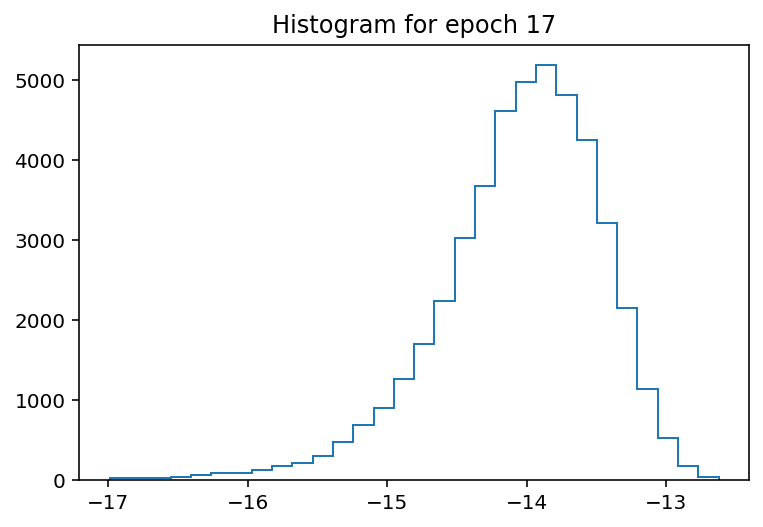

/tmp/ipykernel_21071/992575803.py:16: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


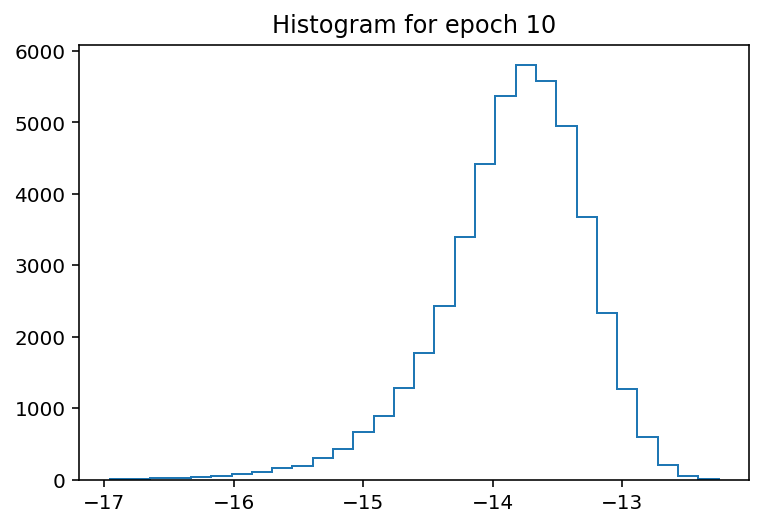

/tmp/ipykernel_21071/992575803.py:16: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


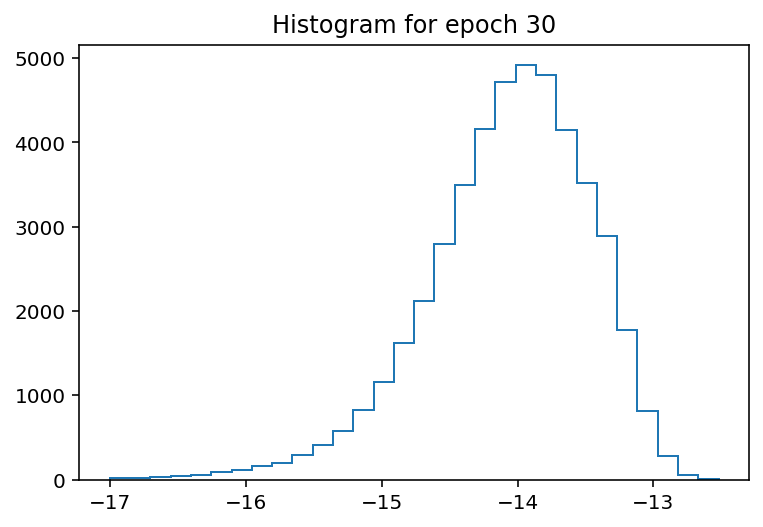

/tmp/ipykernel_21071/992575803.py:16: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


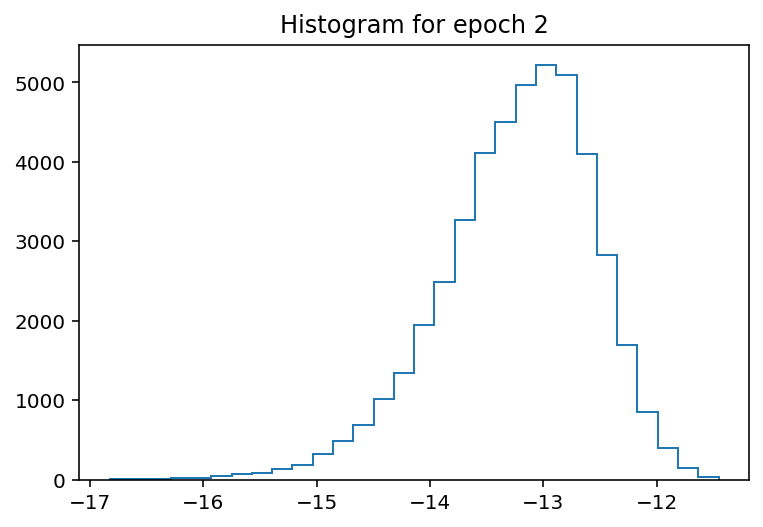

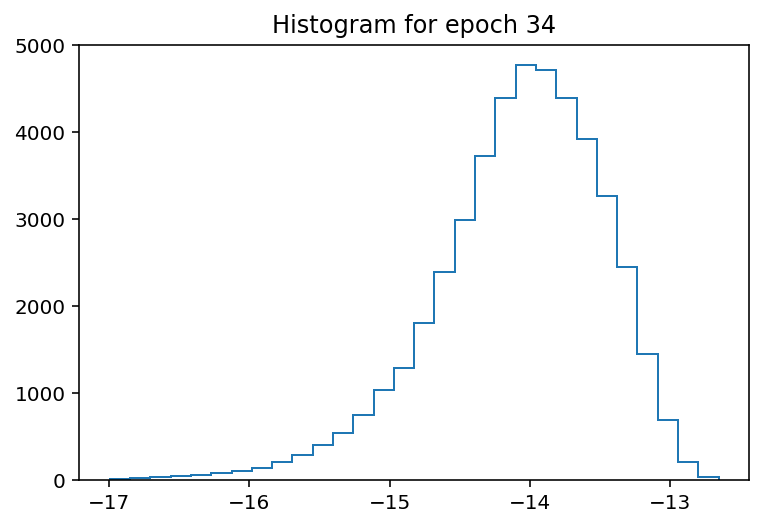

/tmp/ipykernel_21071/992575803.py:16: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max
/tmp/ipykernel_21071/992575803.py:16: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


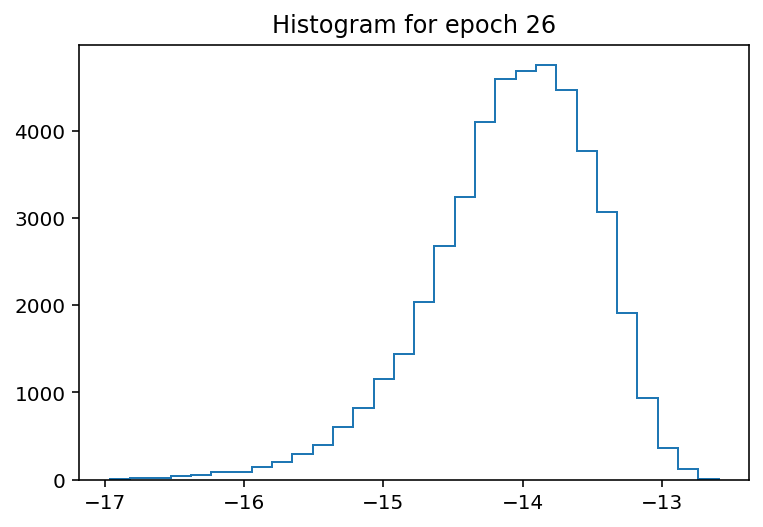

/tmp/ipykernel_21071/992575803.py:16: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


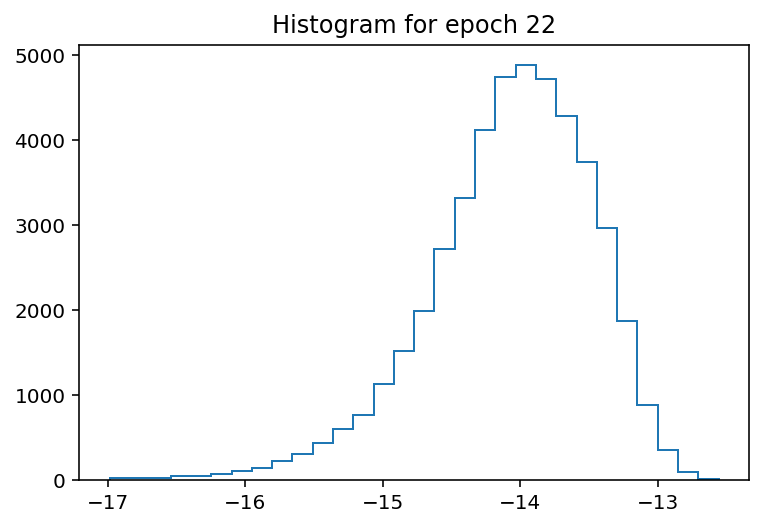

/tmp/ipykernel_21071/992575803.py:16: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


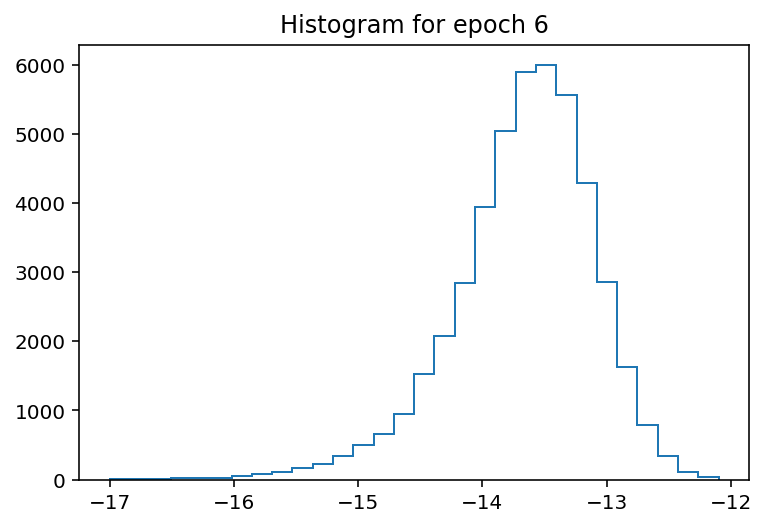

/tmp/ipykernel_21071/992575803.py:16: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


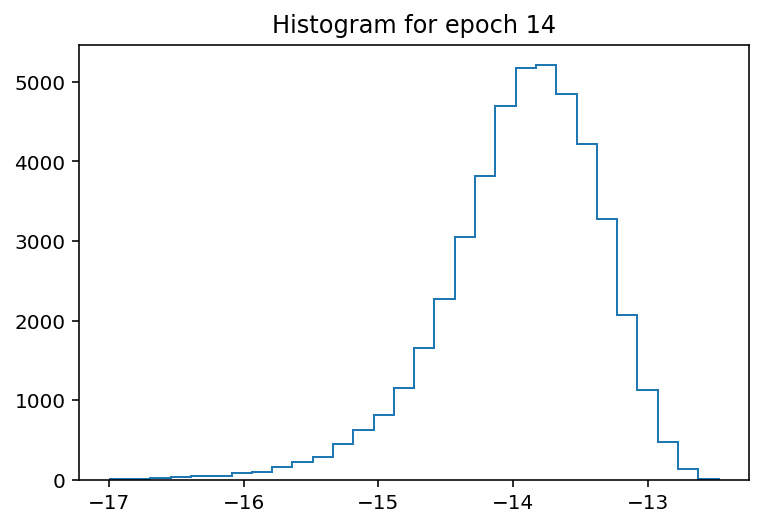

/tmp/ipykernel_21071/992575803.py:16: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


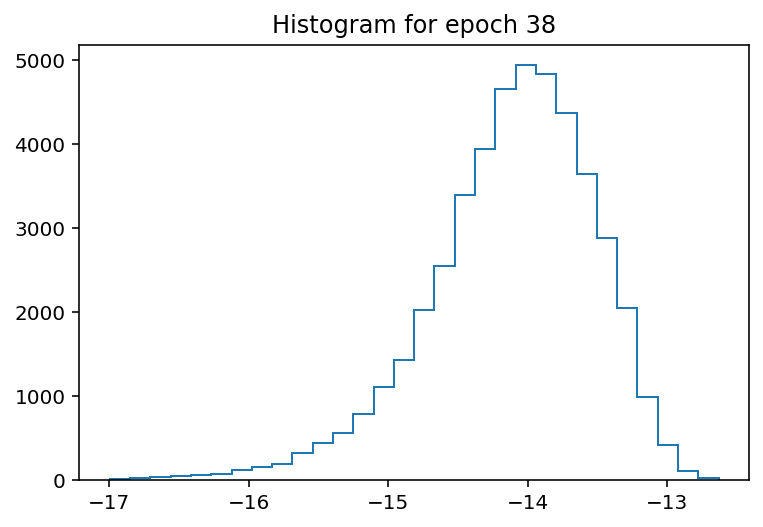

/tmp/ipykernel_21071/992575803.py:16: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


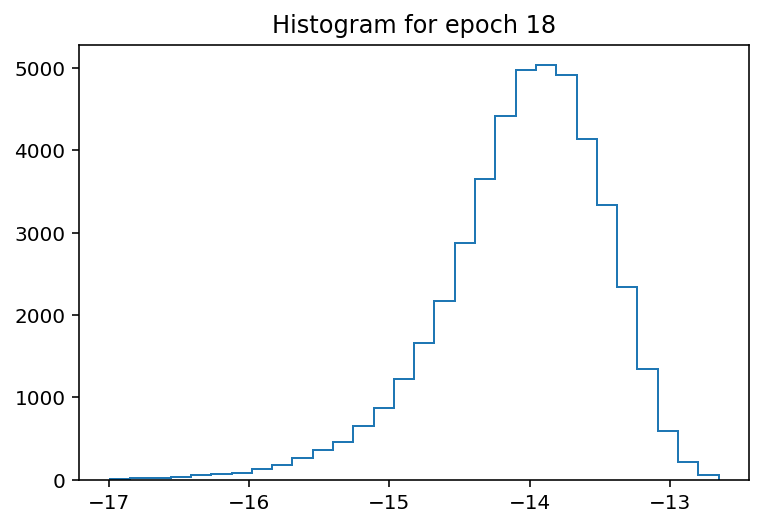

/tmp/ipykernel_21071/992575803.py:16: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


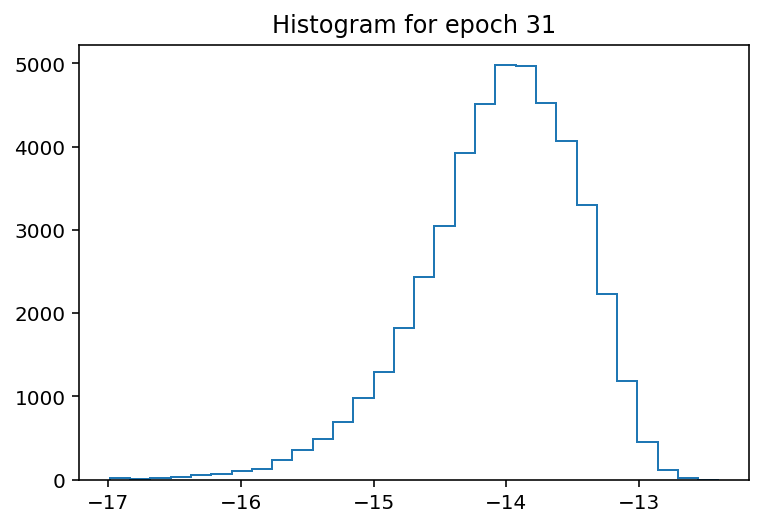

/tmp/ipykernel_21071/992575803.py:16: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


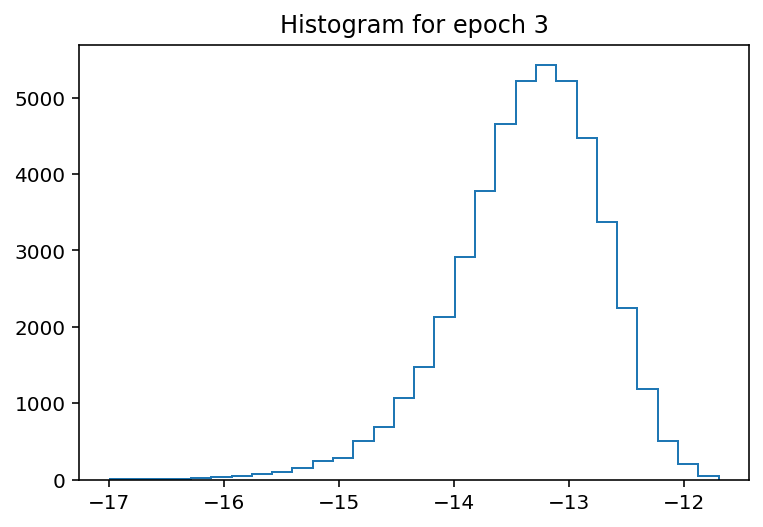

/tmp/ipykernel_21071/992575803.py:16: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


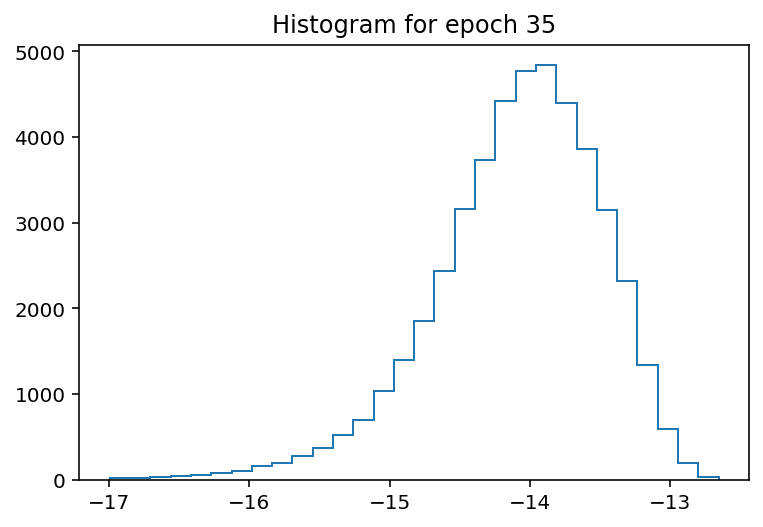

/tmp/ipykernel_21071/992575803.py:16: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


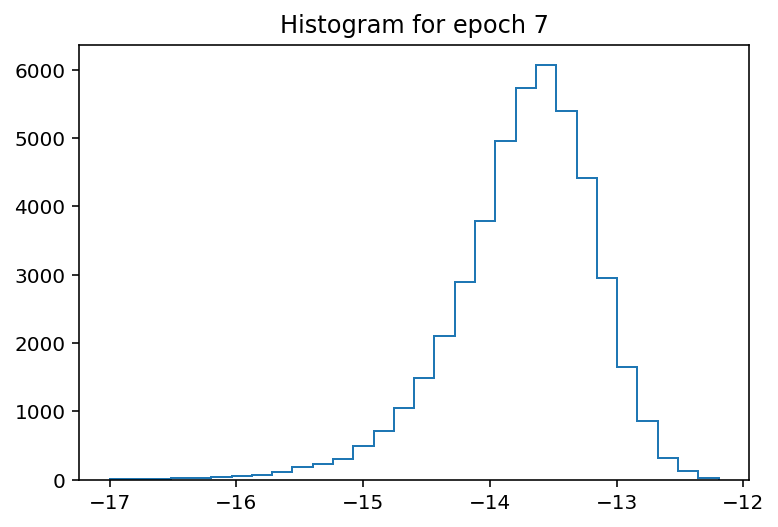

/tmp/ipykernel_21071/992575803.py:16: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


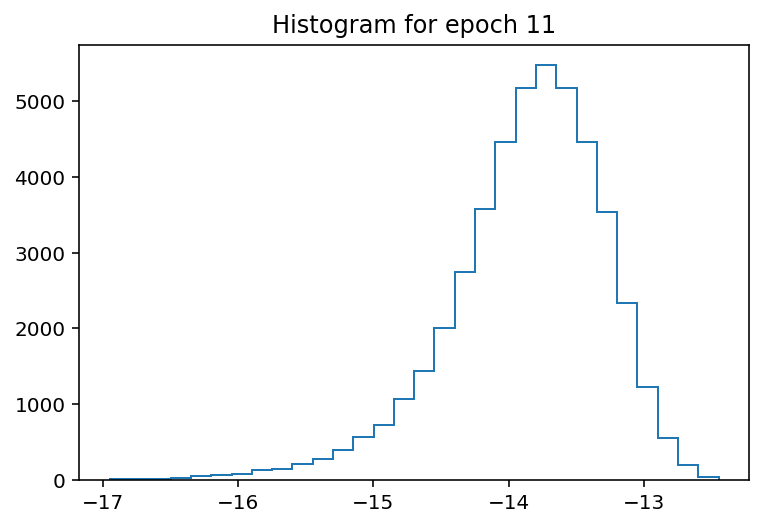

/tmp/ipykernel_21071/992575803.py:16: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


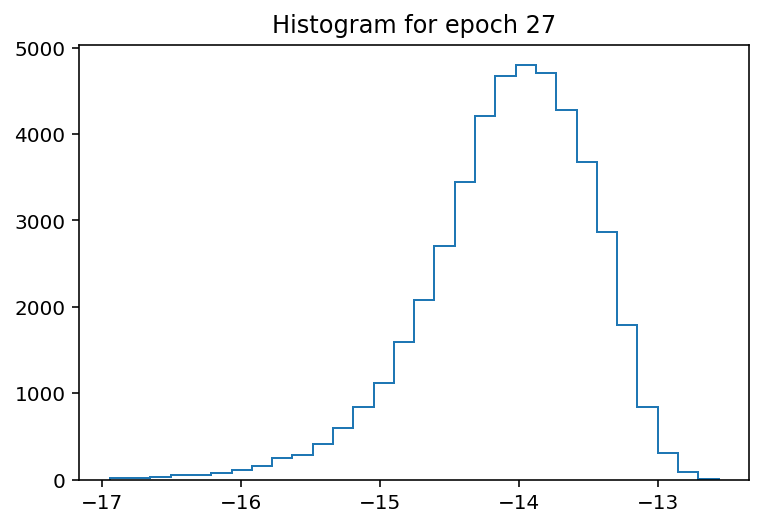

/tmp/ipykernel_21071/992575803.py:16: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


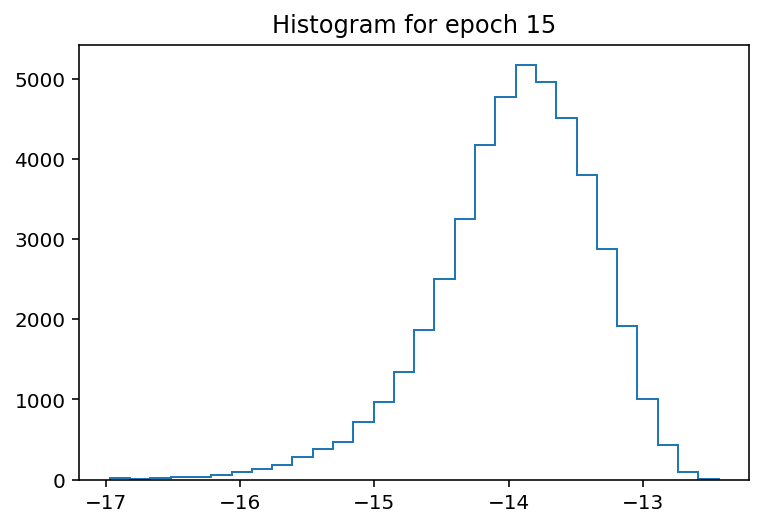

/tmp/ipykernel_21071/992575803.py:16: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


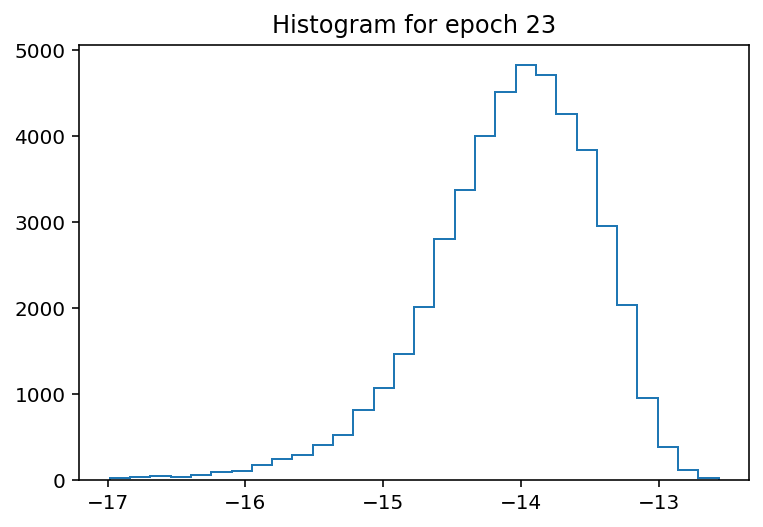

/tmp/ipykernel_21071/992575803.py:16: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


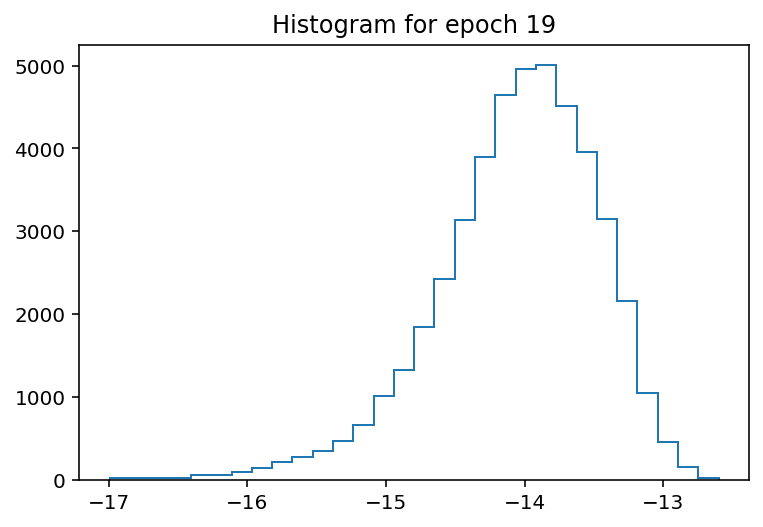

/tmp/ipykernel_21071/992575803.py:16: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


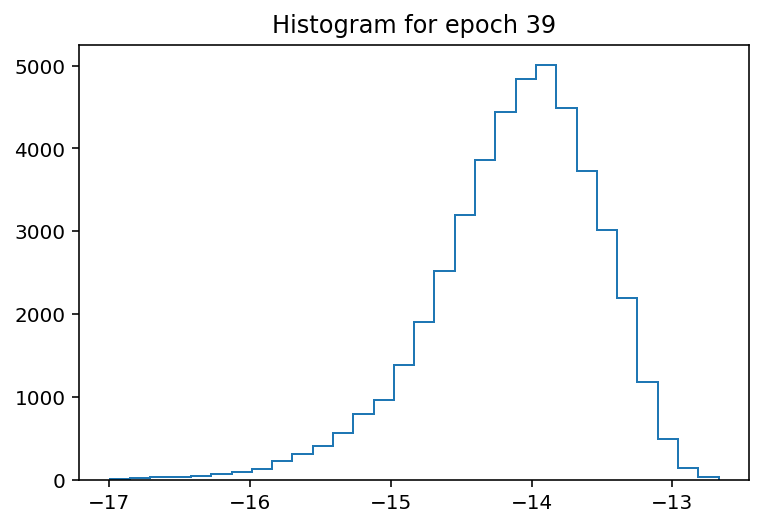

/tmp/ipykernel_21071/992575803.py:16: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


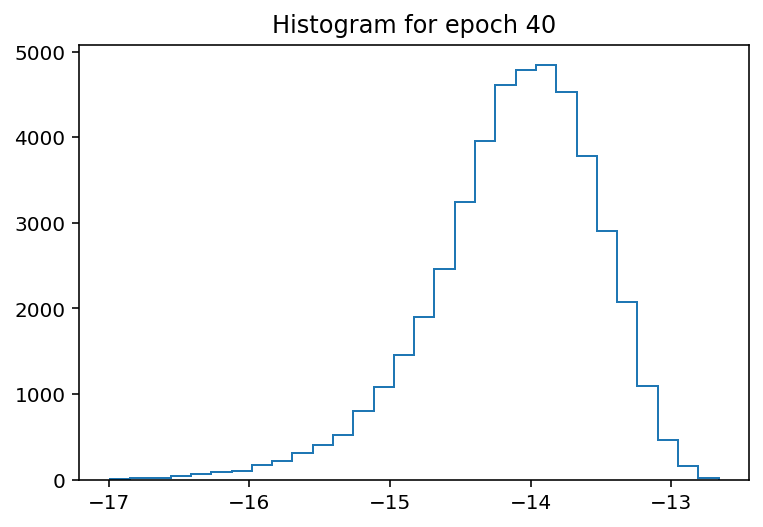

/tmp/ipykernel_21071/992575803.py:16: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


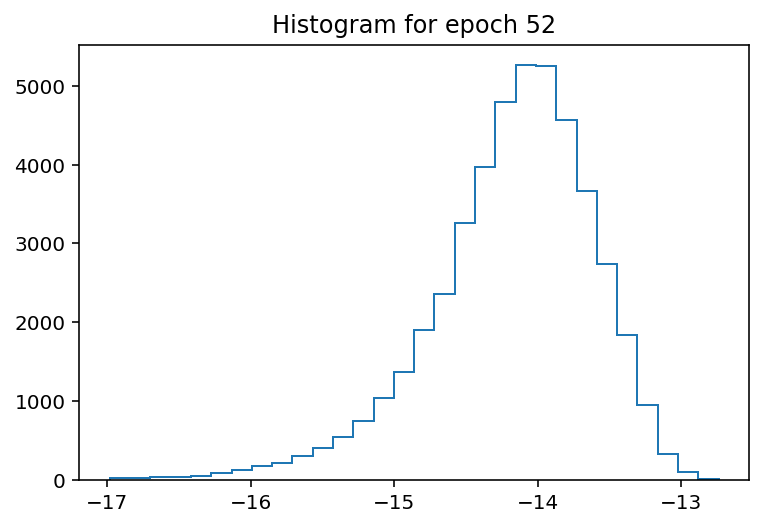

/tmp/ipykernel_21071/992575803.py:16: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


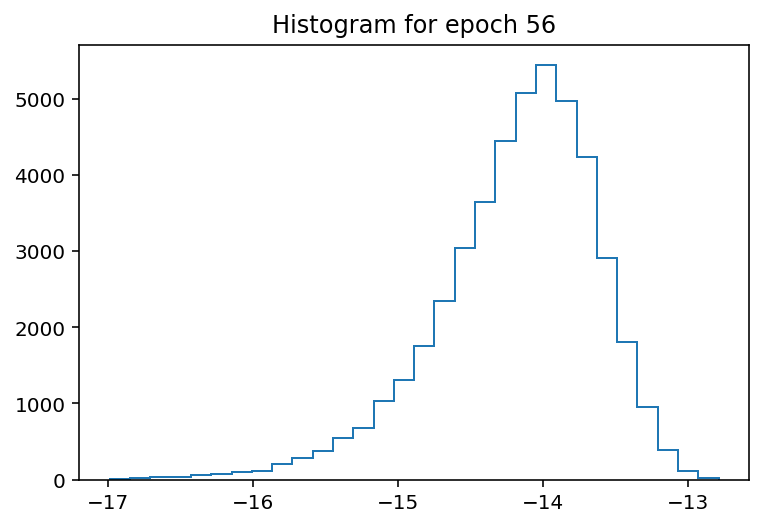

/tmp/ipykernel_21071/992575803.py:16: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


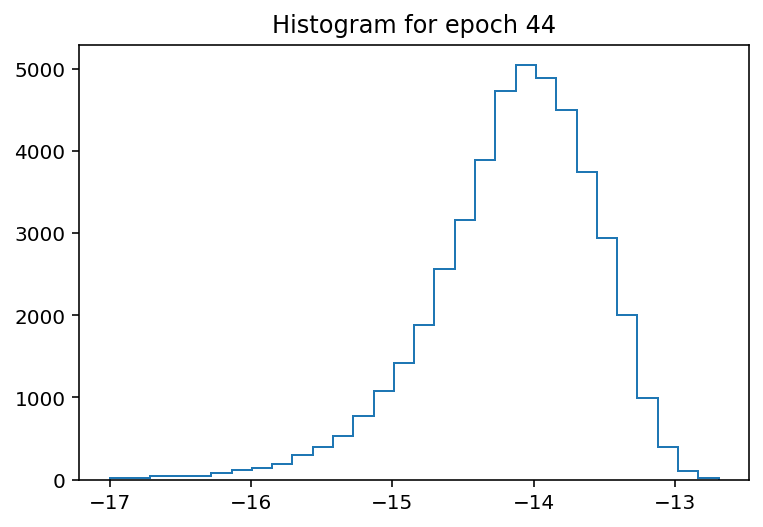

/tmp/ipykernel_21071/992575803.py:16: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


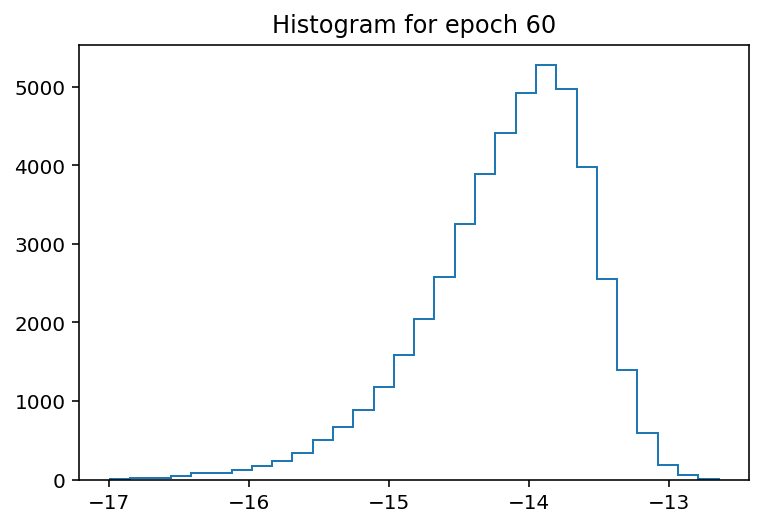

/tmp/ipykernel_21071/992575803.py:16: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


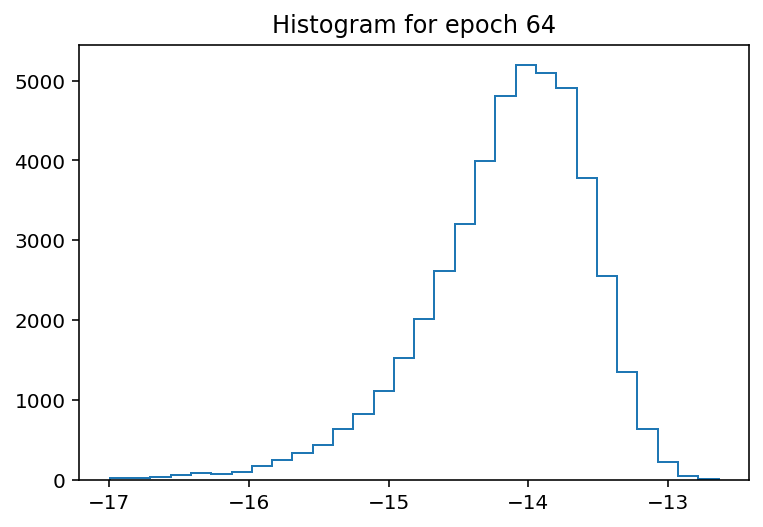

/tmp/ipykernel_21071/992575803.py:16: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


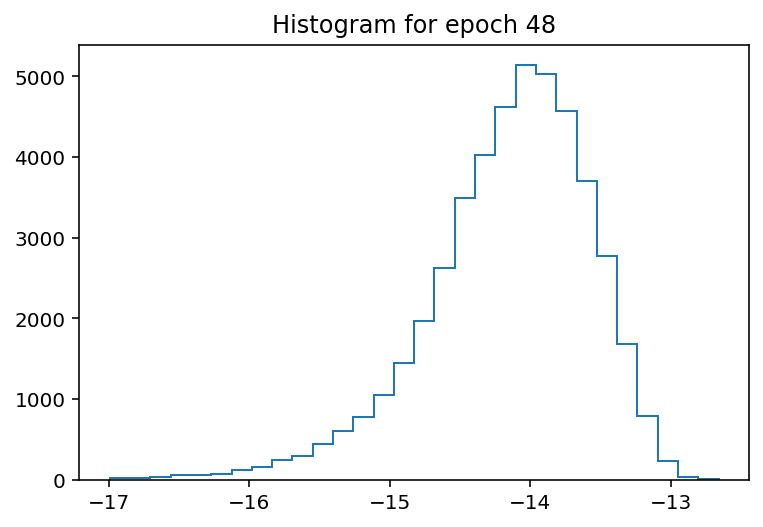

/tmp/ipykernel_21071/992575803.py:16: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


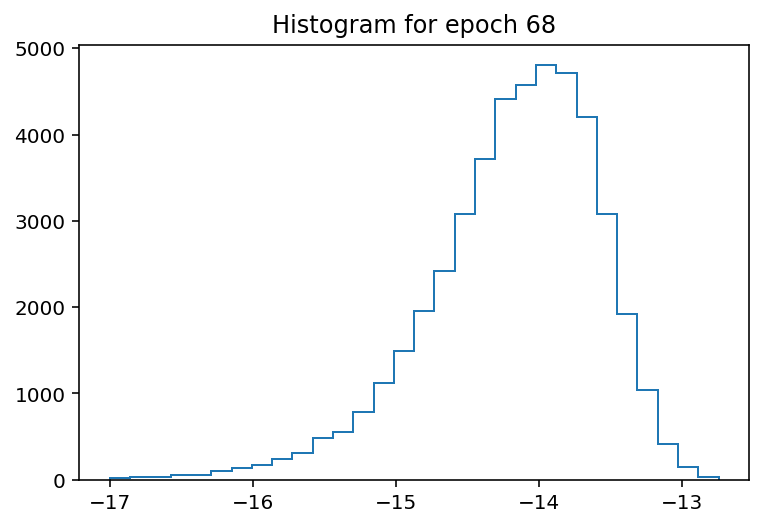

/tmp/ipykernel_21071/992575803.py:16: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


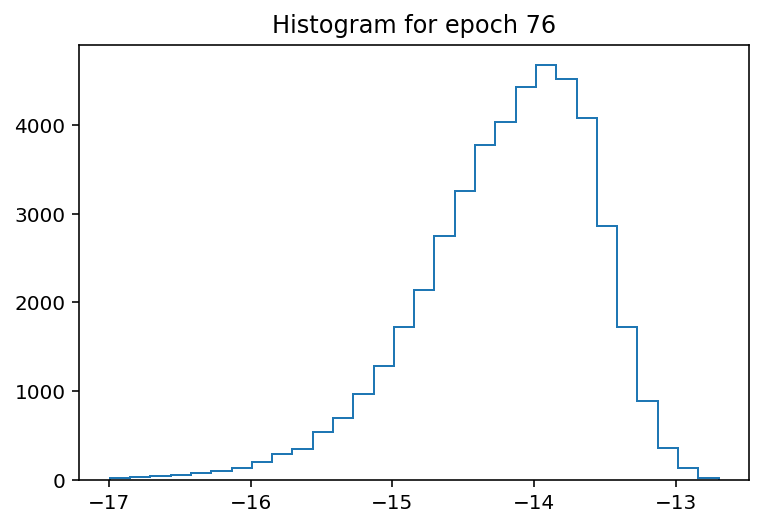

/tmp/ipykernel_21071/992575803.py:16: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


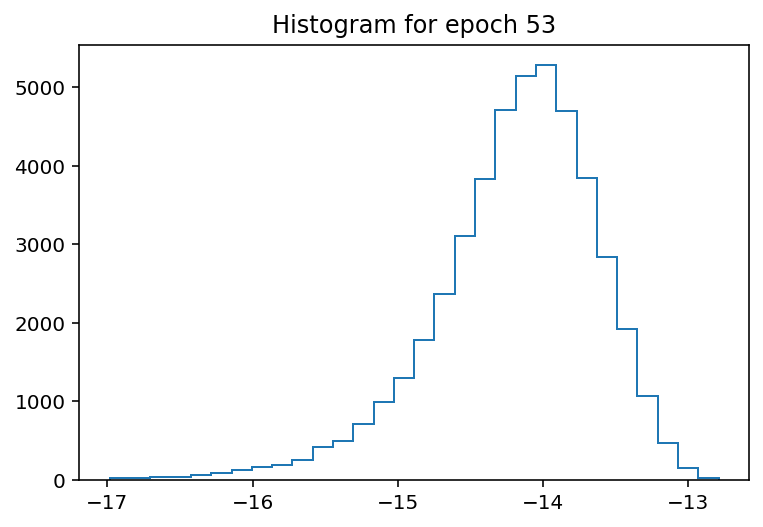

/tmp/ipykernel_21071/992575803.py:16: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


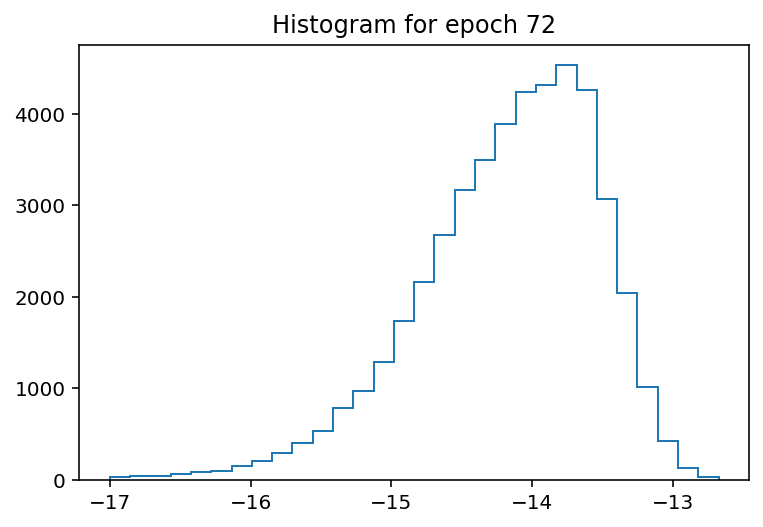

/tmp/ipykernel_21071/992575803.py:16: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


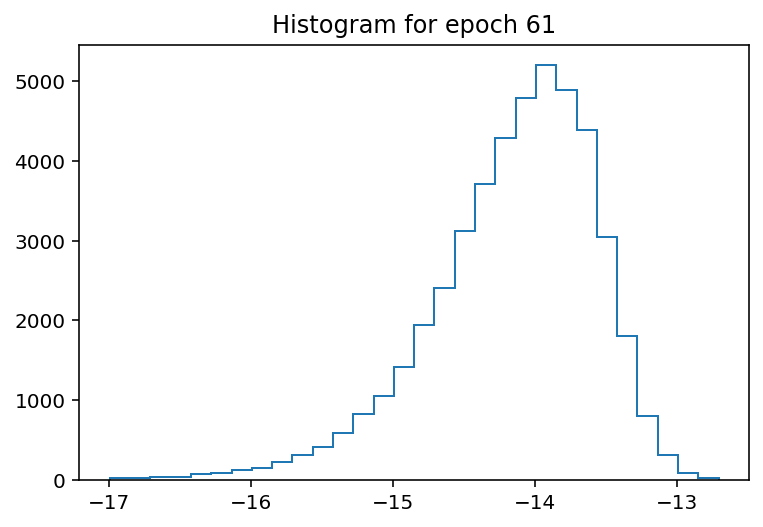

/tmp/ipykernel_21071/992575803.py:16: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


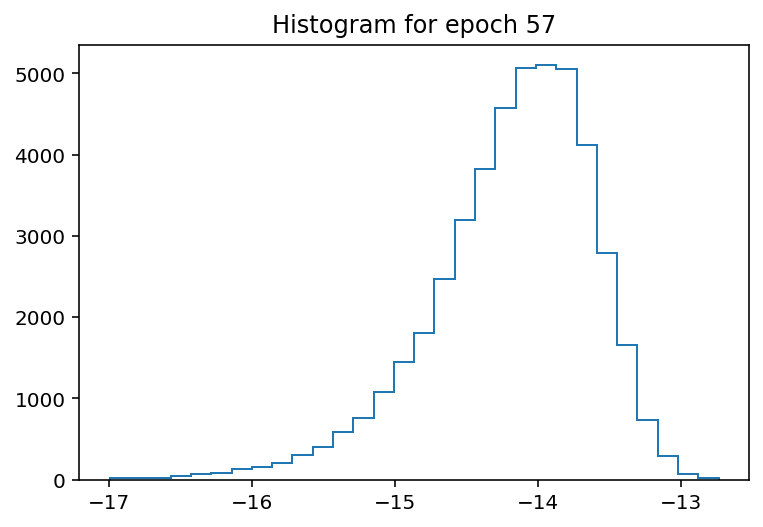

/tmp/ipykernel_21071/992575803.py:16: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


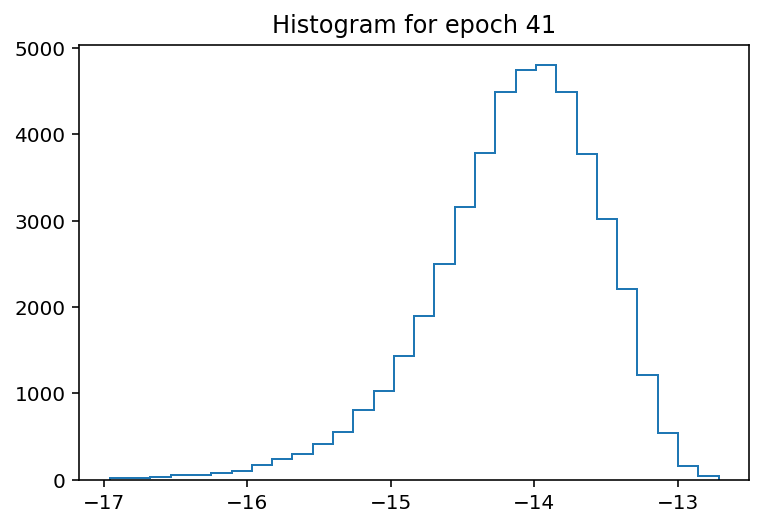

/tmp/ipykernel_21071/992575803.py:16: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


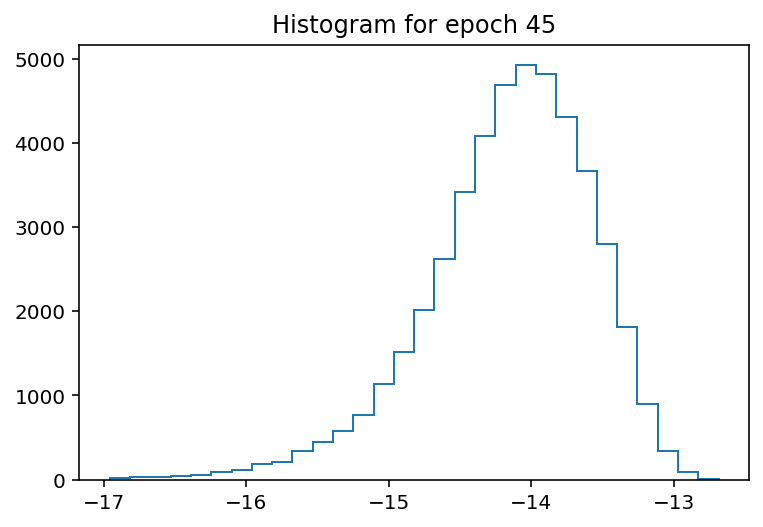

/tmp/ipykernel_21071/992575803.py:16: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


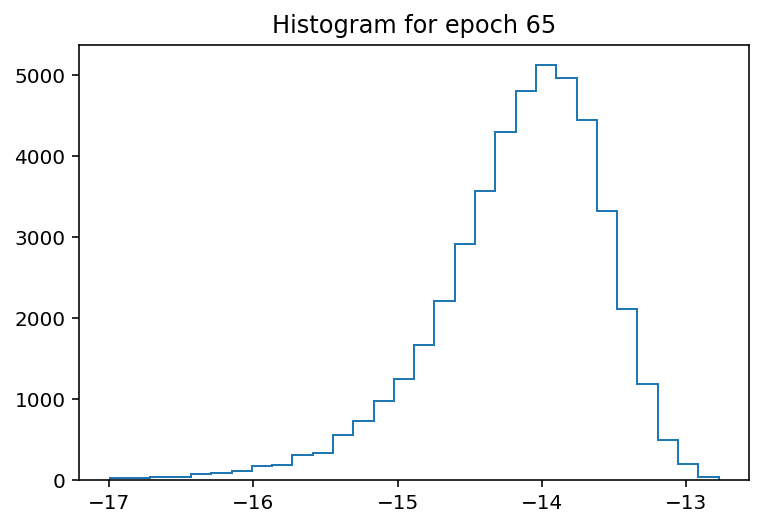

/tmp/ipykernel_21071/992575803.py:16: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


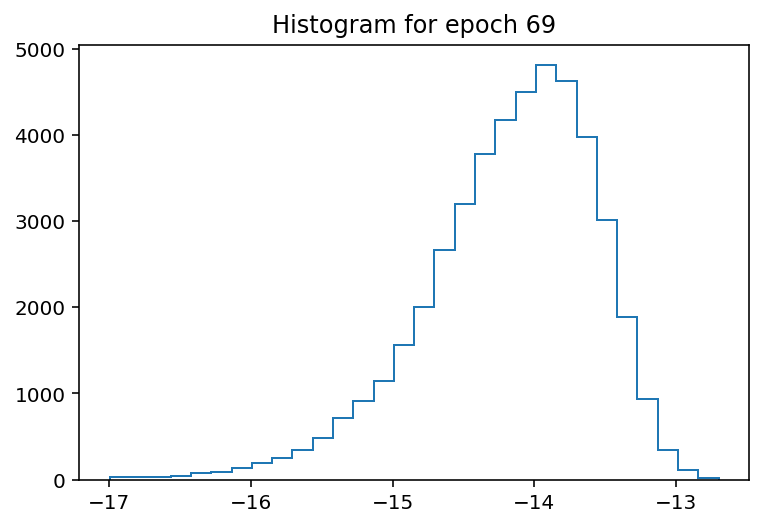

/tmp/ipykernel_21071/992575803.py:16: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


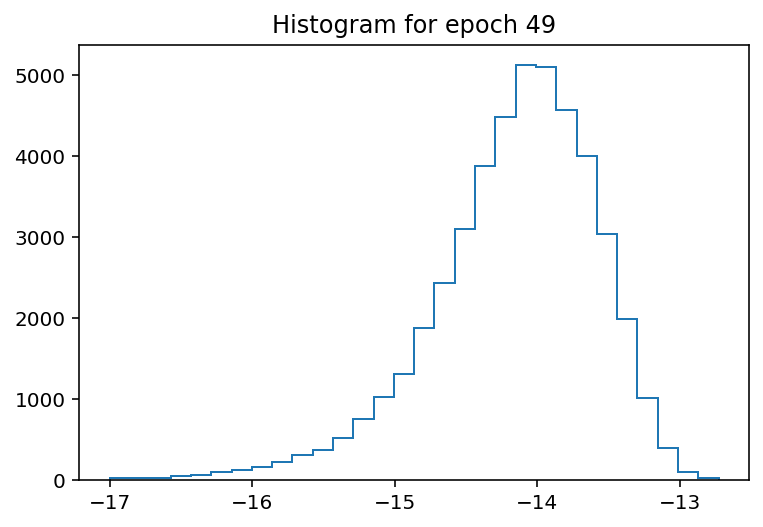

/tmp/ipykernel_21071/992575803.py:16: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


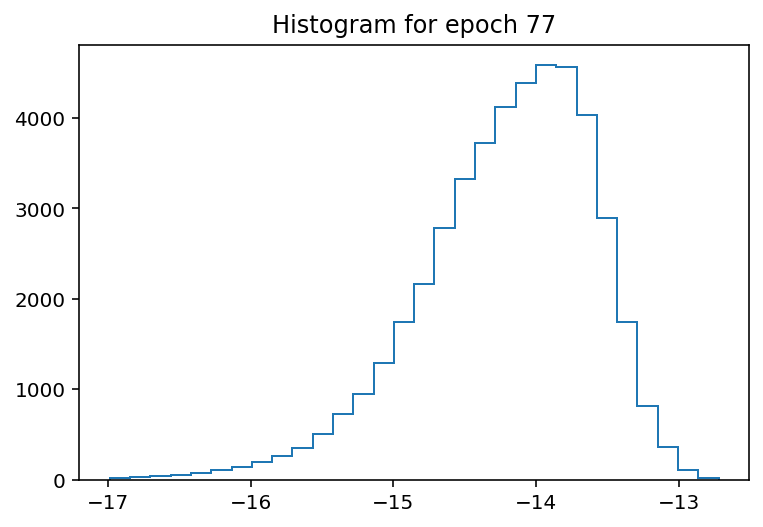

/tmp/ipykernel_21071/992575803.py:16: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


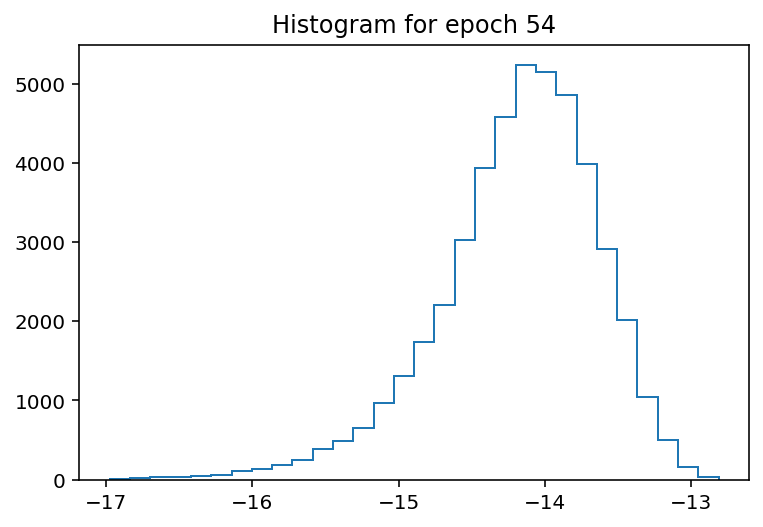

/tmp/ipykernel_21071/992575803.py:16: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


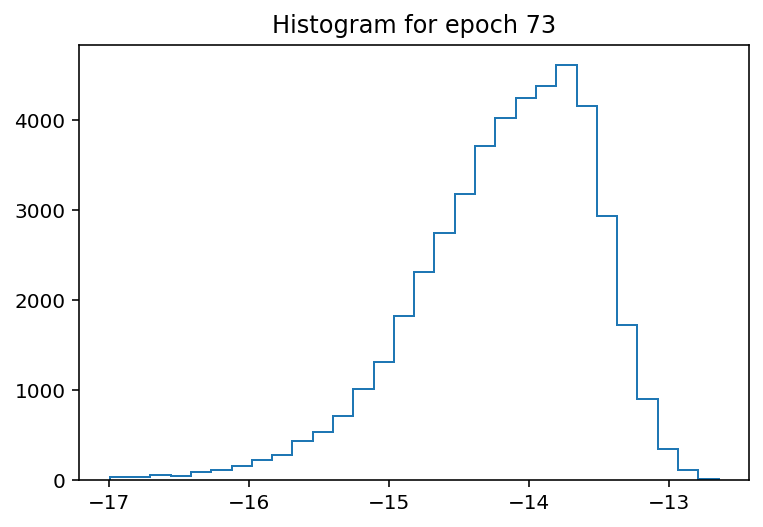

/tmp/ipykernel_21071/992575803.py:16: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


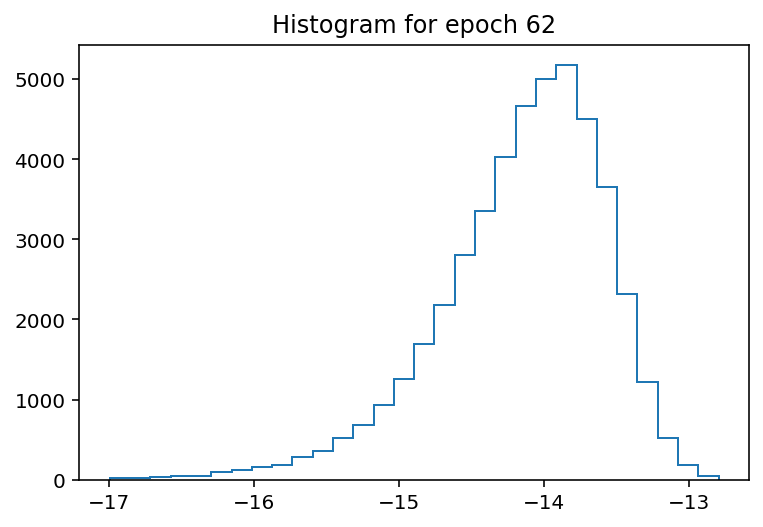

/tmp/ipykernel_21071/992575803.py:16: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


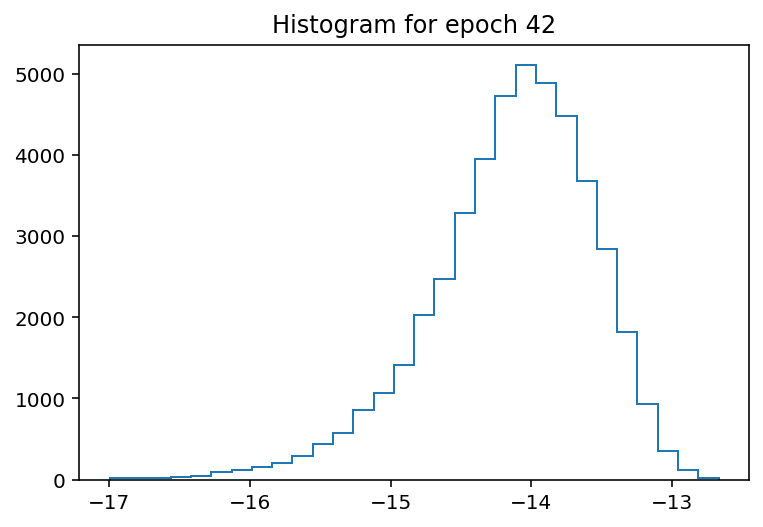

/tmp/ipykernel_21071/992575803.py:16: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


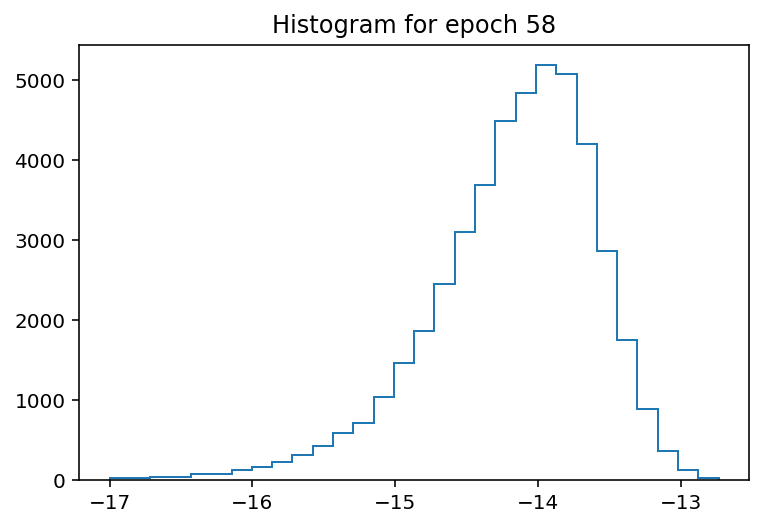

/tmp/ipykernel_21071/992575803.py:16: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


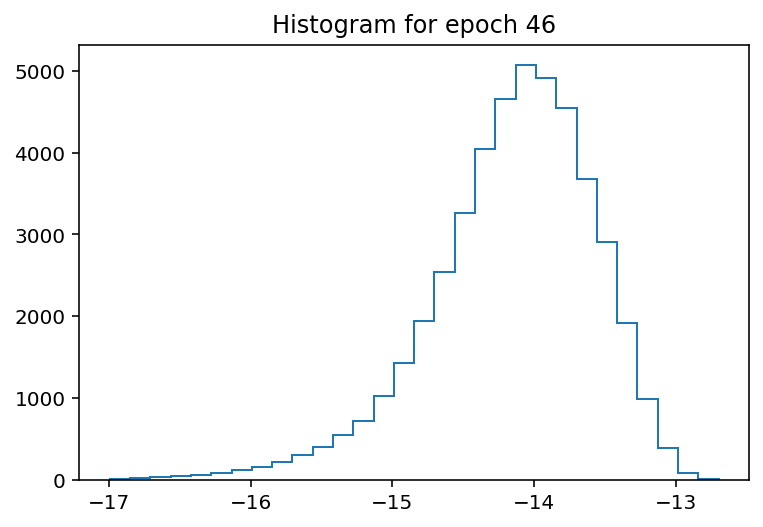

/tmp/ipykernel_21071/992575803.py:16: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


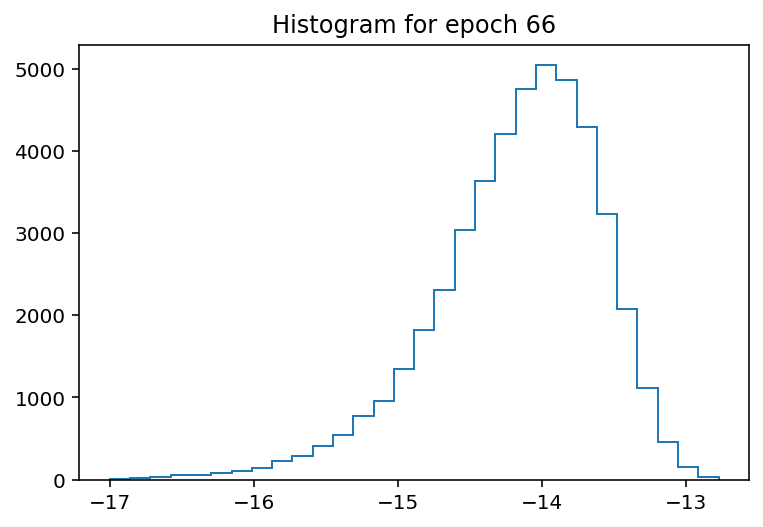

/tmp/ipykernel_21071/992575803.py:16: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


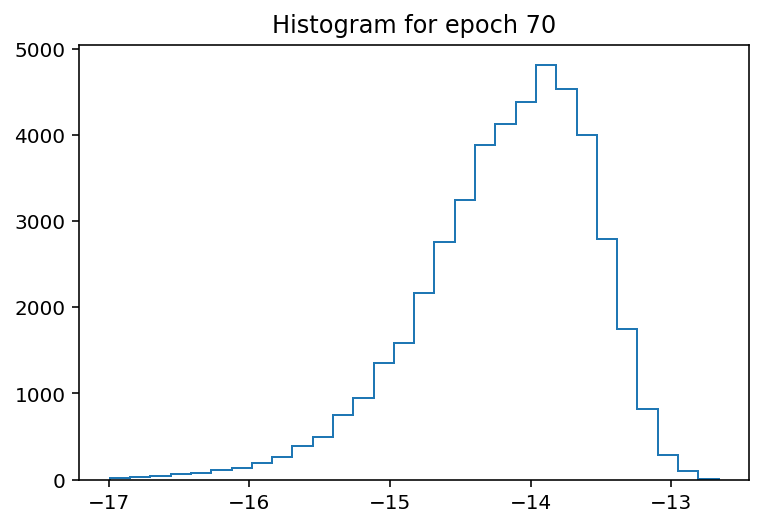

/tmp/ipykernel_21071/992575803.py:16: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


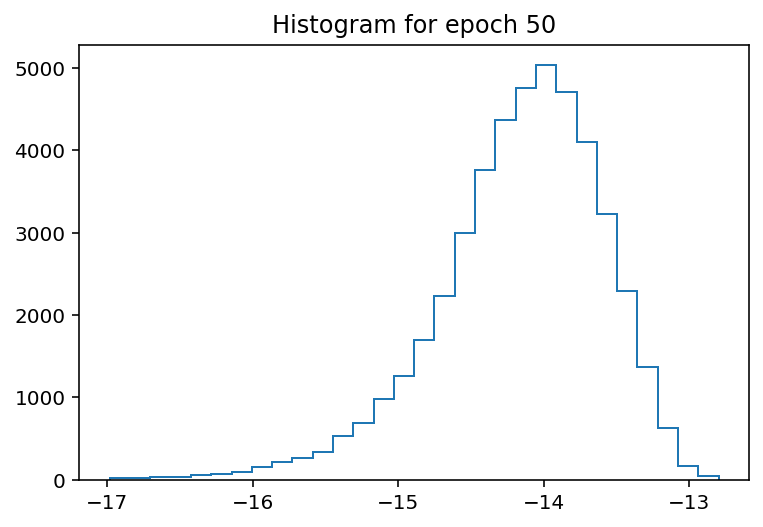

/tmp/ipykernel_21071/992575803.py:16: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


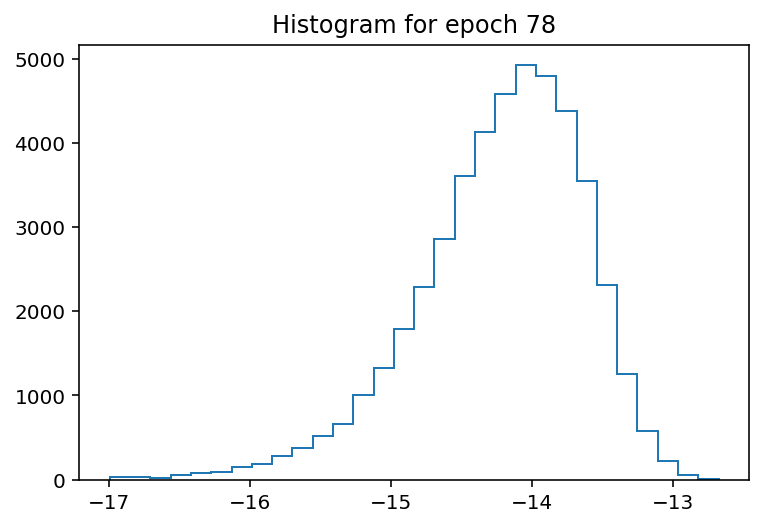

/tmp/ipykernel_21071/992575803.py:16: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


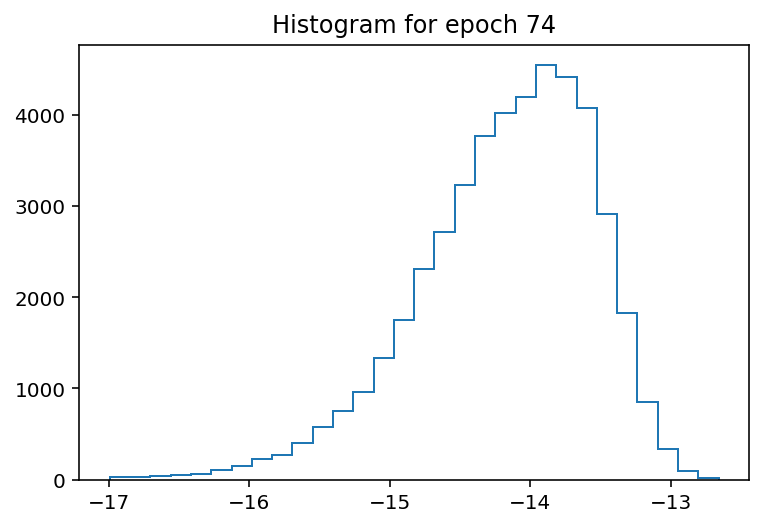

/tmp/ipykernel_21071/992575803.py:16: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


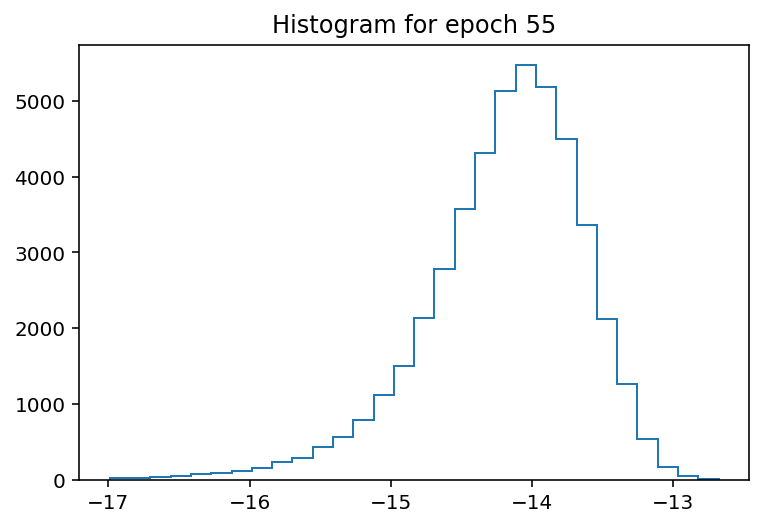

/tmp/ipykernel_21071/992575803.py:16: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


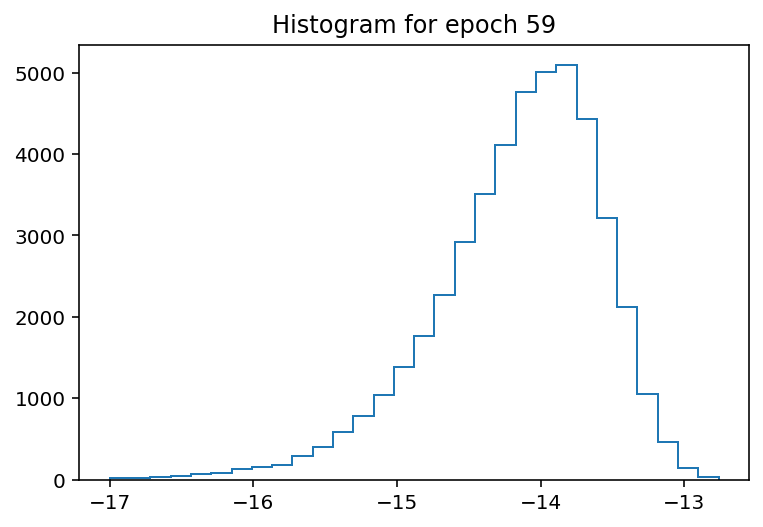

/tmp/ipykernel_21071/992575803.py:16: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


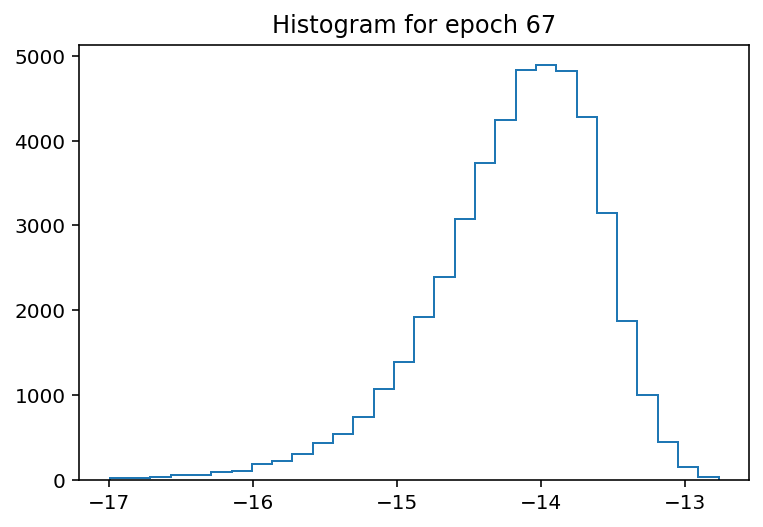

/tmp/ipykernel_21071/992575803.py:16: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


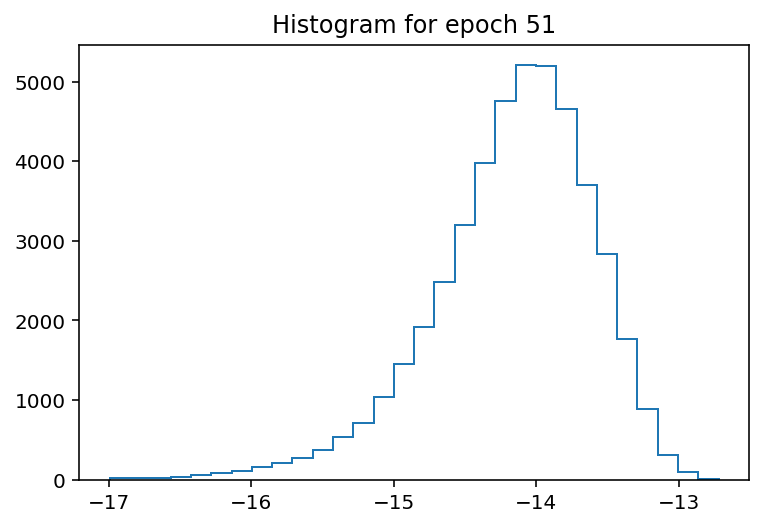

/tmp/ipykernel_21071/992575803.py:16: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


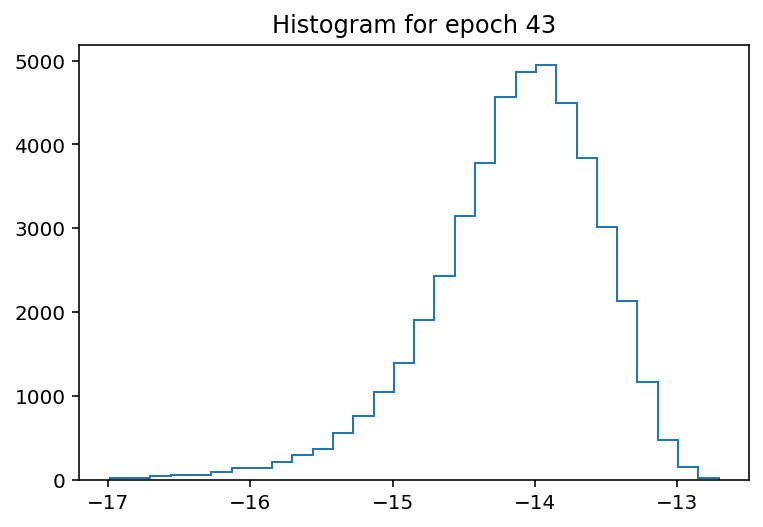

/tmp/ipykernel_21071/992575803.py:16: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


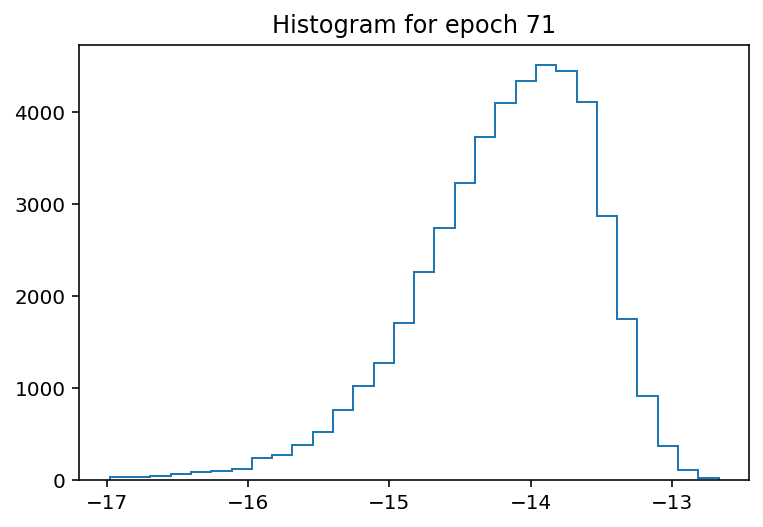

/tmp/ipykernel_21071/992575803.py:16: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


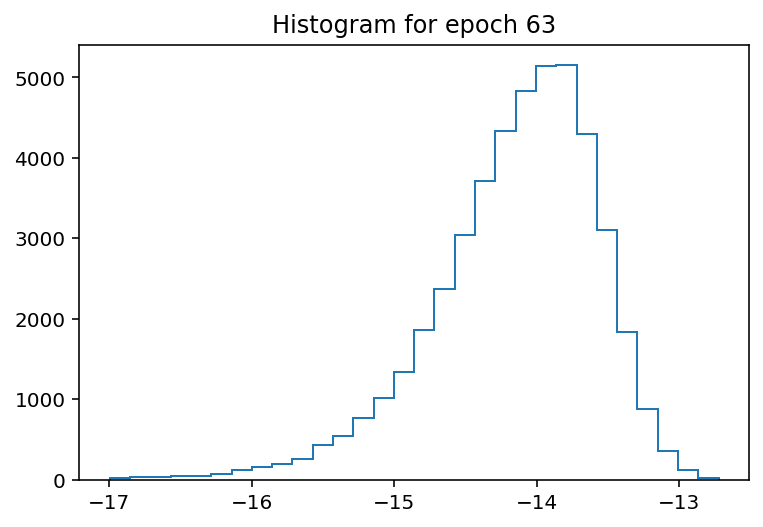

/tmp/ipykernel_21071/992575803.py:16: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


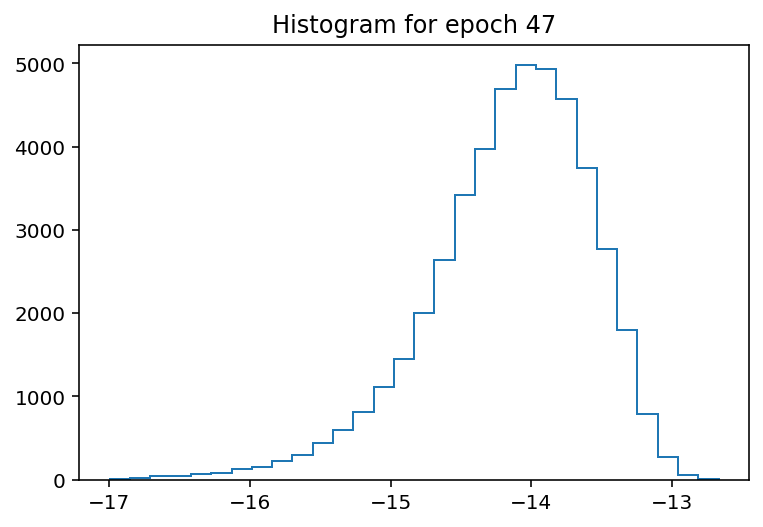

/tmp/ipykernel_21071/992575803.py:16: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


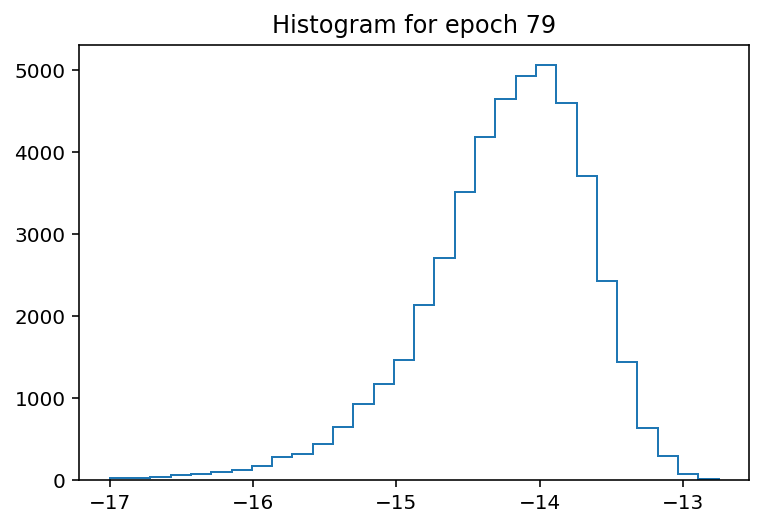

/tmp/ipykernel_21071/992575803.py:16: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


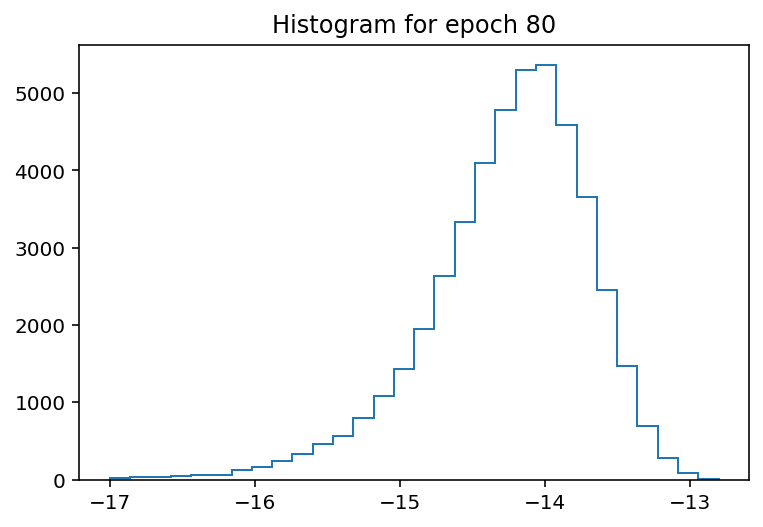

/tmp/ipykernel_21071/992575803.py:16: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


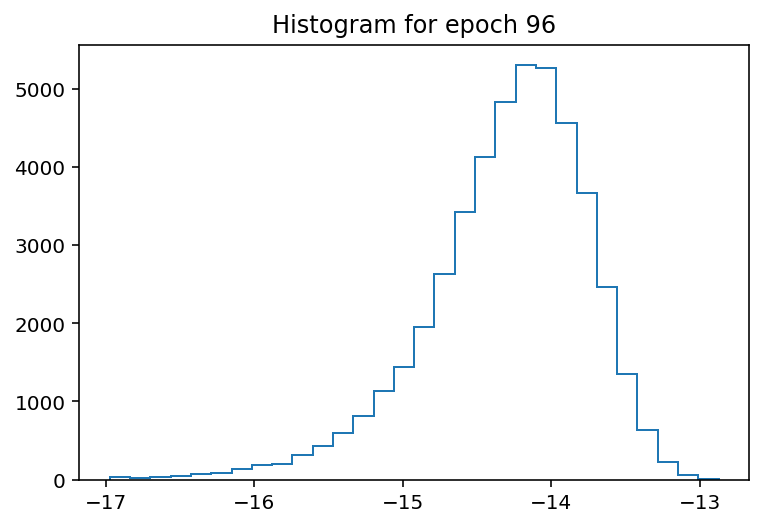

/tmp/ipykernel_21071/992575803.py:16: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


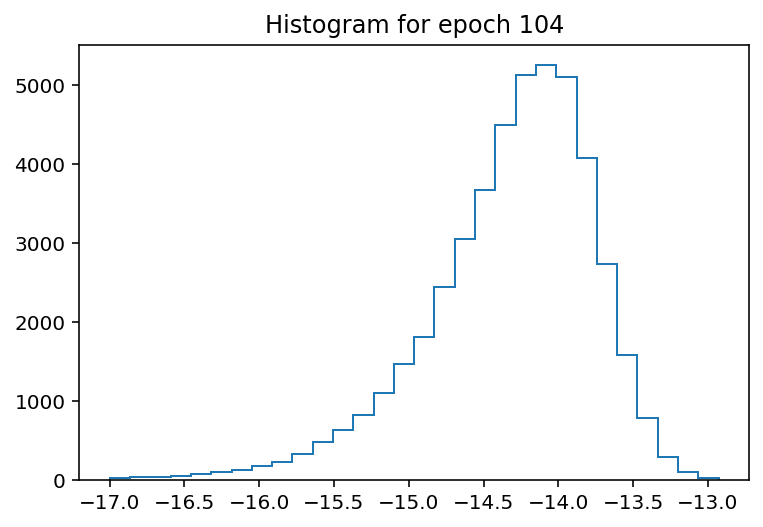

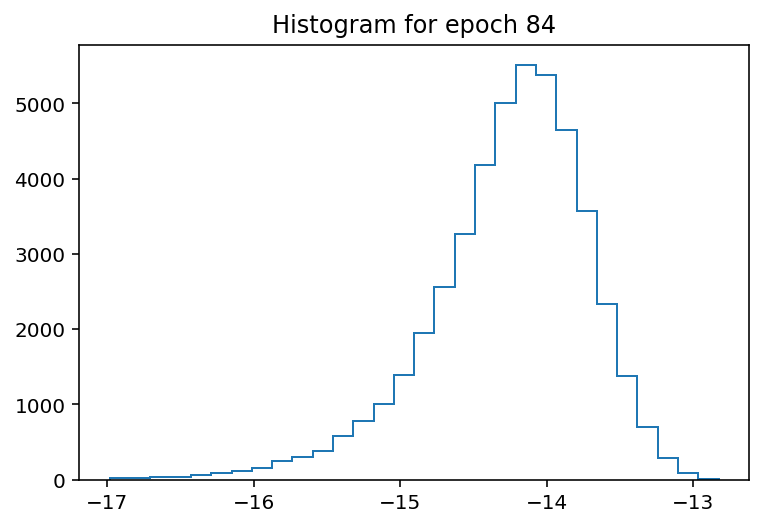

/tmp/ipykernel_21071/992575803.py:16: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max
/tmp/ipykernel_21071/992575803.py:16: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


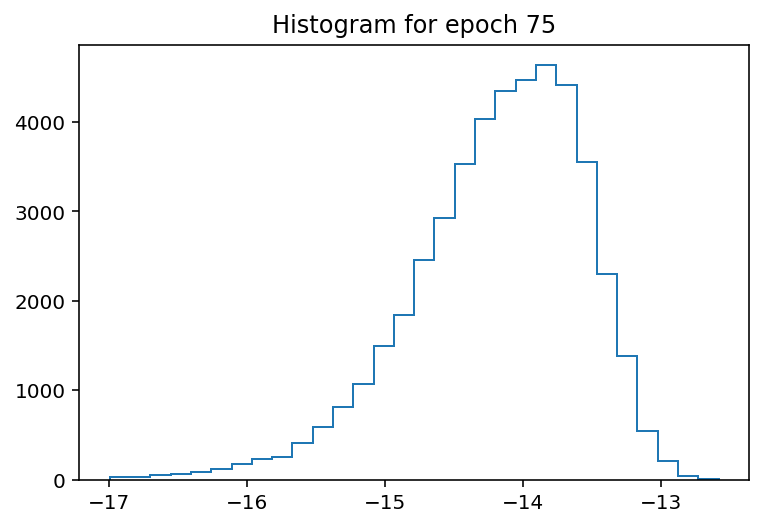

/tmp/ipykernel_21071/992575803.py:16: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


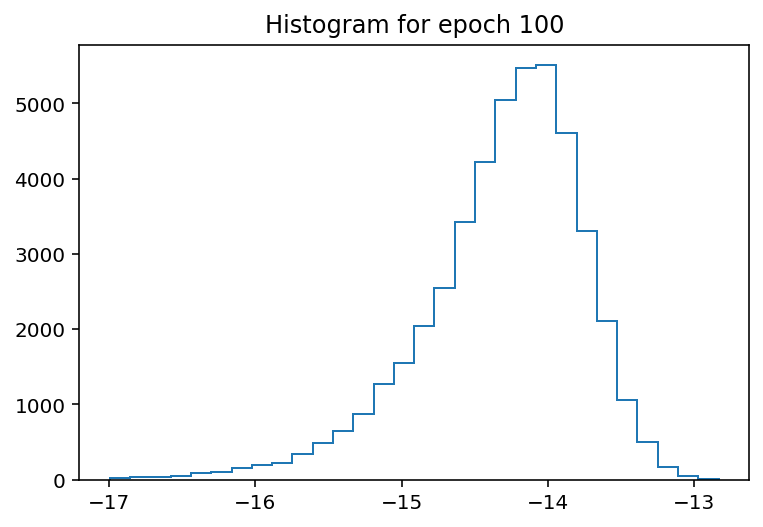

/tmp/ipykernel_21071/992575803.py:16: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


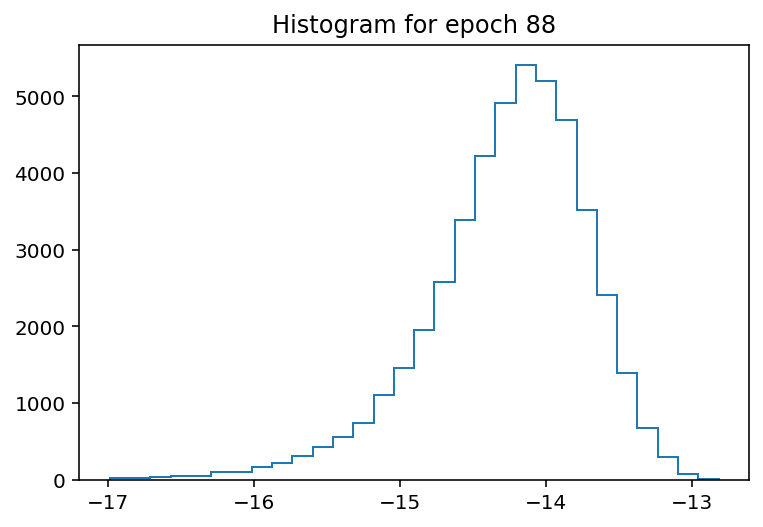

/tmp/ipykernel_21071/992575803.py:16: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


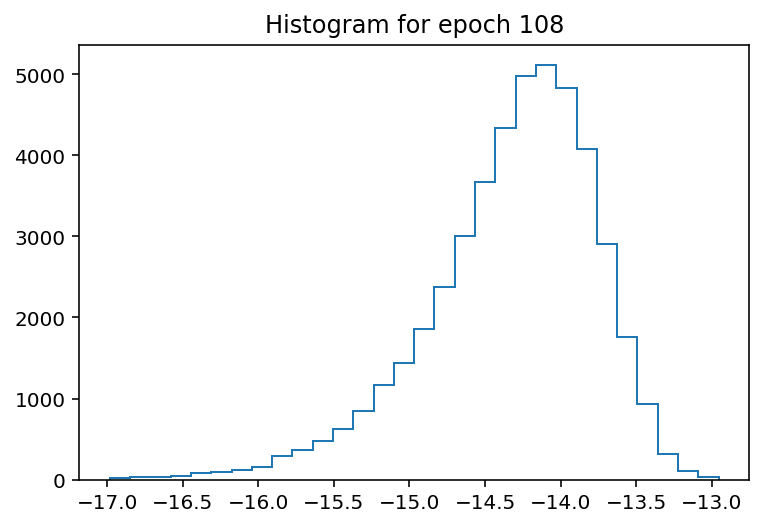

/tmp/ipykernel_21071/992575803.py:16: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


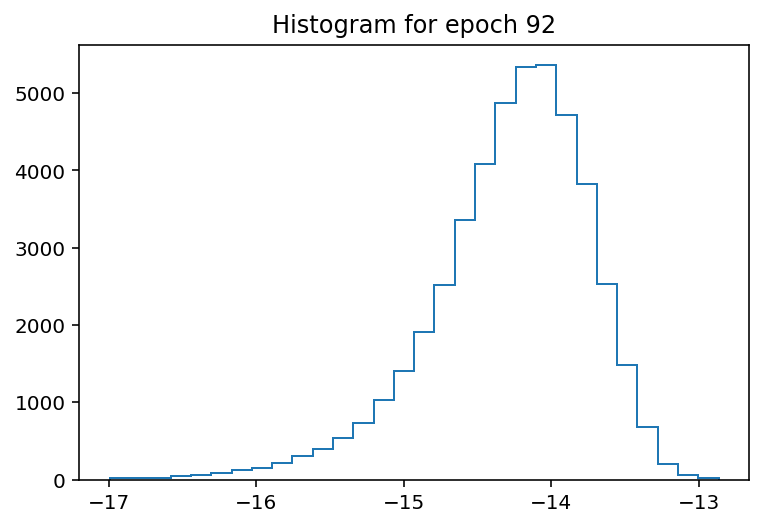

/tmp/ipykernel_21071/992575803.py:16: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


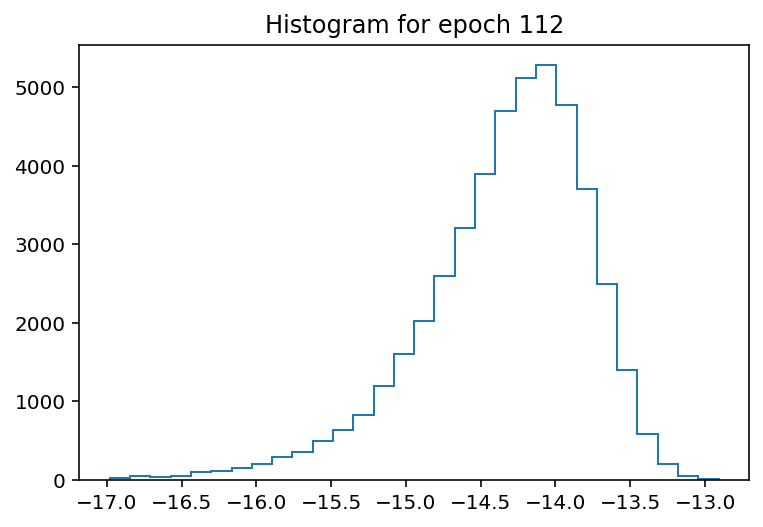

/tmp/ipykernel_21071/992575803.py:16: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


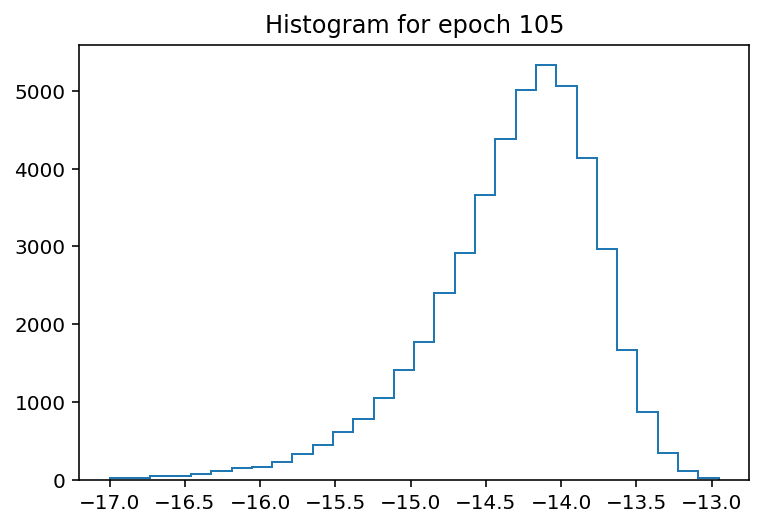

/tmp/ipykernel_21071/992575803.py:16: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


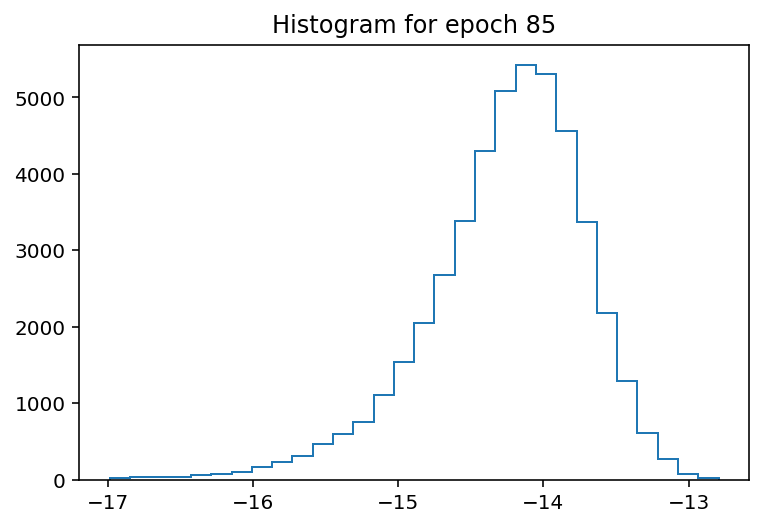

/tmp/ipykernel_21071/992575803.py:16: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


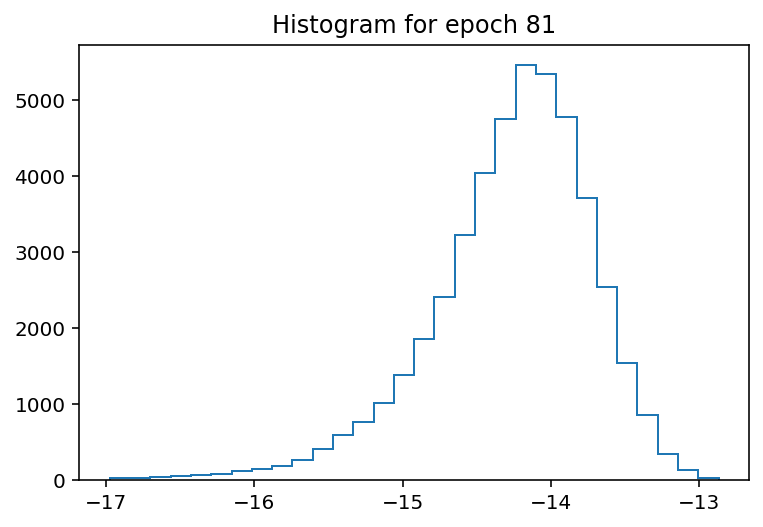

/tmp/ipykernel_21071/992575803.py:16: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


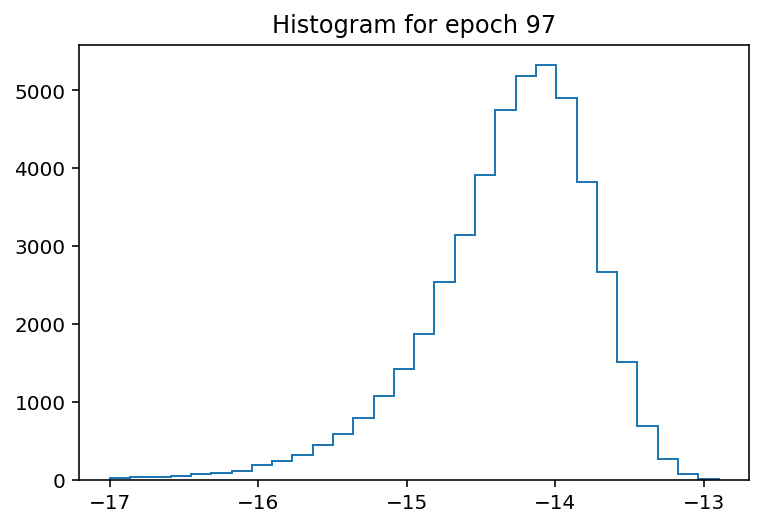

/tmp/ipykernel_21071/992575803.py:16: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


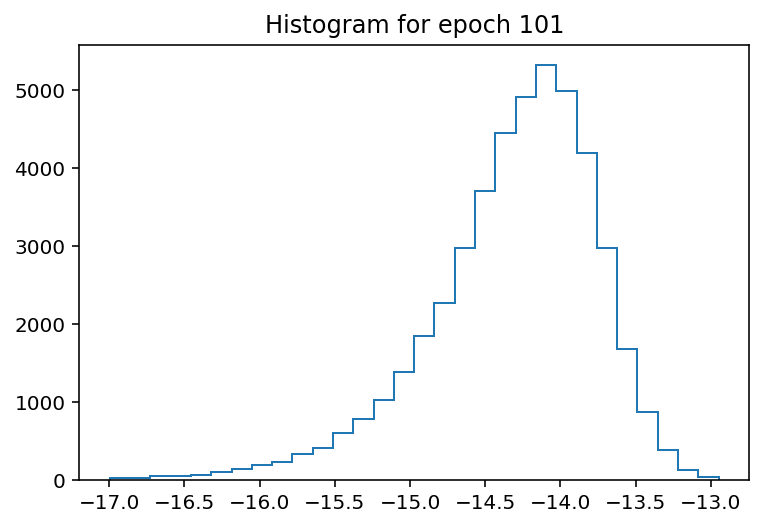

/tmp/ipykernel_21071/992575803.py:16: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


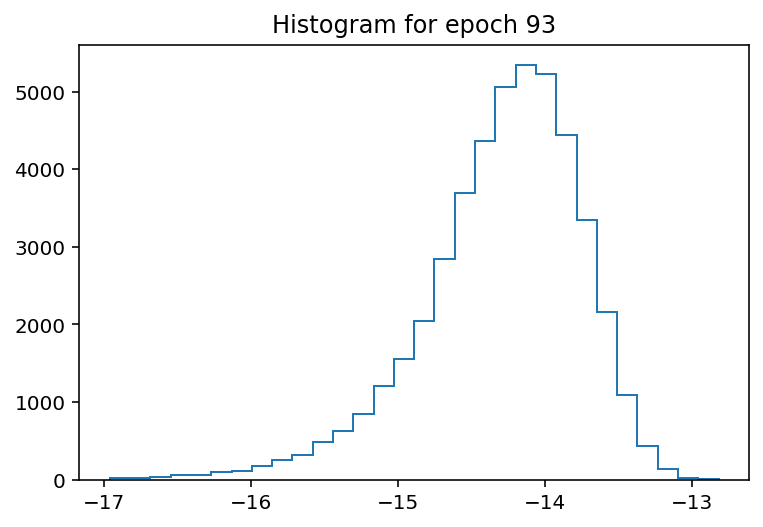

/tmp/ipykernel_21071/992575803.py:16: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


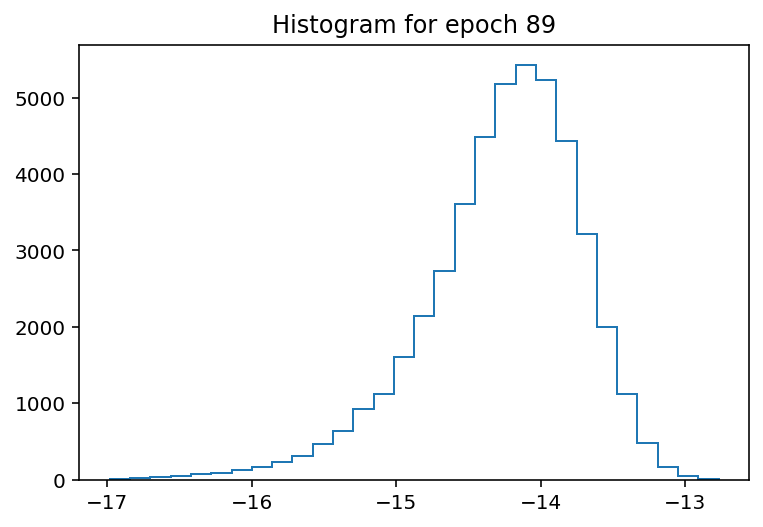

/tmp/ipykernel_21071/992575803.py:16: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


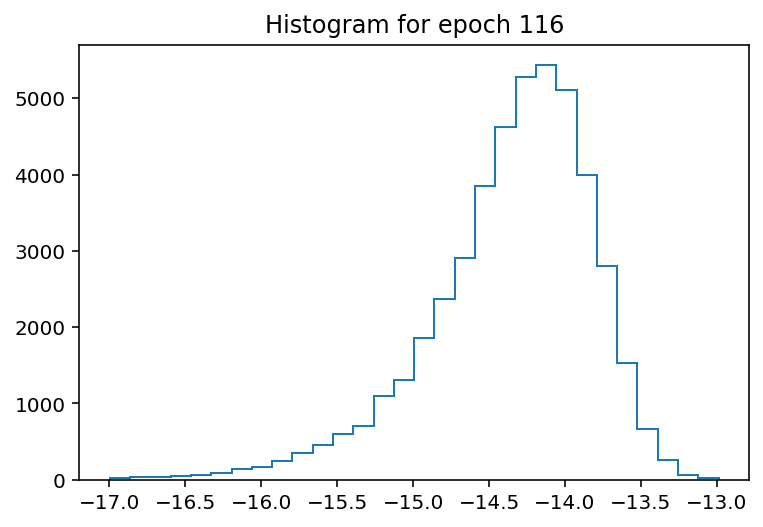

/tmp/ipykernel_21071/992575803.py:16: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


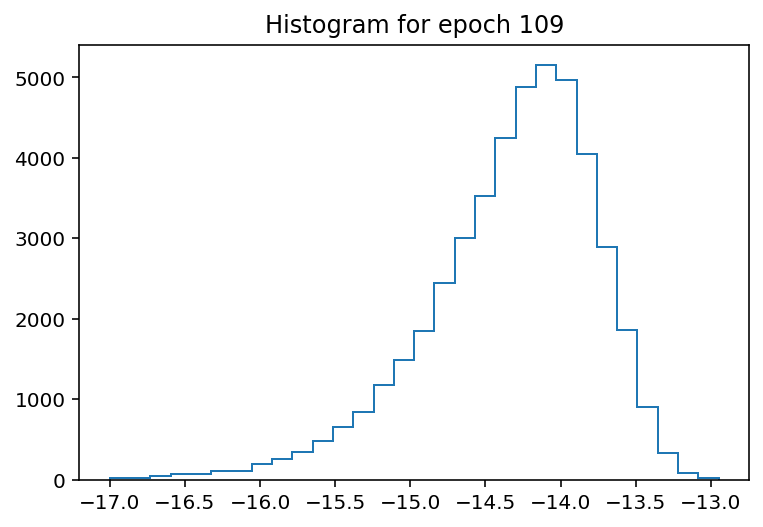

/tmp/ipykernel_21071/992575803.py:16: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


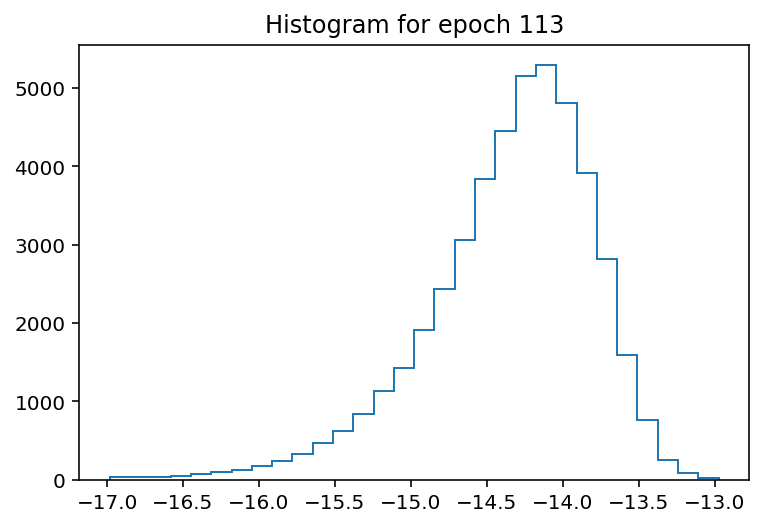

/tmp/ipykernel_21071/992575803.py:16: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


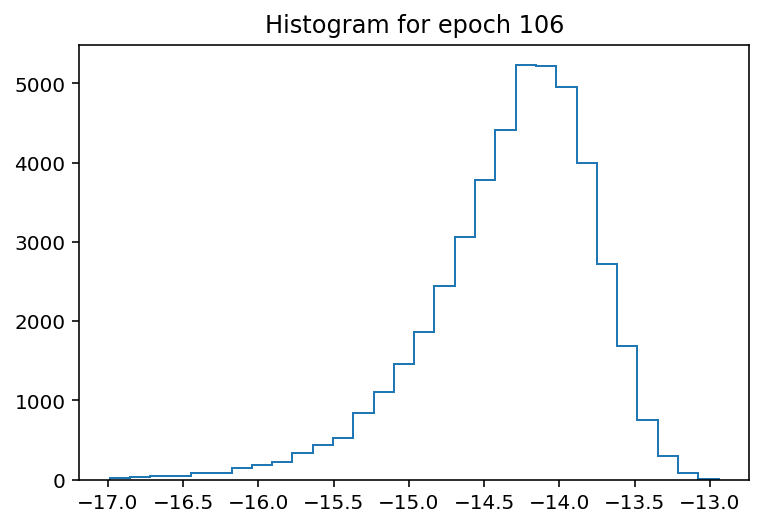

/tmp/ipykernel_21071/992575803.py:16: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


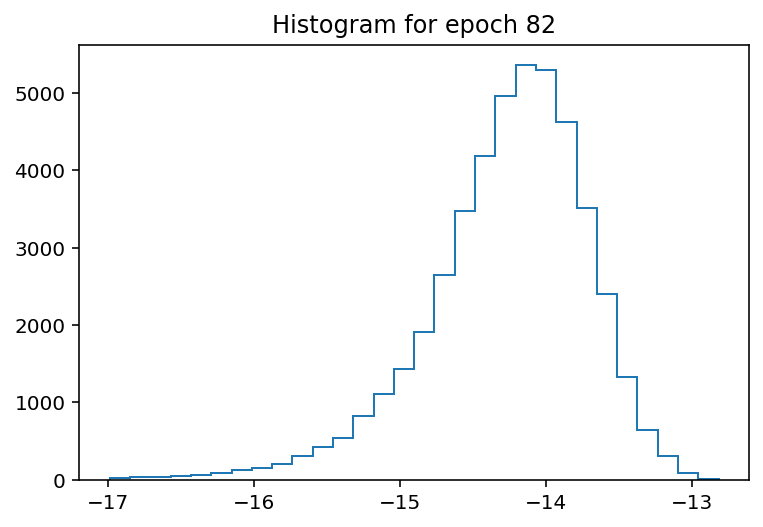

/tmp/ipykernel_21071/992575803.py:16: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


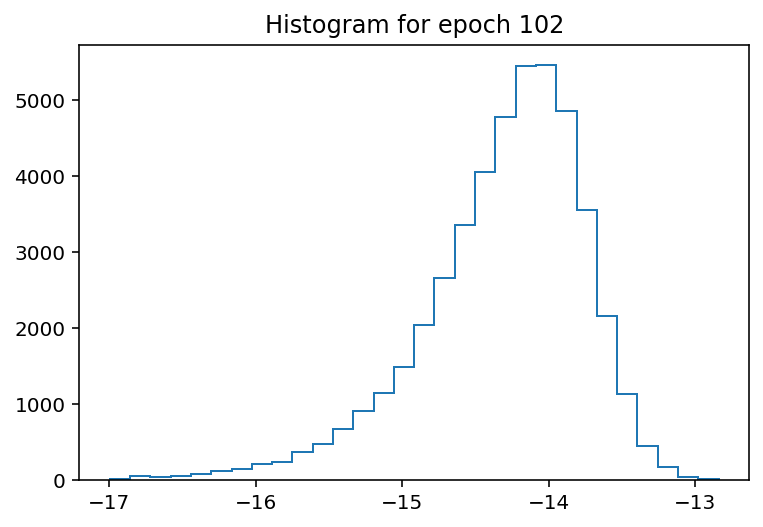

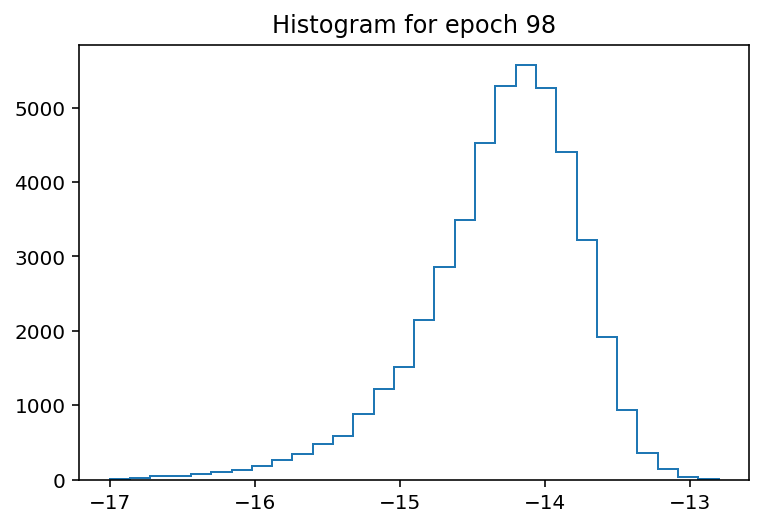

/tmp/ipykernel_21071/992575803.py:16: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max
/tmp/ipykernel_21071/992575803.py:16: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


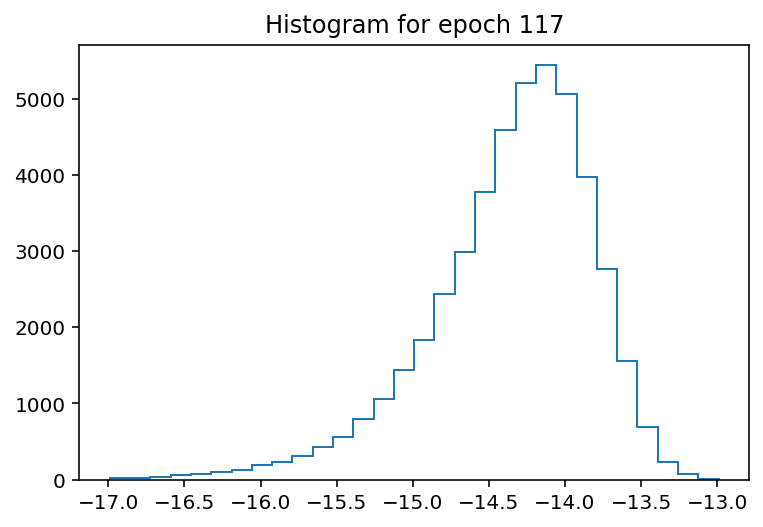

/tmp/ipykernel_21071/992575803.py:16: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


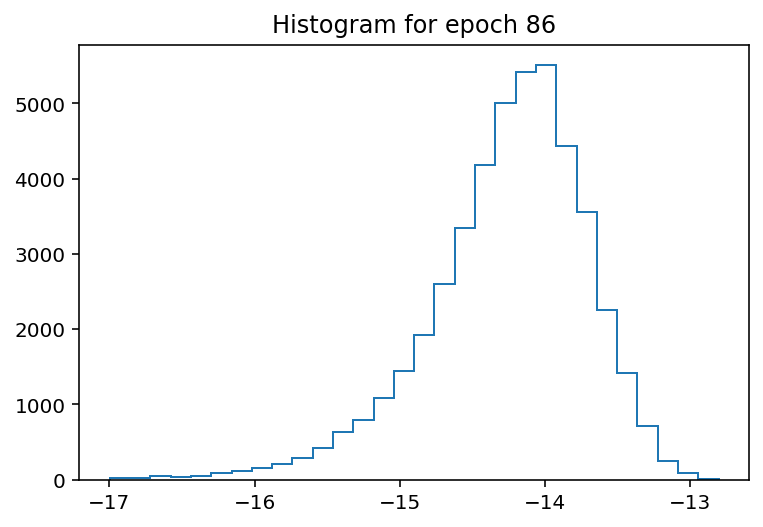

/tmp/ipykernel_21071/992575803.py:16: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


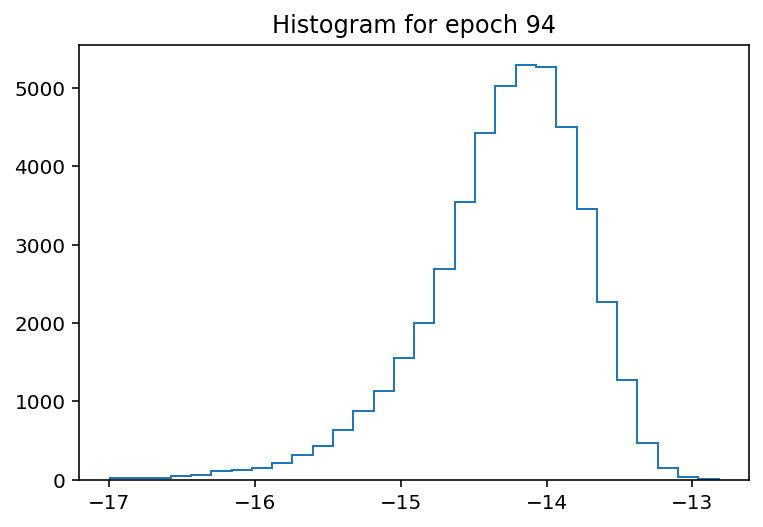

/tmp/ipykernel_21071/992575803.py:16: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


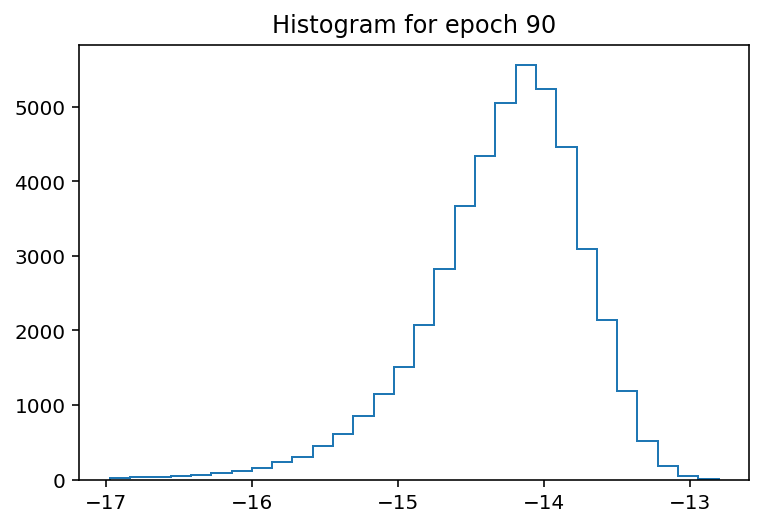

/tmp/ipykernel_21071/992575803.py:16: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


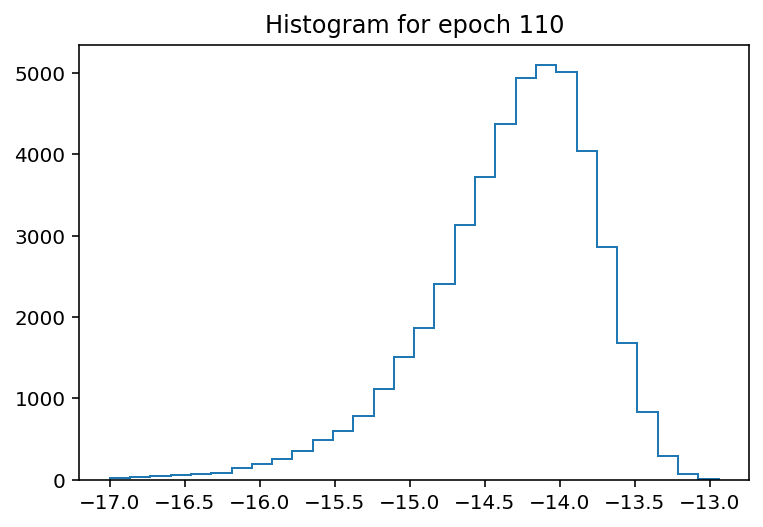

/tmp/ipykernel_21071/992575803.py:16: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


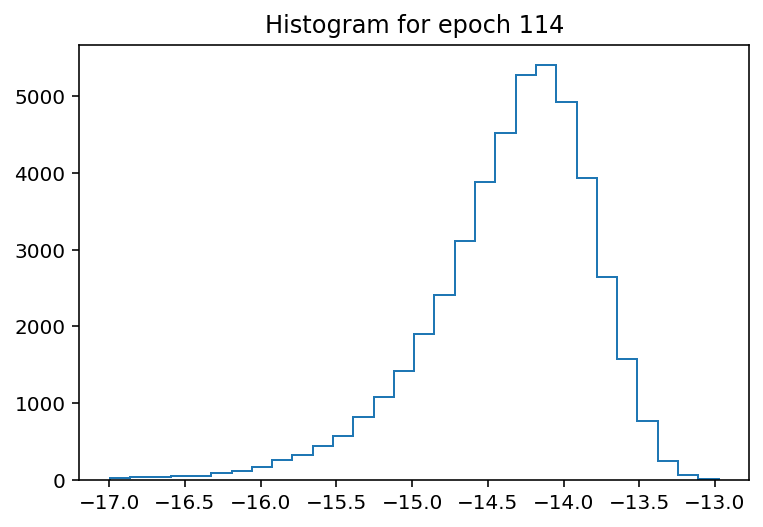

/tmp/ipykernel_21071/992575803.py:16: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


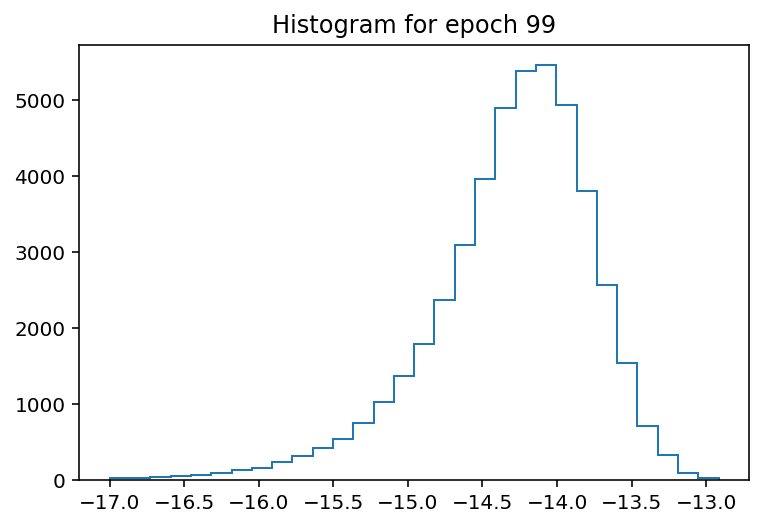

/tmp/ipykernel_21071/992575803.py:16: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


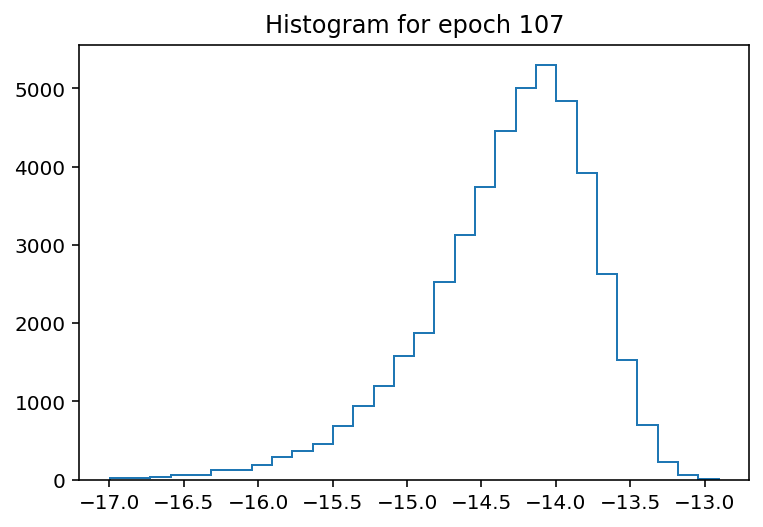

/tmp/ipykernel_21071/992575803.py:16: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


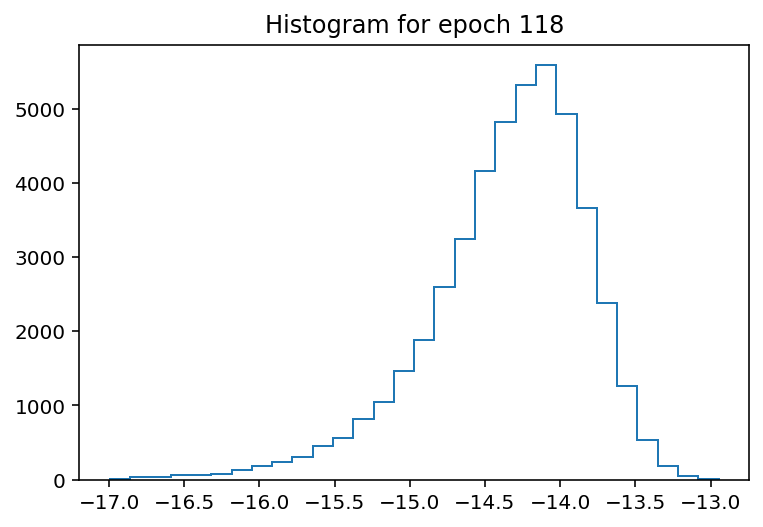

/tmp/ipykernel_21071/992575803.py:16: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


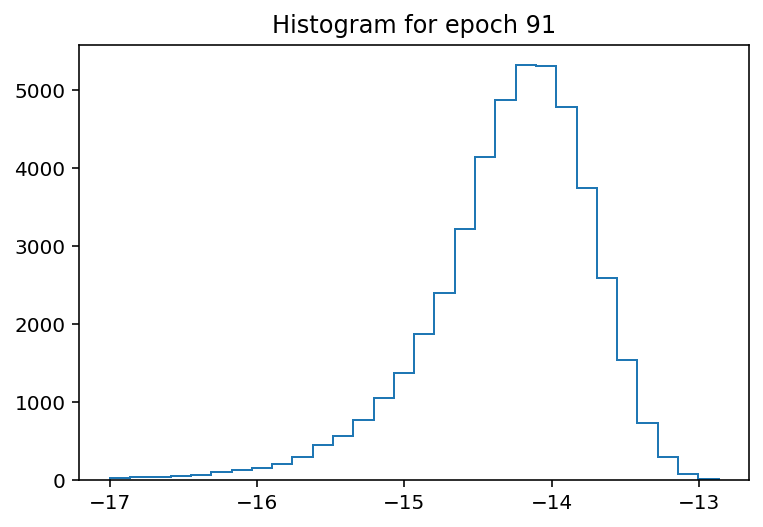

/tmp/ipykernel_21071/992575803.py:16: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


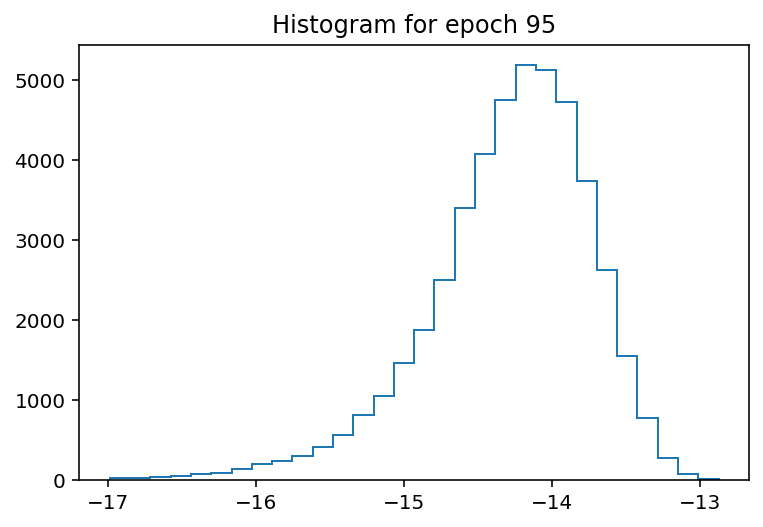

/tmp/ipykernel_21071/992575803.py:16: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


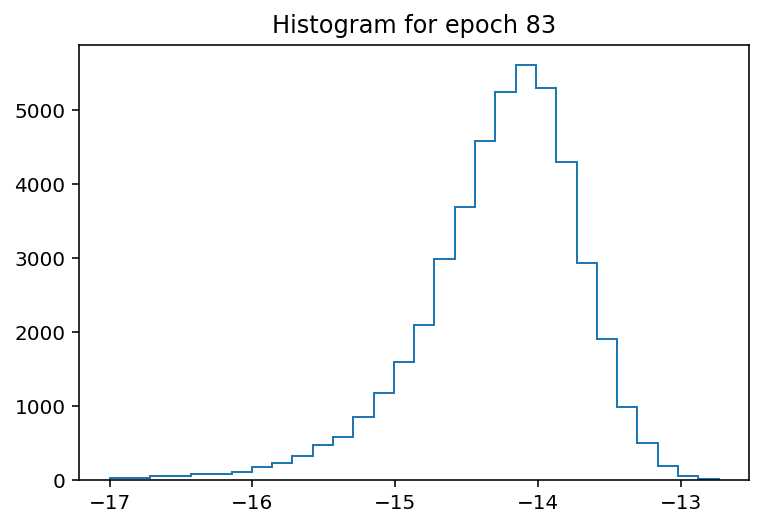

/tmp/ipykernel_21071/992575803.py:16: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


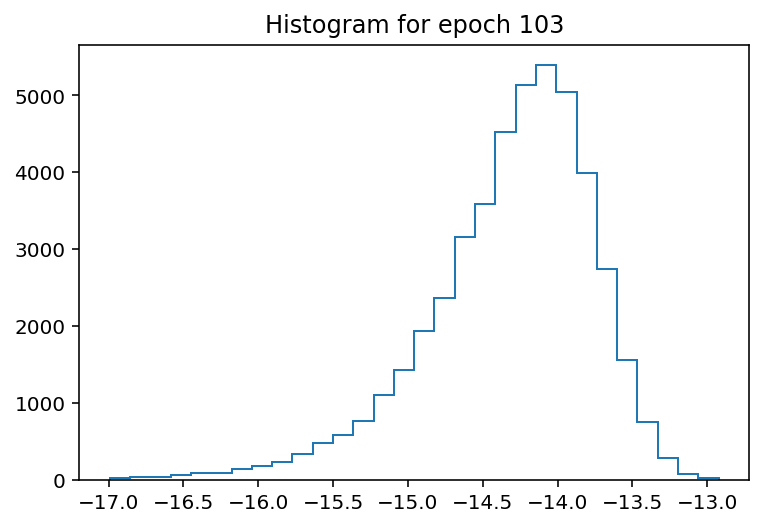

/tmp/ipykernel_21071/992575803.py:16: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


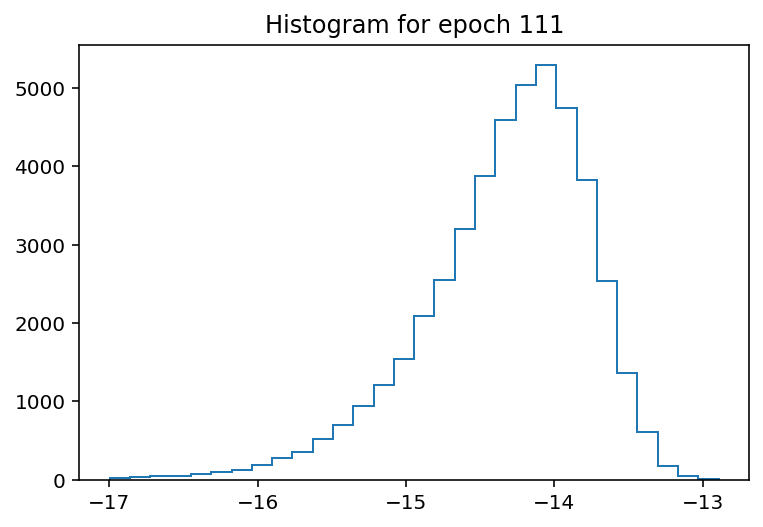

/tmp/ipykernel_21071/992575803.py:16: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


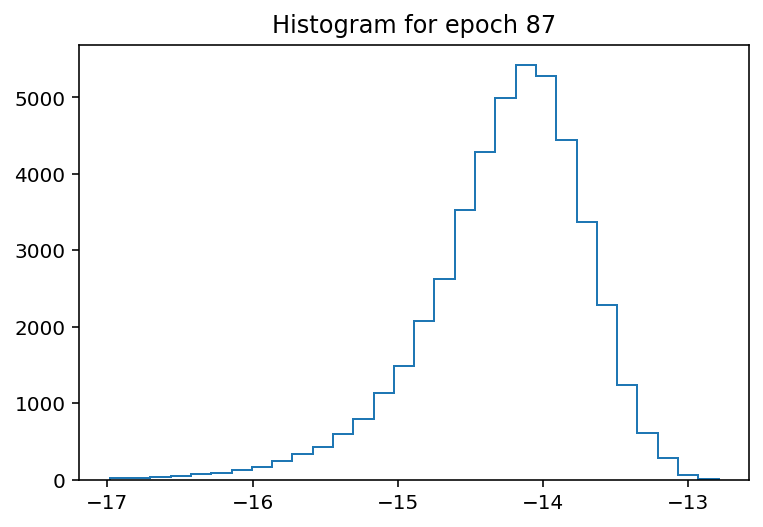

/tmp/ipykernel_21071/992575803.py:16: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


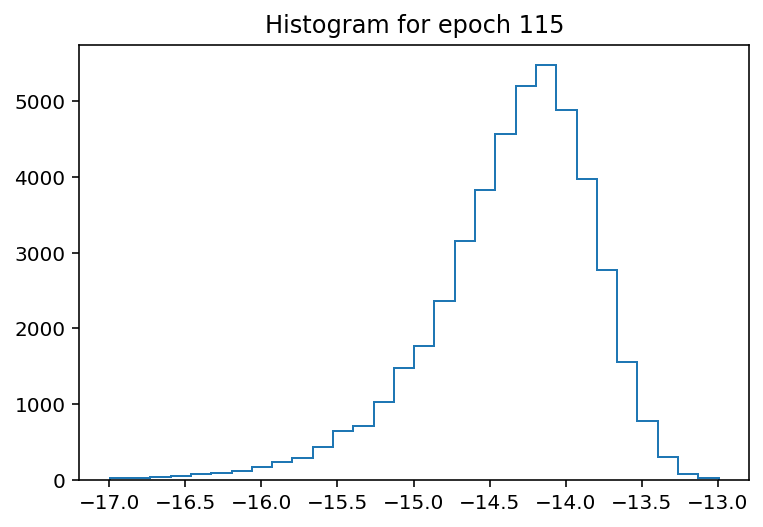

/tmp/ipykernel_21071/992575803.py:16: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


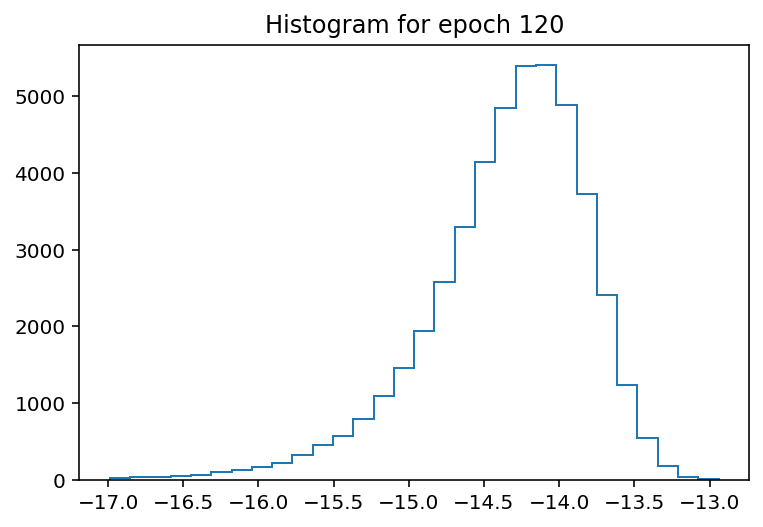

/tmp/ipykernel_21071/992575803.py:16: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


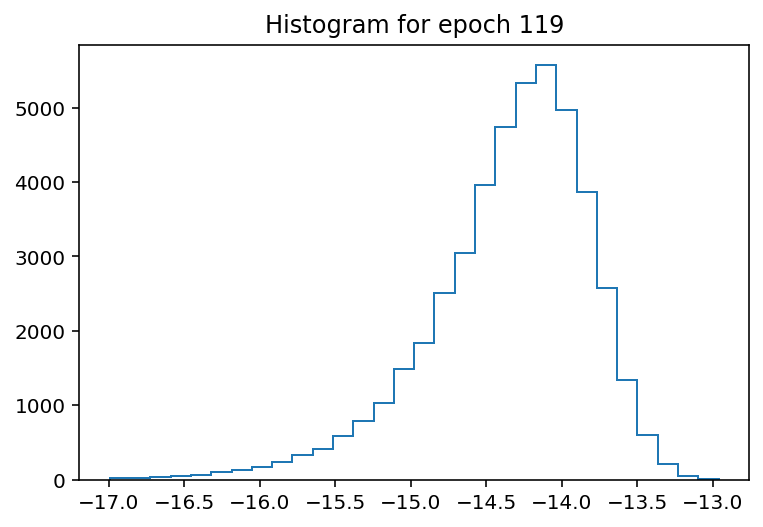

/tmp/ipykernel_21071/992575803.py:16: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


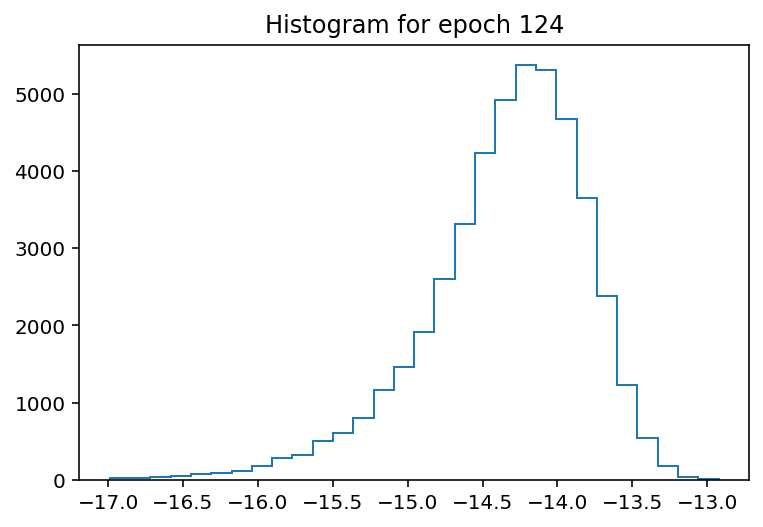

/tmp/ipykernel_21071/992575803.py:16: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


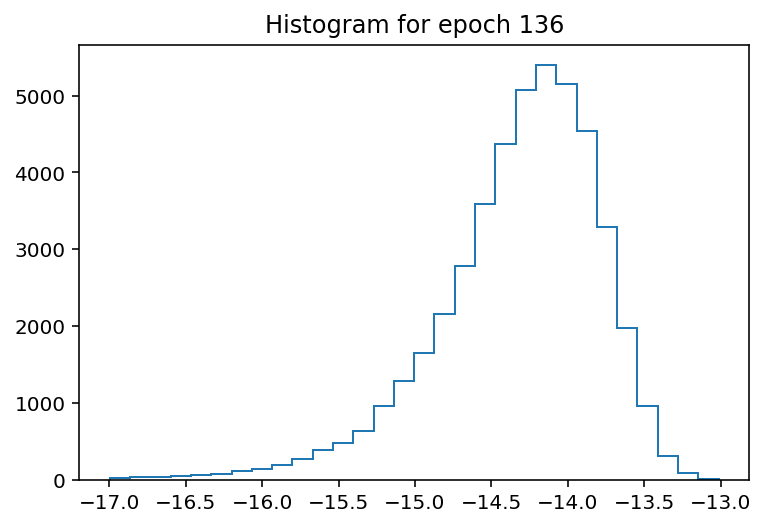

/tmp/ipykernel_21071/992575803.py:16: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


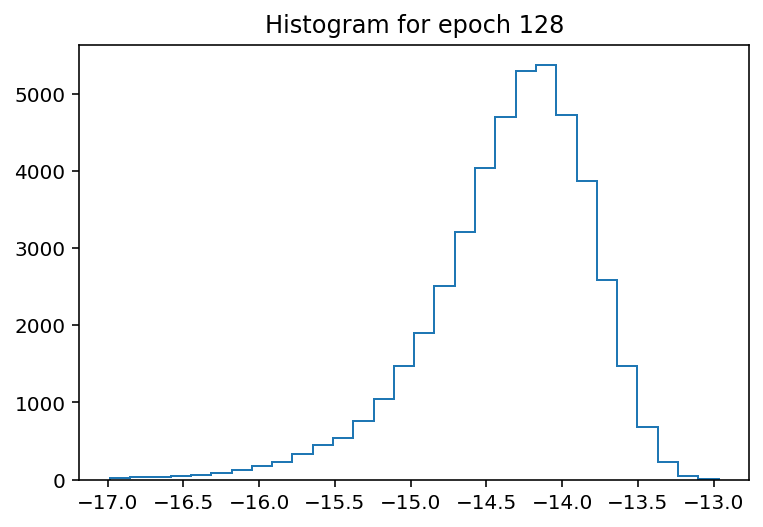

/tmp/ipykernel_21071/992575803.py:16: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


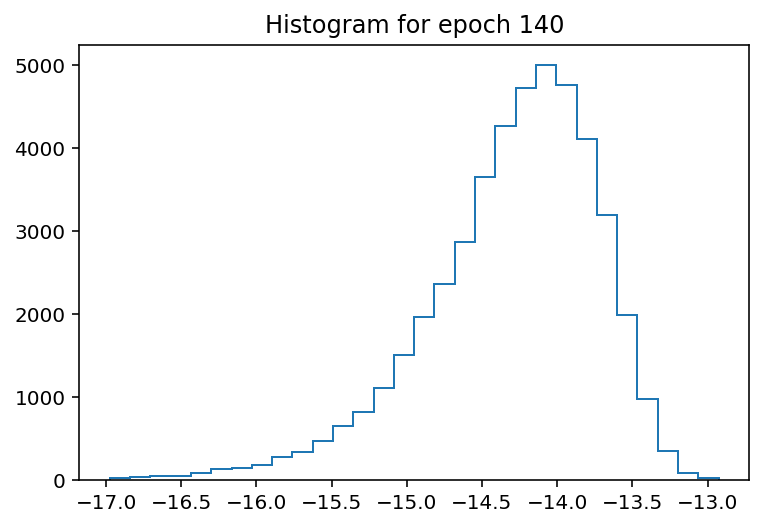

/tmp/ipykernel_21071/992575803.py:16: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


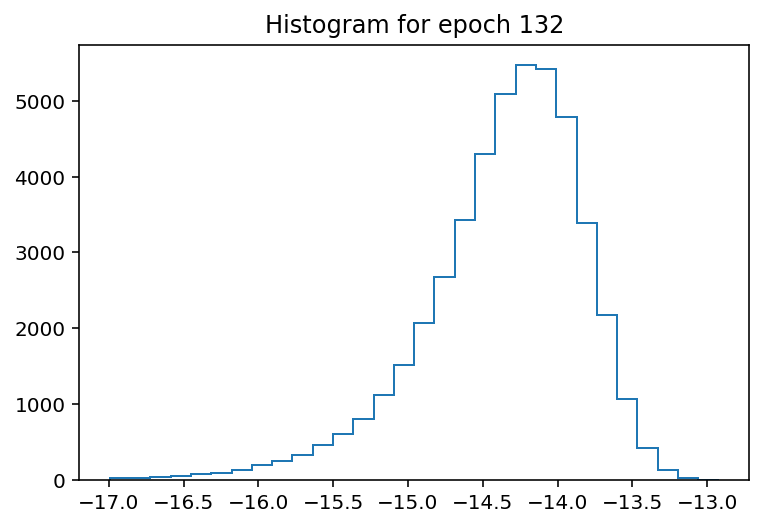

/tmp/ipykernel_21071/992575803.py:16: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


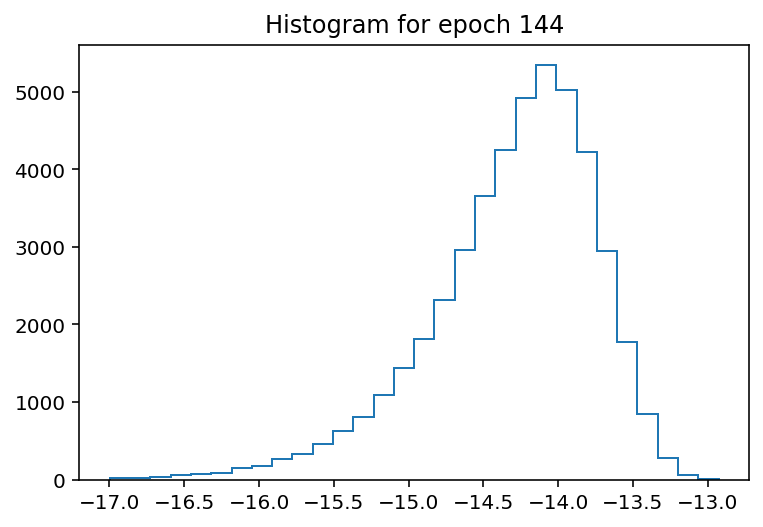

/tmp/ipykernel_21071/992575803.py:16: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


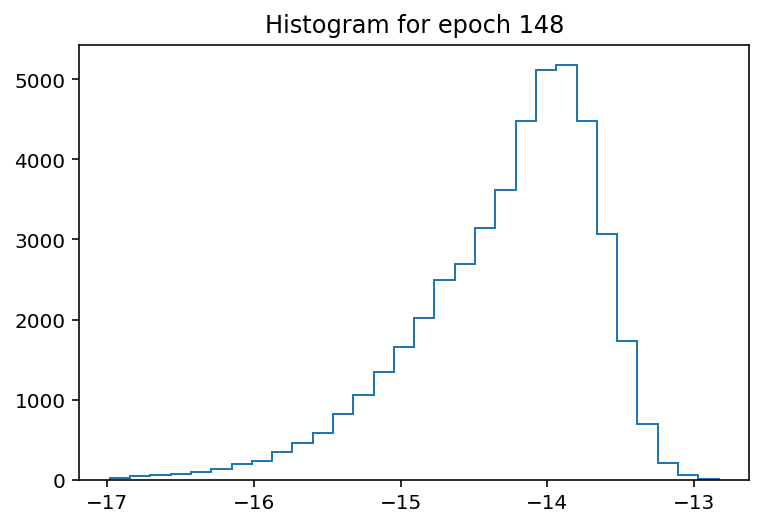

/tmp/ipykernel_21071/992575803.py:16: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


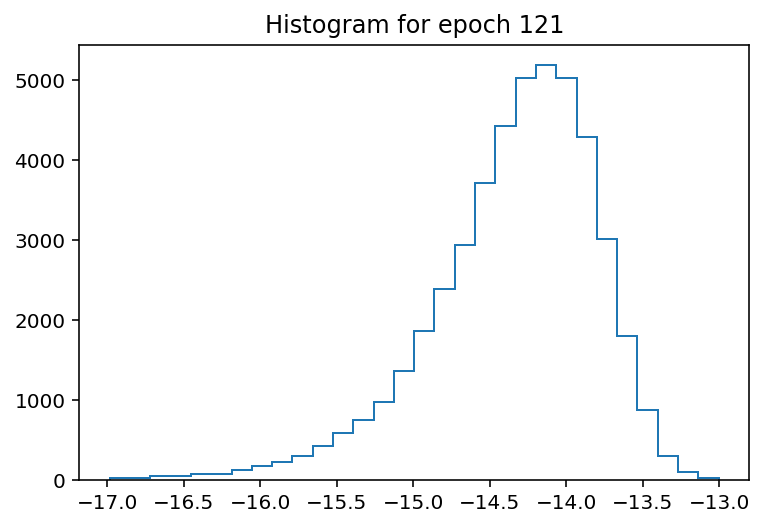

/tmp/ipykernel_21071/992575803.py:16: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


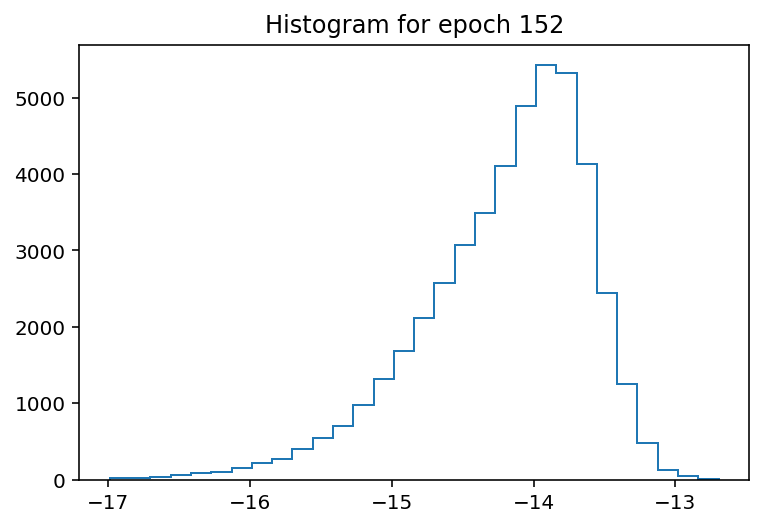

/tmp/ipykernel_21071/992575803.py:16: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


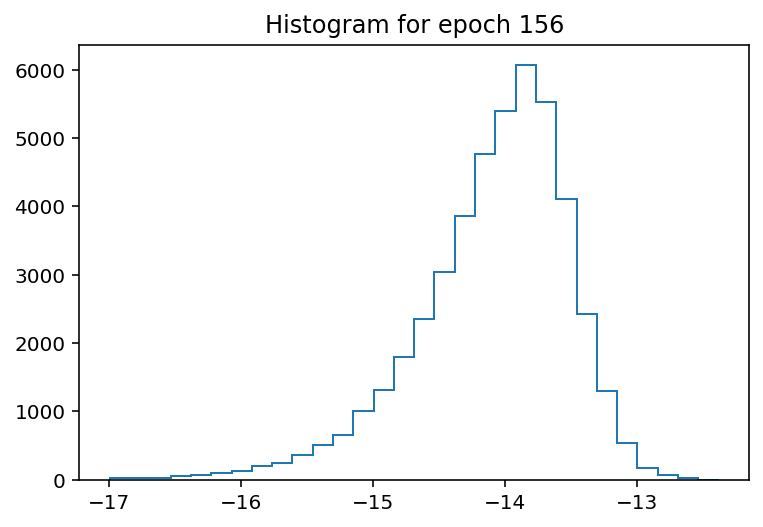

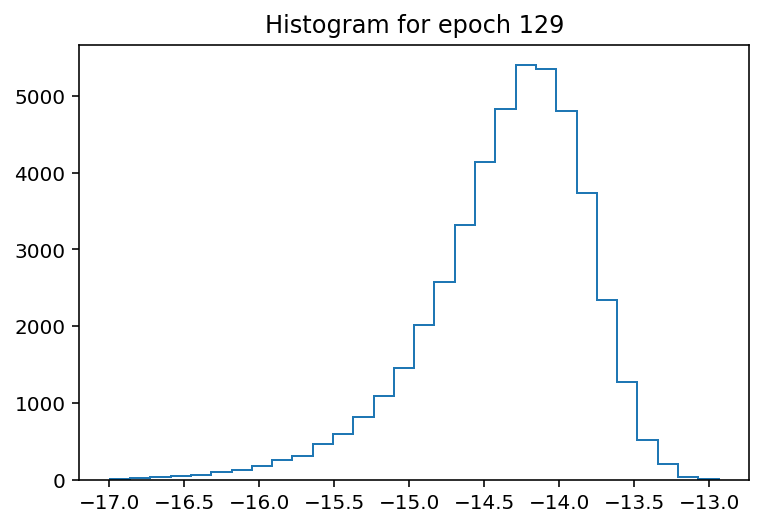

/tmp/ipykernel_21071/992575803.py:16: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


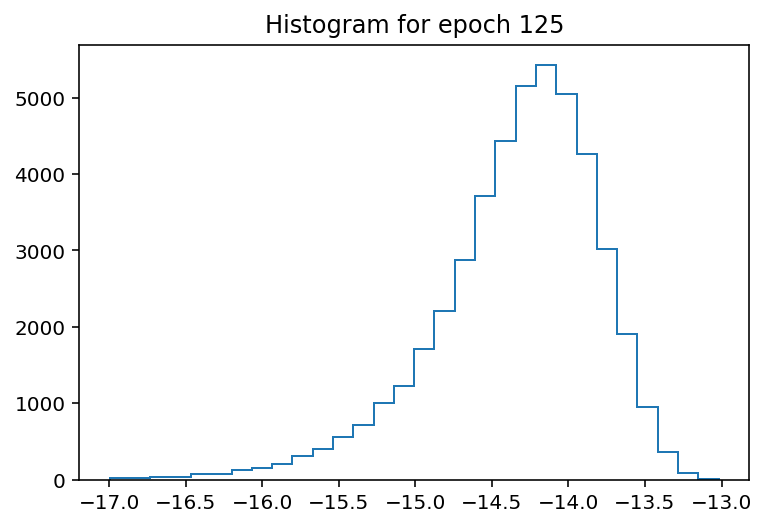

/tmp/ipykernel_21071/992575803.py:16: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


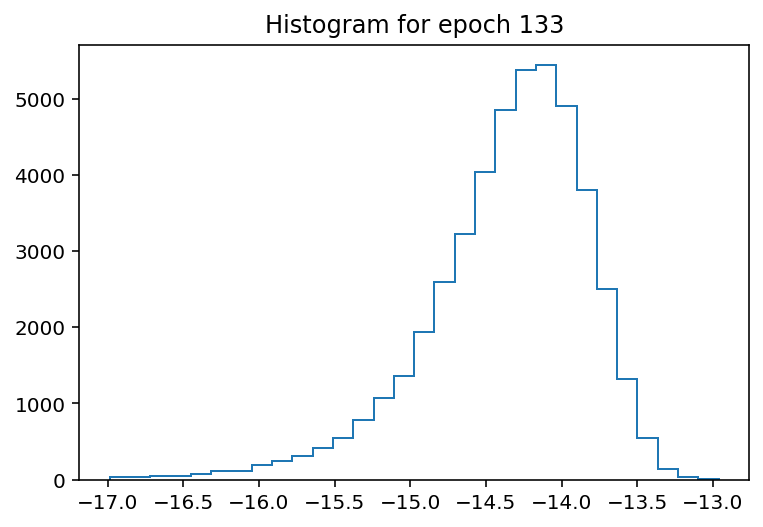

/tmp/ipykernel_21071/992575803.py:16: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


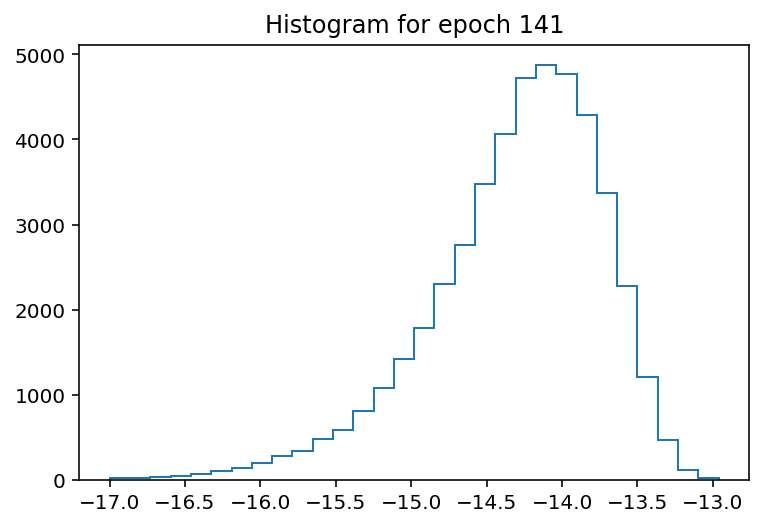

/tmp/ipykernel_21071/992575803.py:16: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


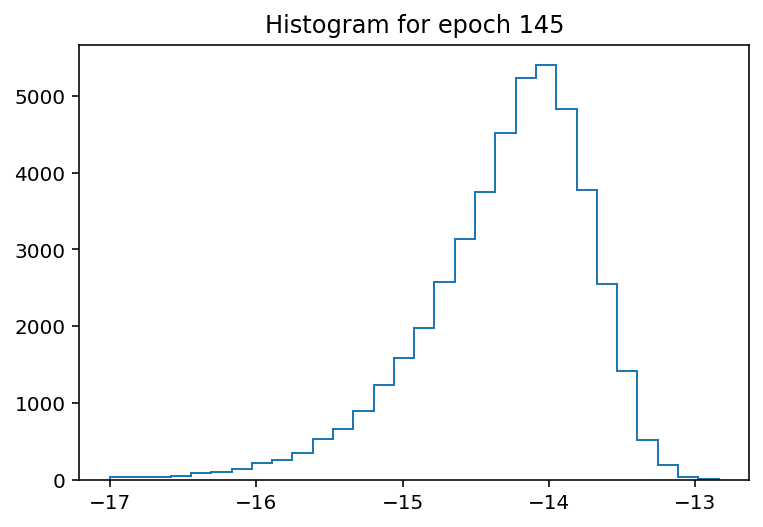

/tmp/ipykernel_21071/992575803.py:16: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


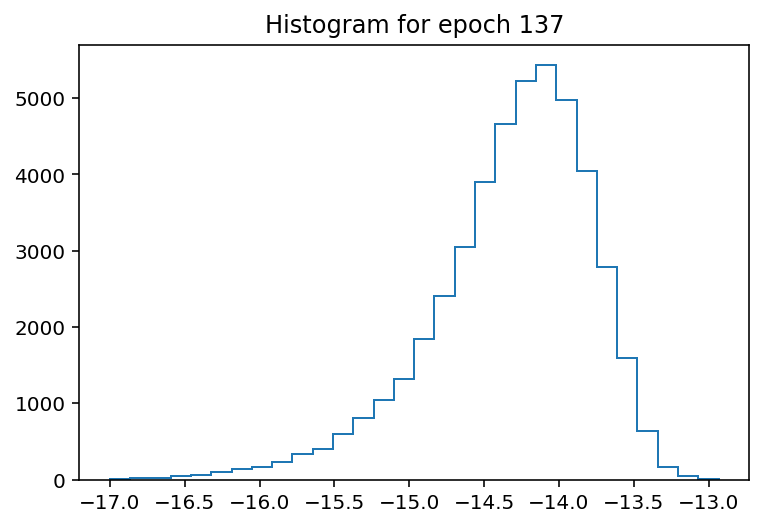

/tmp/ipykernel_21071/992575803.py:16: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


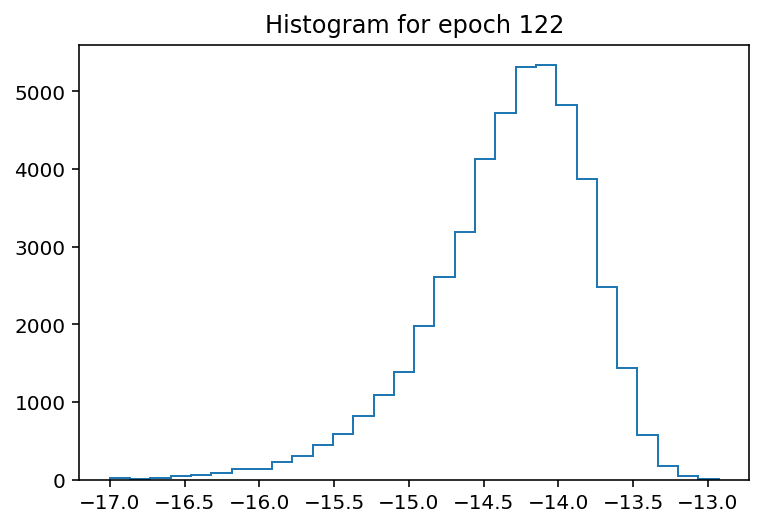

/tmp/ipykernel_21071/992575803.py:16: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


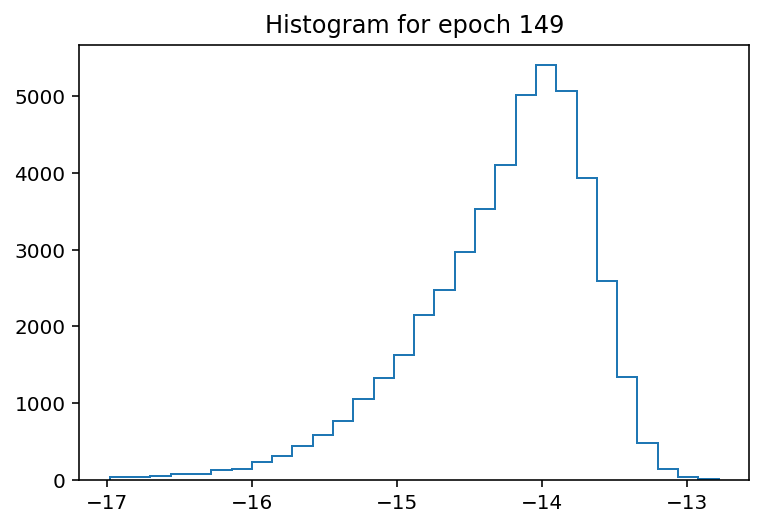

/tmp/ipykernel_21071/992575803.py:16: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


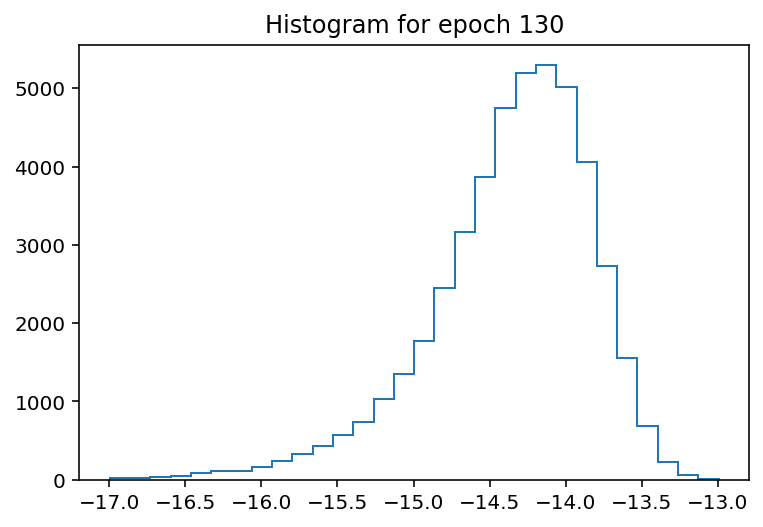

/tmp/ipykernel_21071/992575803.py:16: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


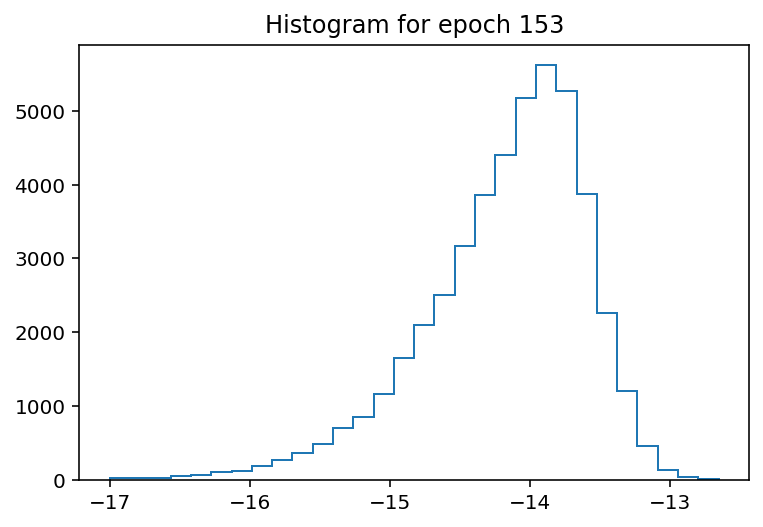

/tmp/ipykernel_21071/992575803.py:16: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


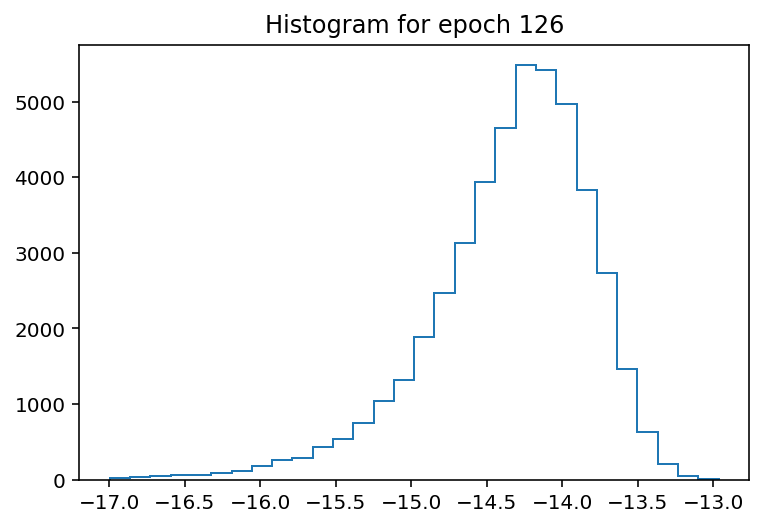

/tmp/ipykernel_21071/992575803.py:16: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


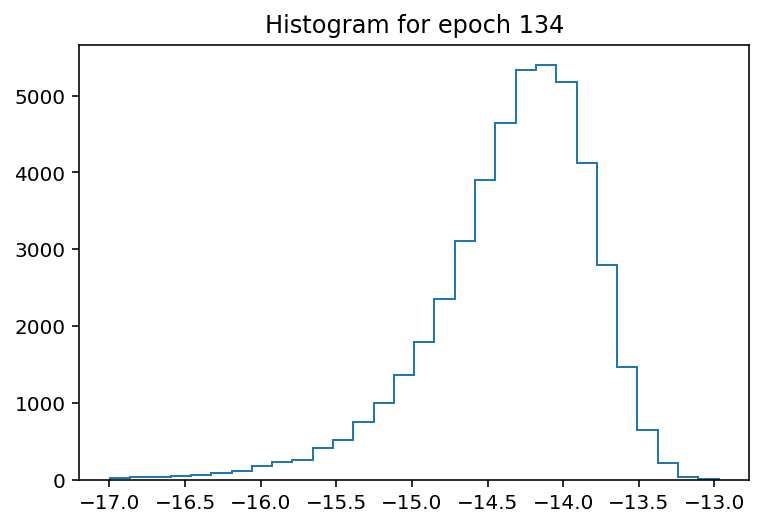

/tmp/ipykernel_21071/992575803.py:16: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


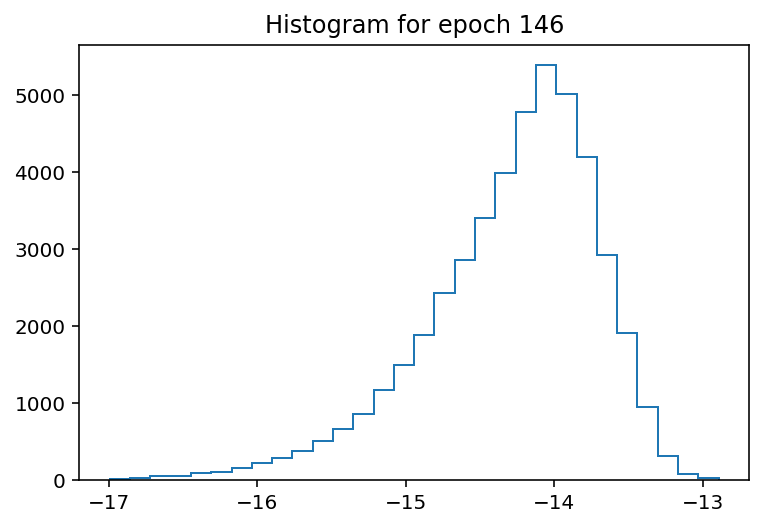

/tmp/ipykernel_21071/992575803.py:16: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


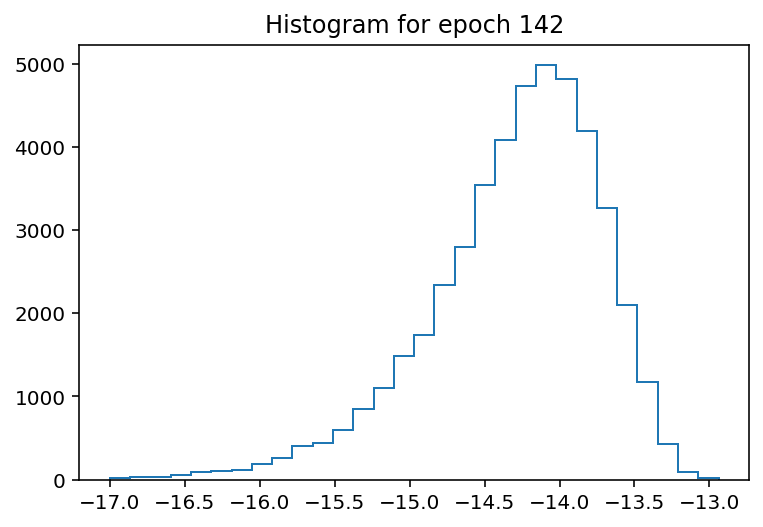

/tmp/ipykernel_21071/992575803.py:16: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


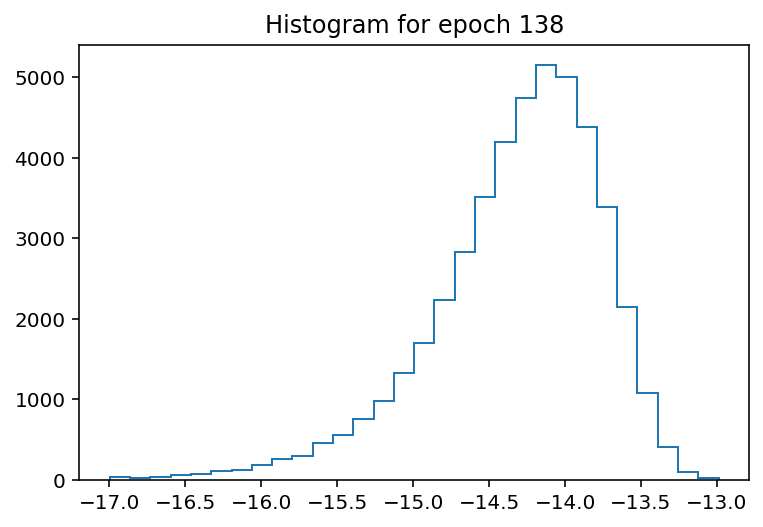

/tmp/ipykernel_21071/992575803.py:16: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


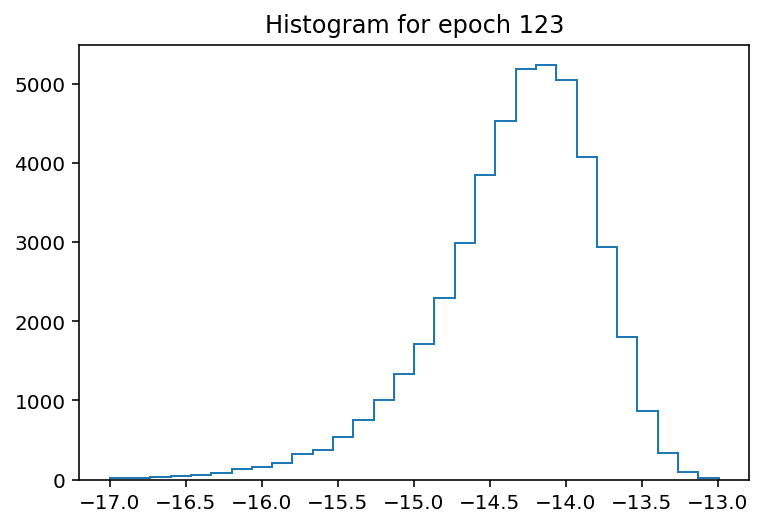

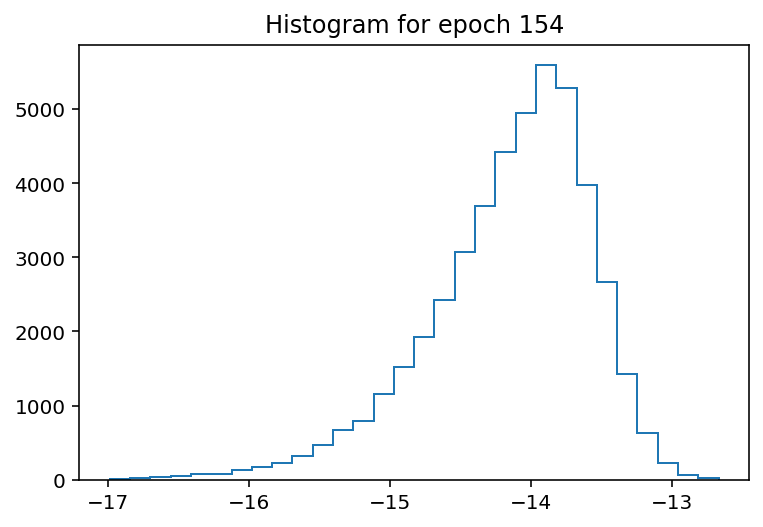

/tmp/ipykernel_21071/992575803.py:16: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


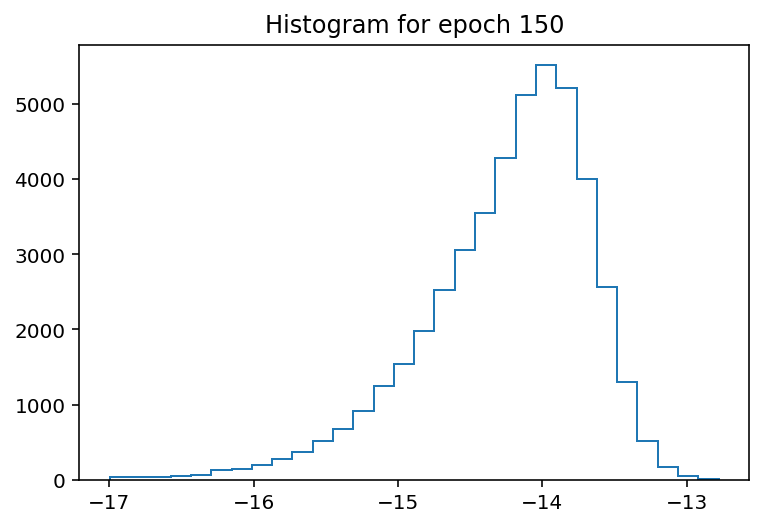

/tmp/ipykernel_21071/992575803.py:16: RuntimeWarning: divide by zero encountered in log
  logweights[amp_idx] = np.log(like) + epoch_max


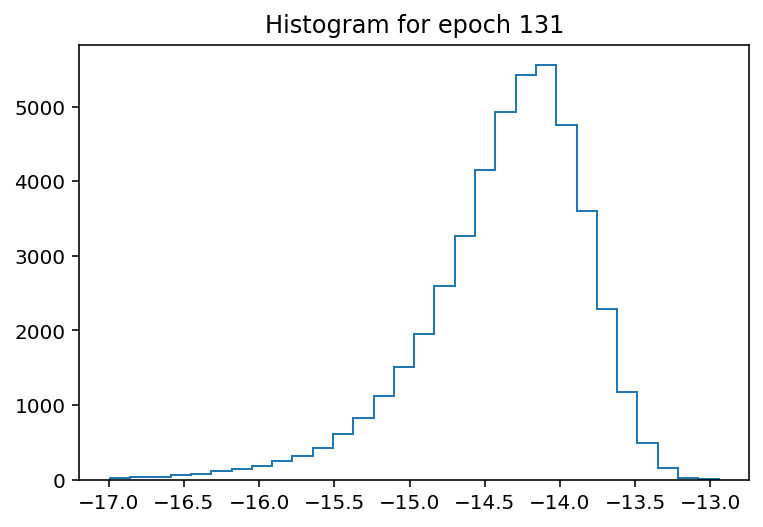

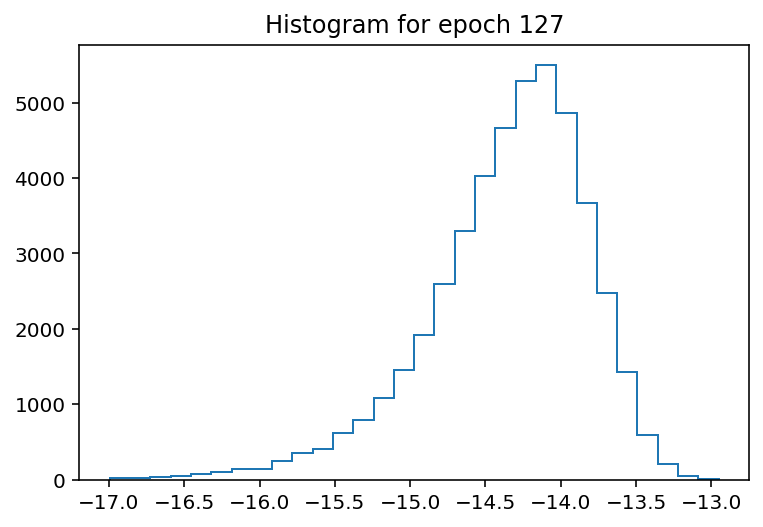

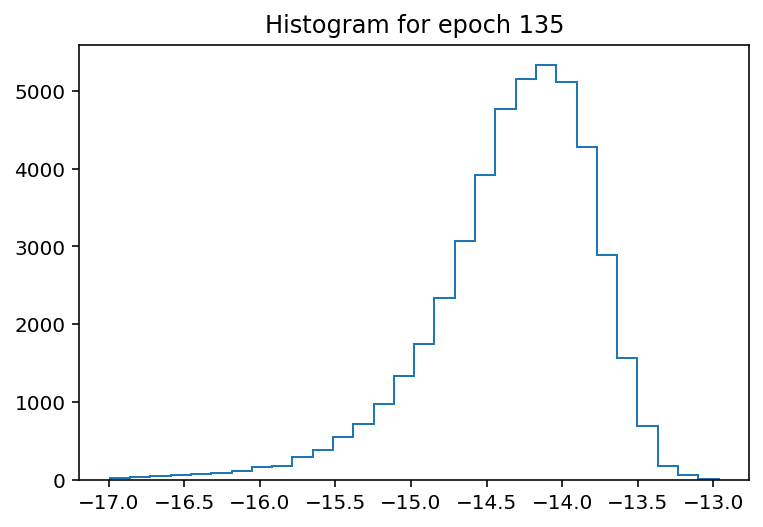

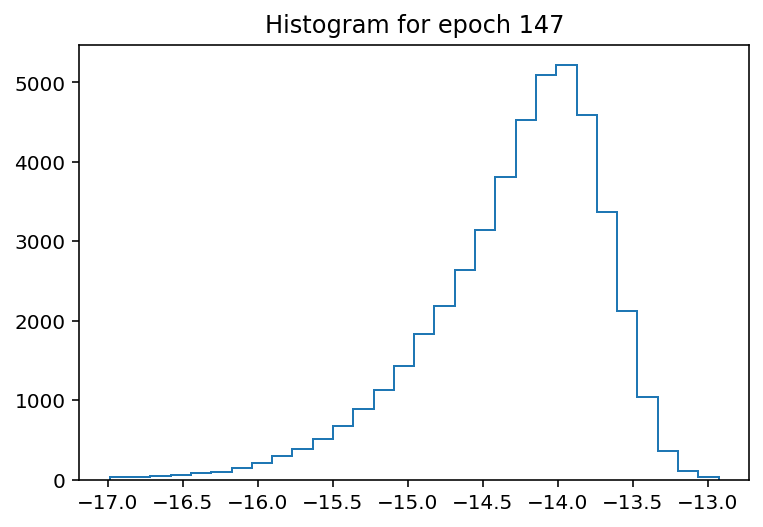

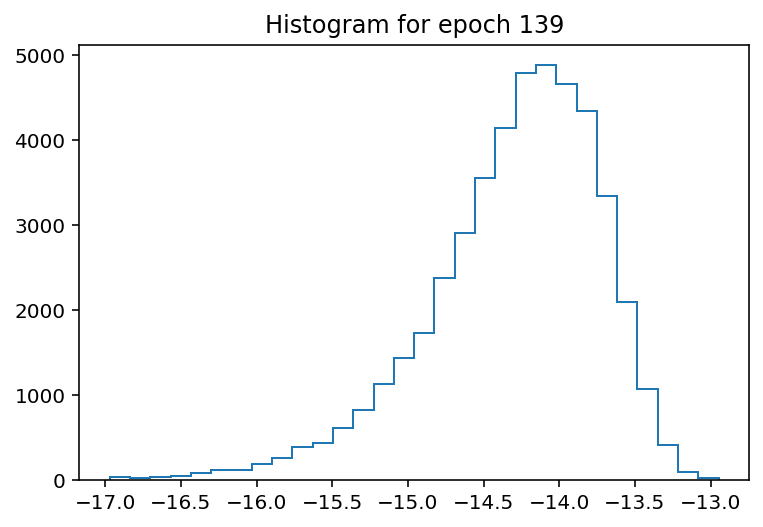

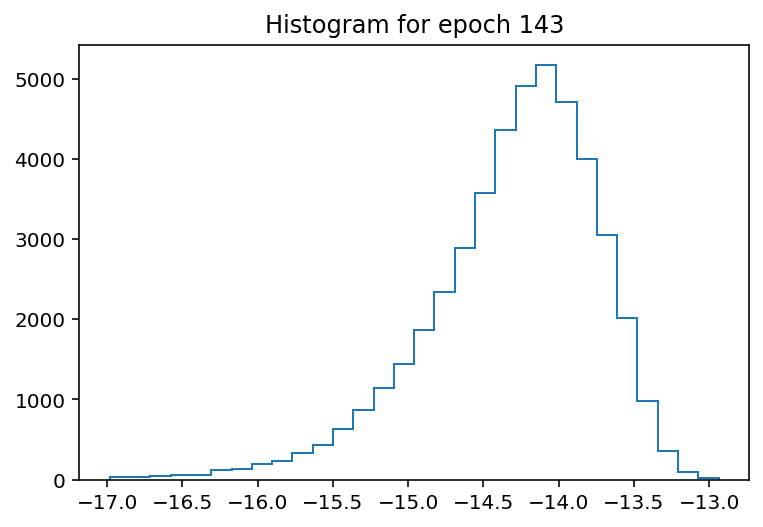

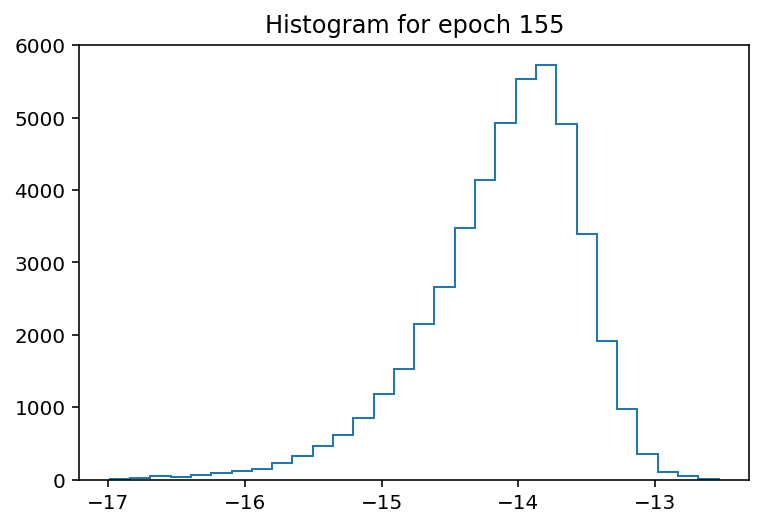

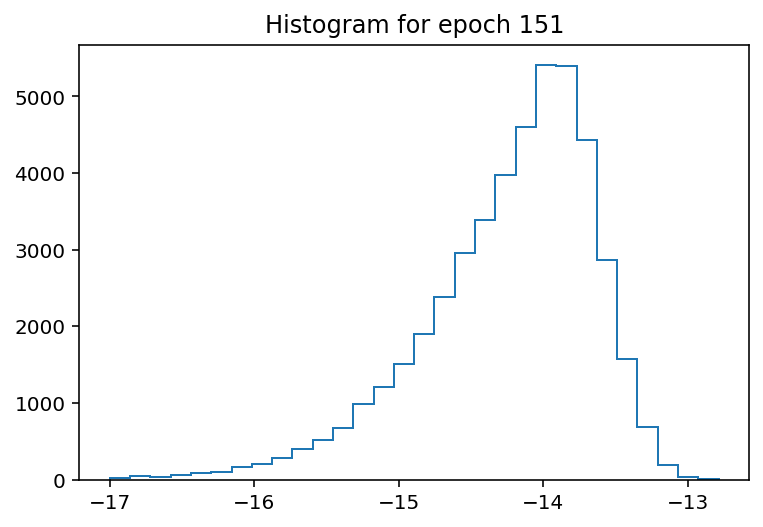

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [17]:
pool=mp.Pool(processes=10)
pool.map(epoch_sample_worker, np.arange(len(nano12_Ts)))

In [19]:
nano11_histdir = '/home/nima/nanograv/11yr_factlike/ULvT_charts_ignore_epoch/epoch_samples/'
old_ULvT = np.zeros(len(nano11_Ts))

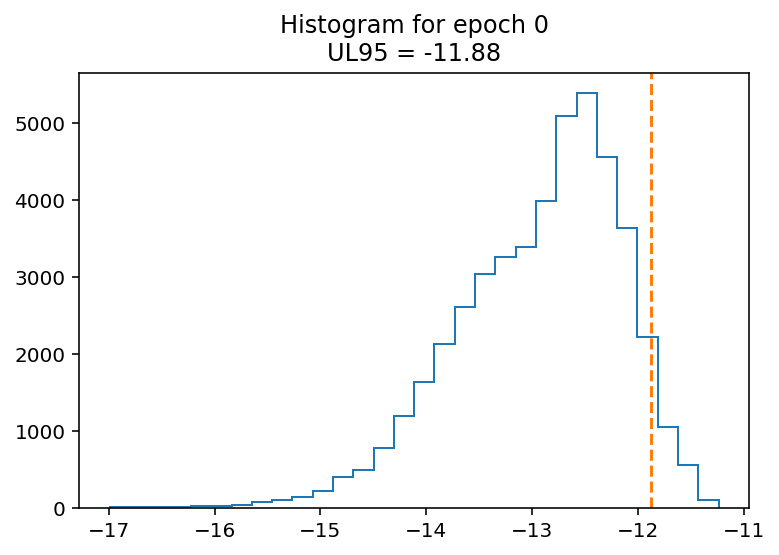

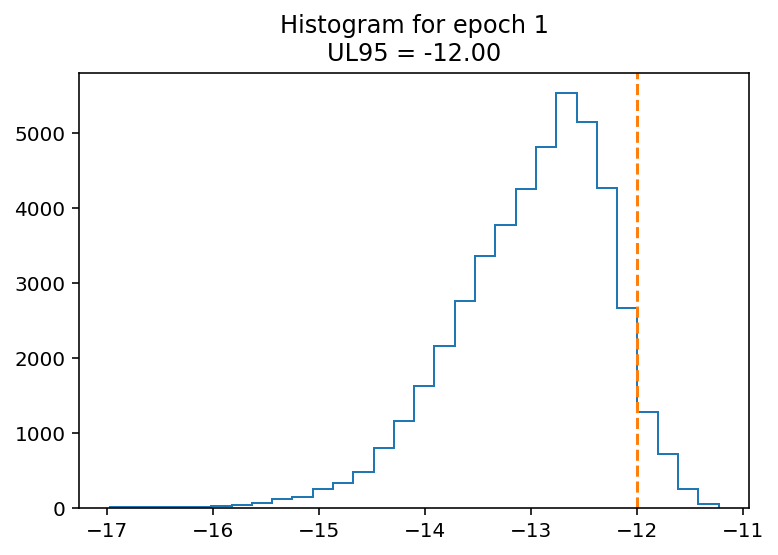

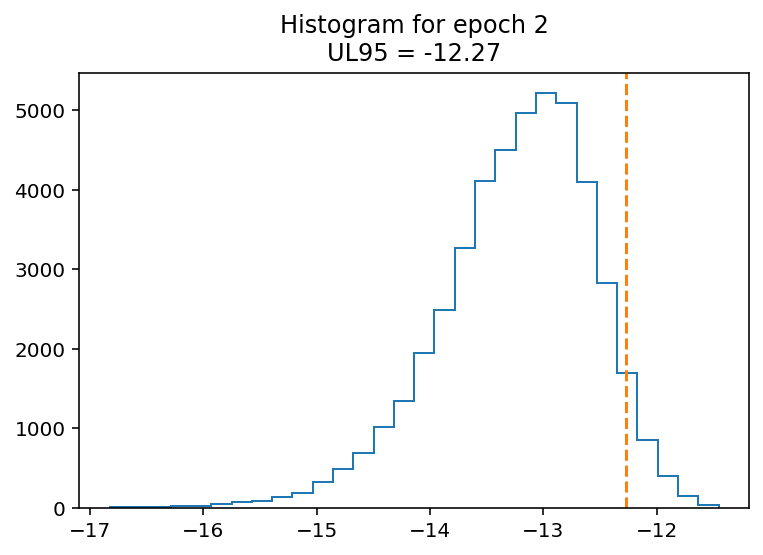

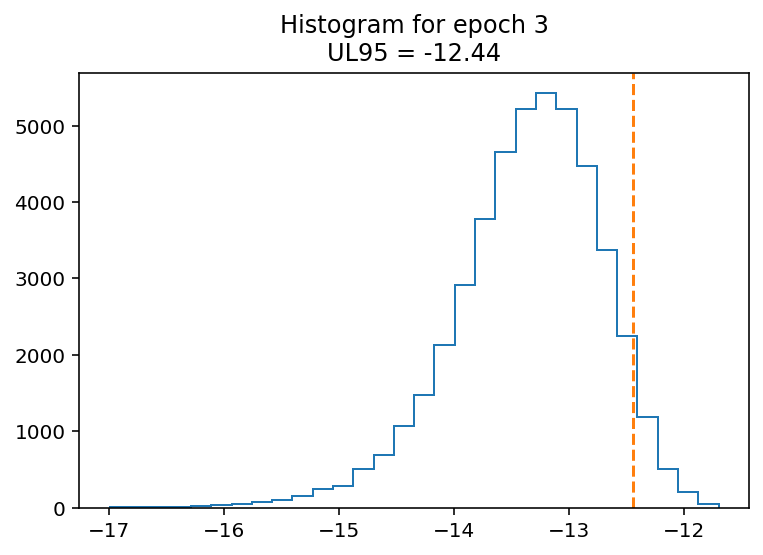

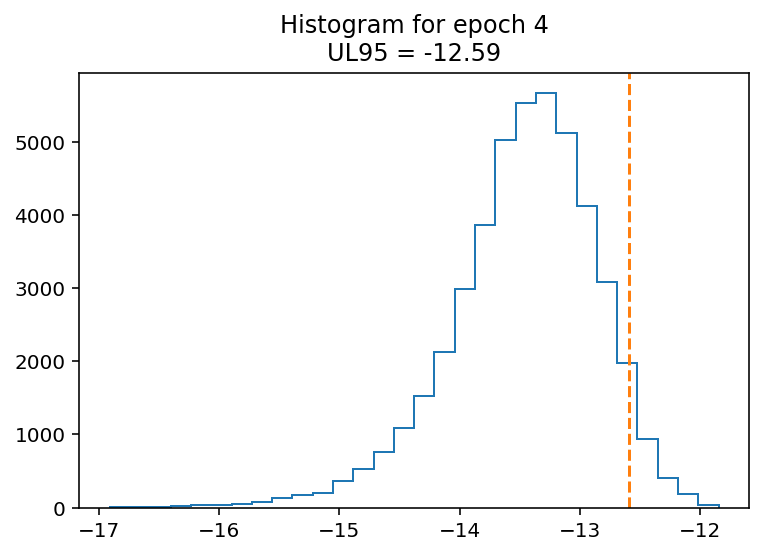

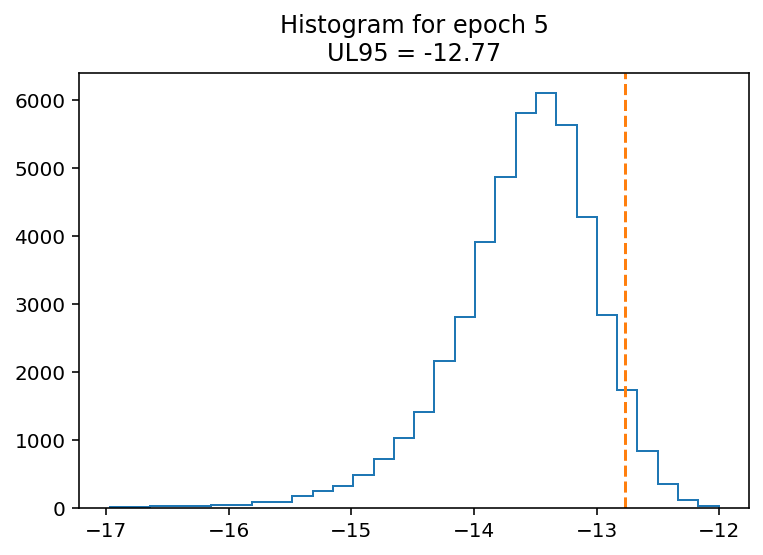

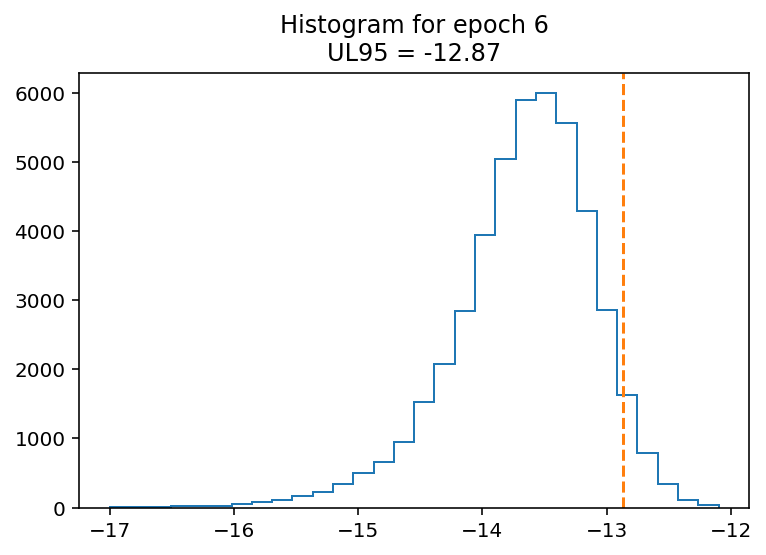

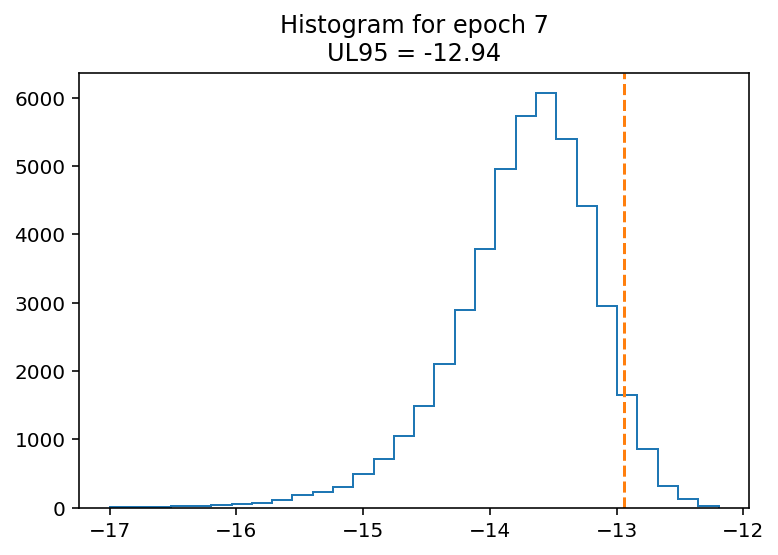

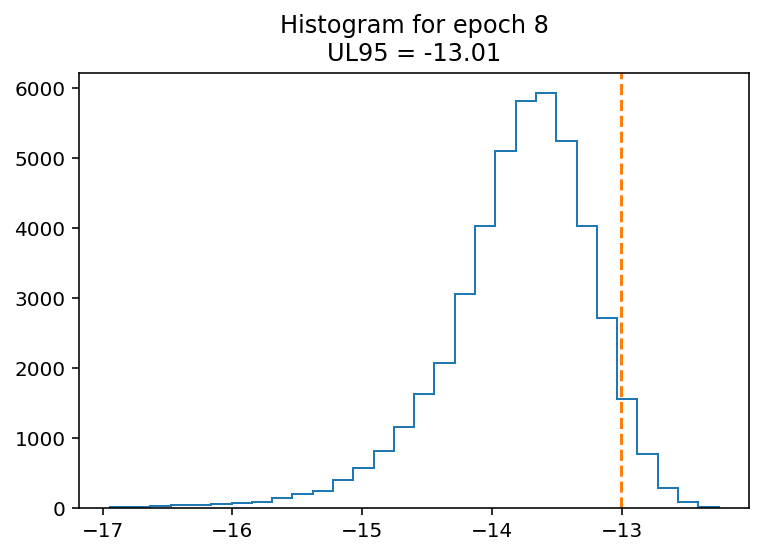

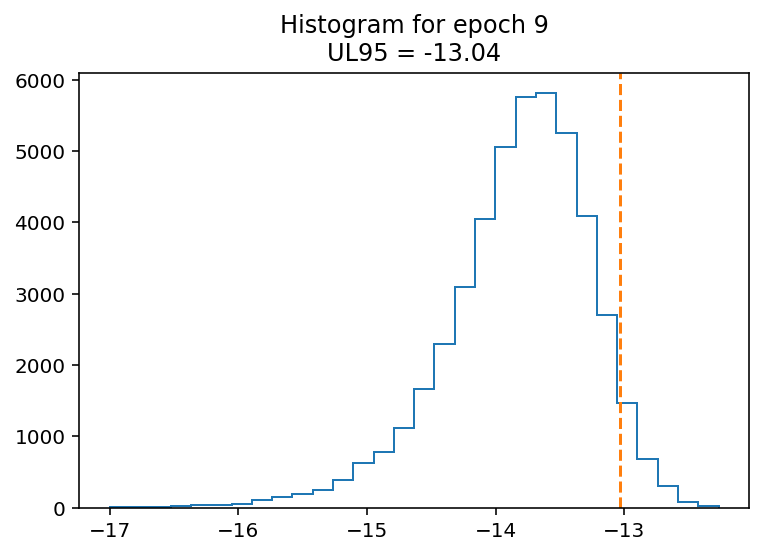

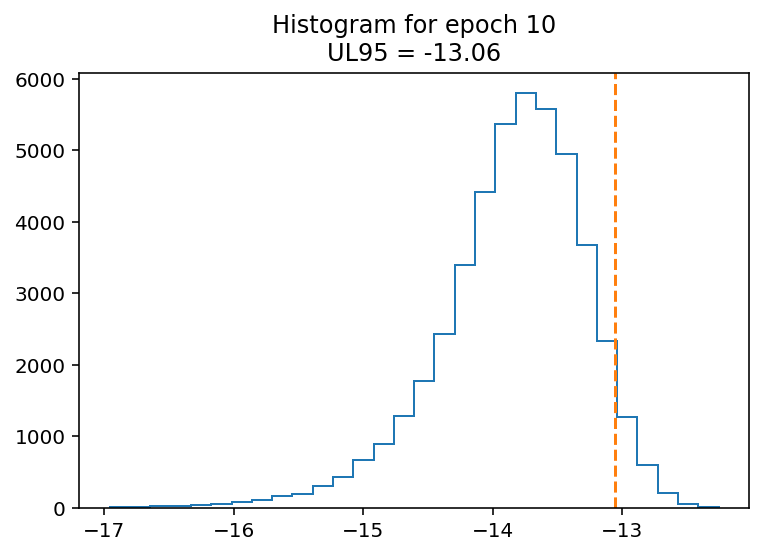

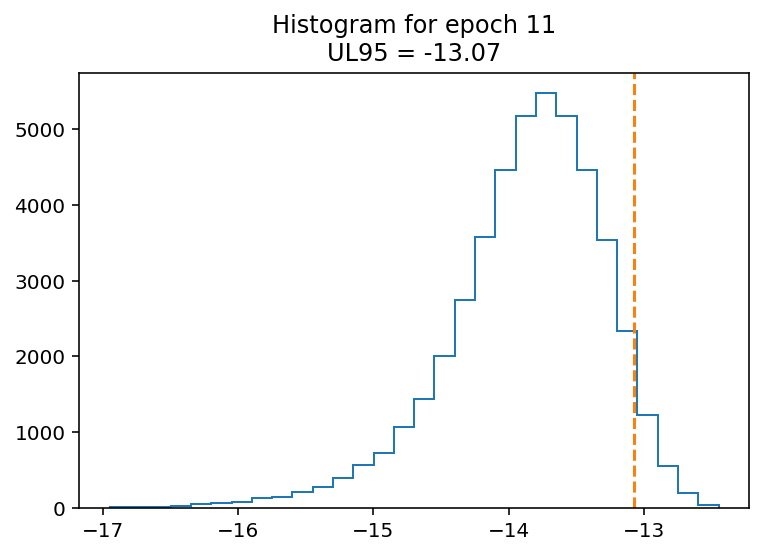

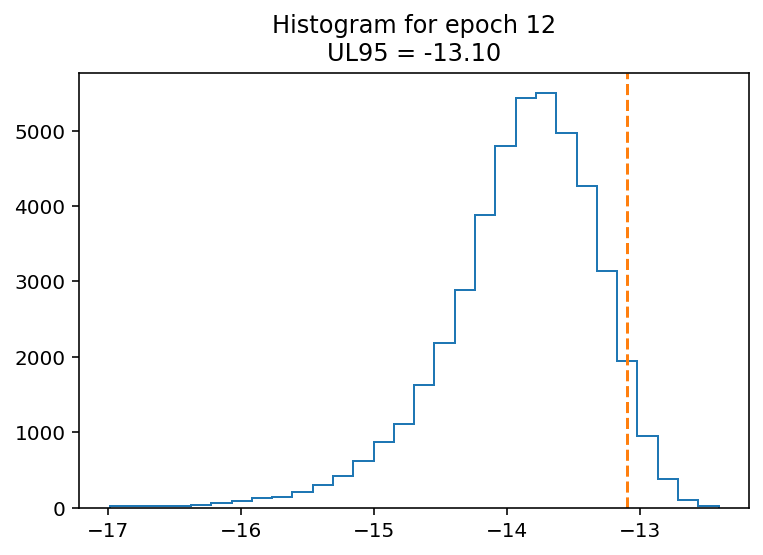

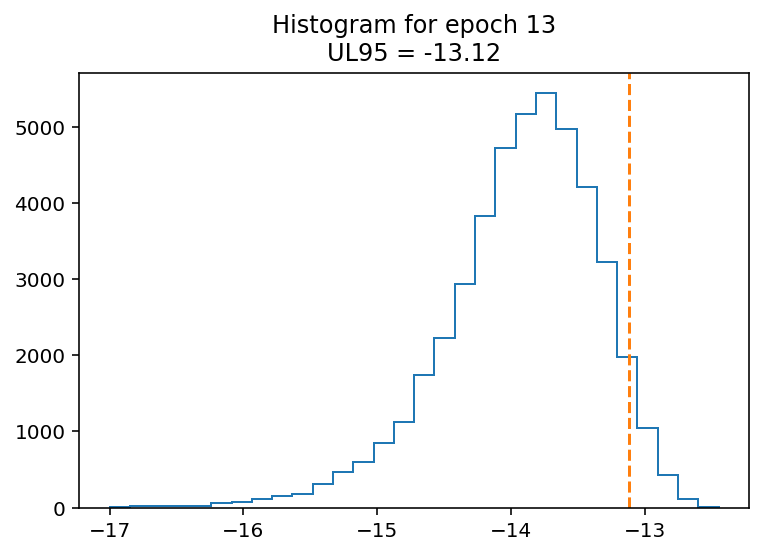

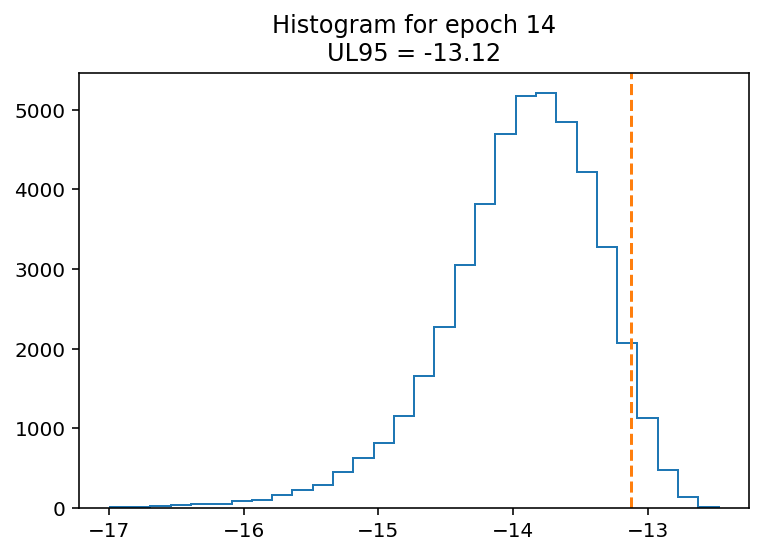

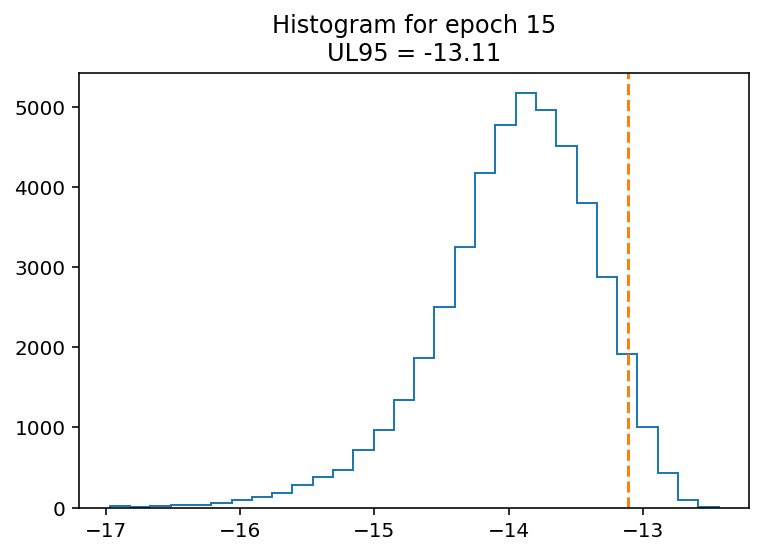

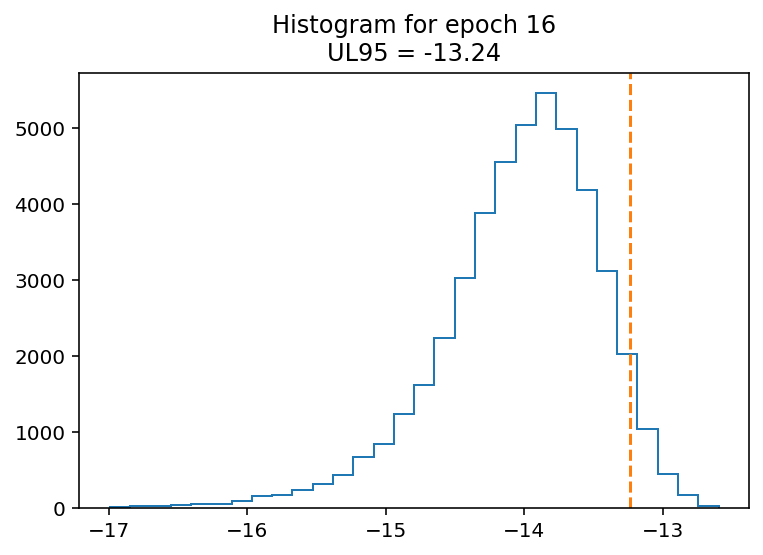

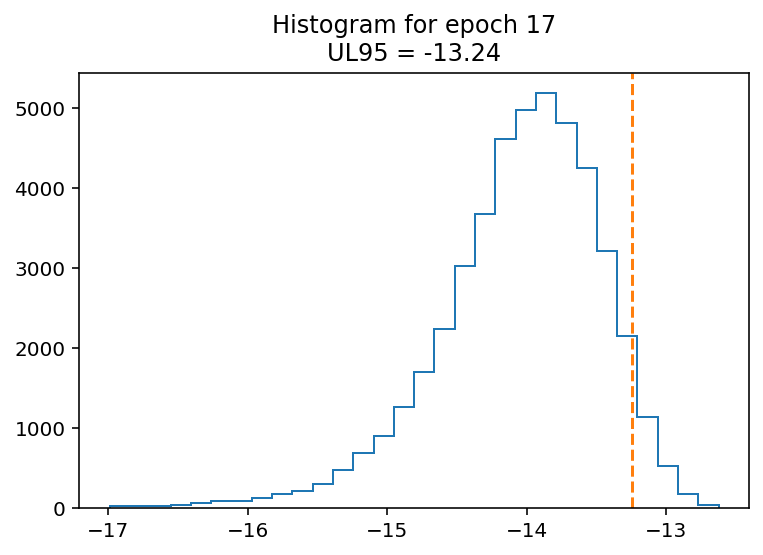

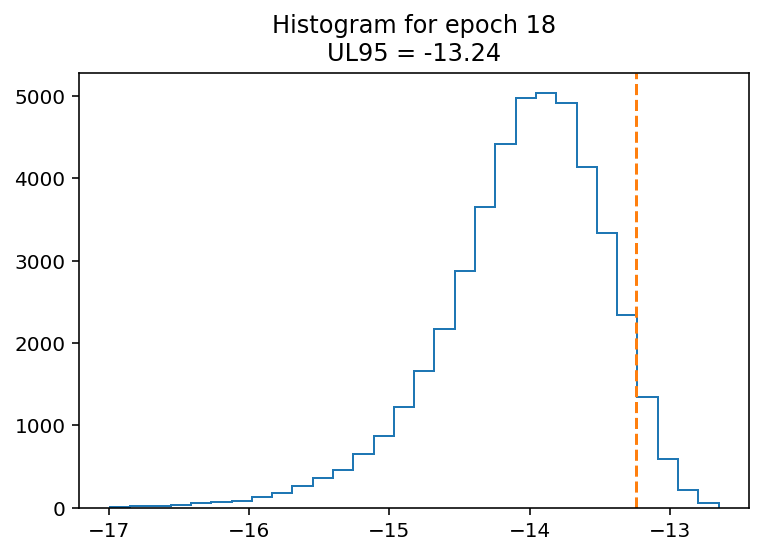

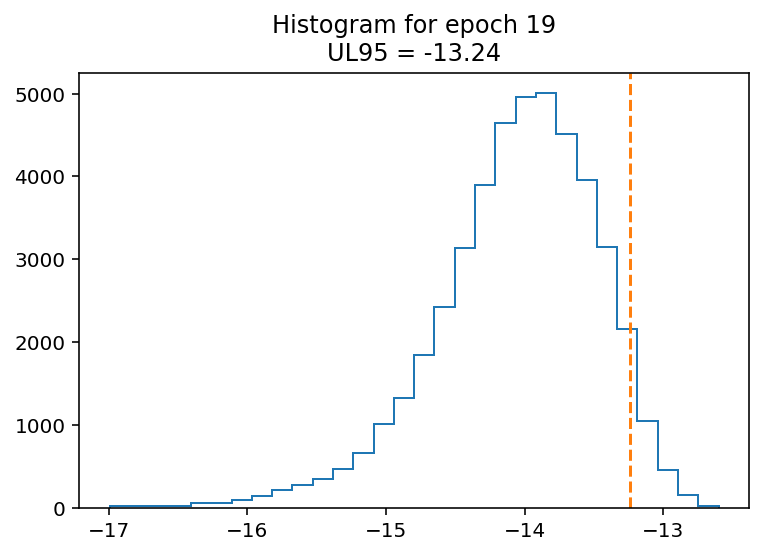

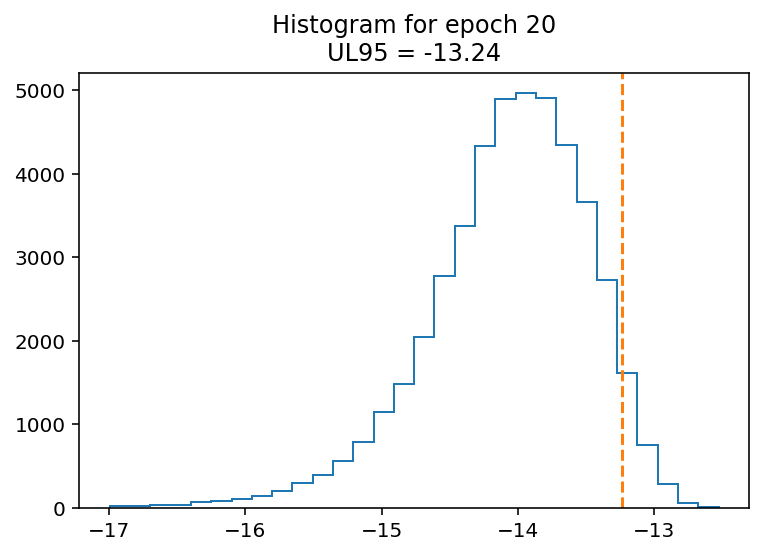

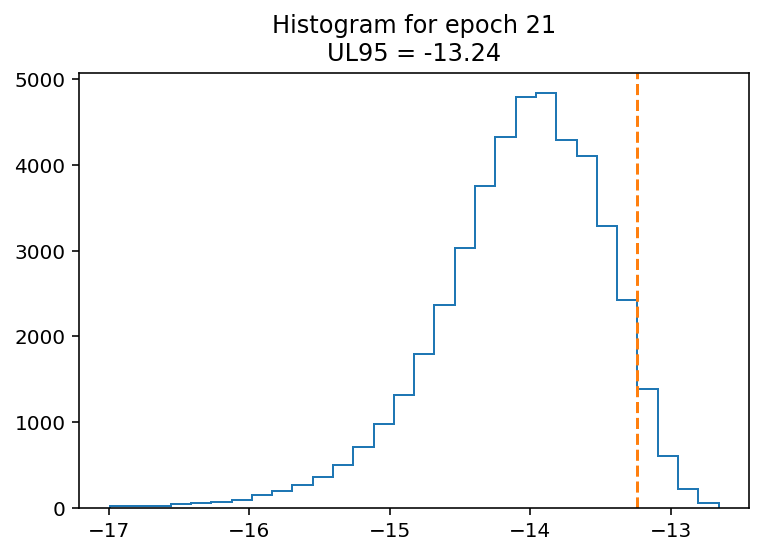

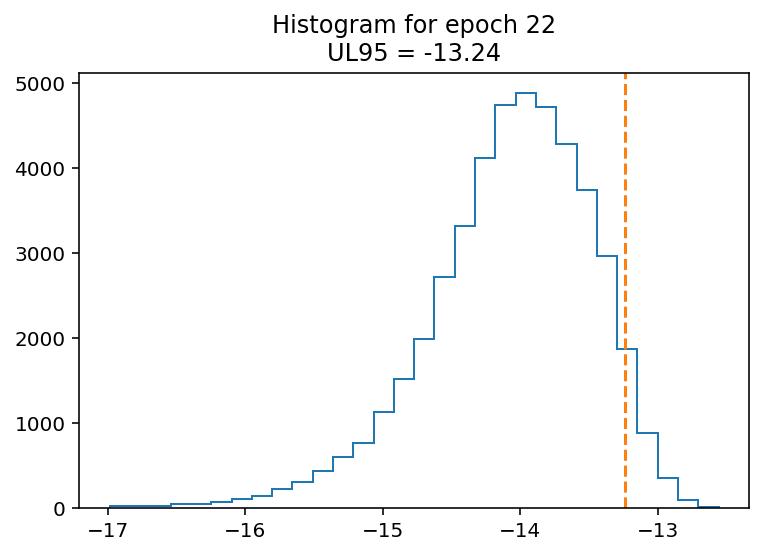

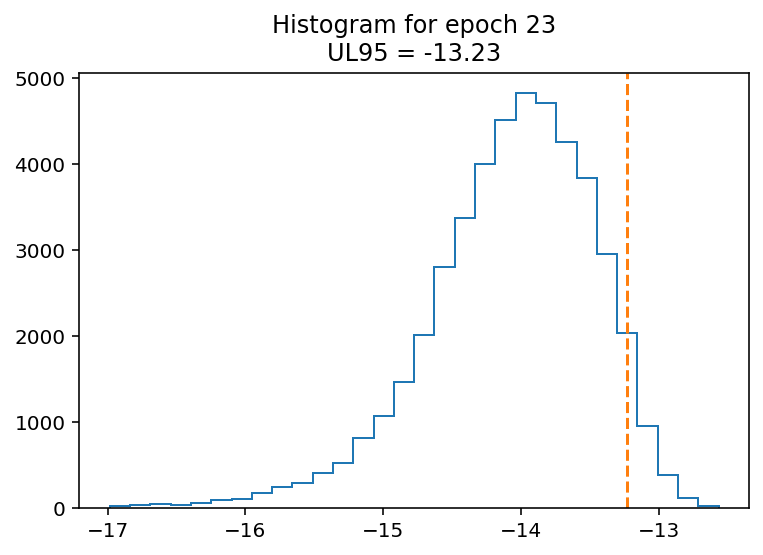

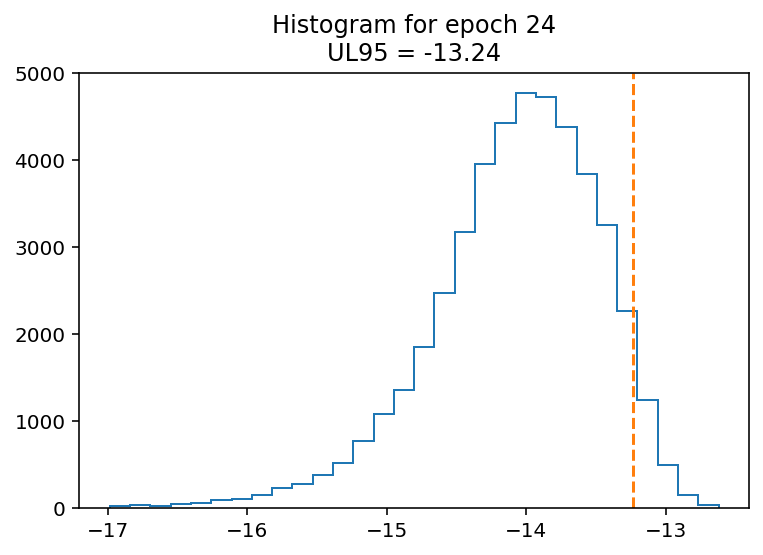

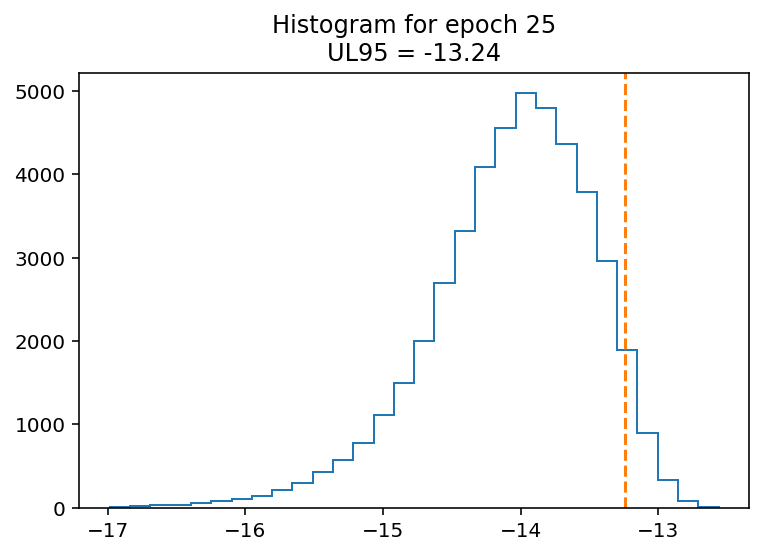

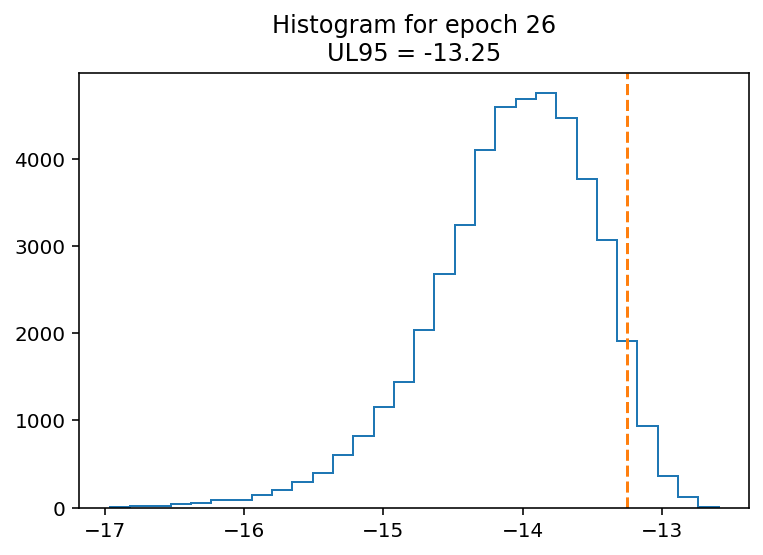

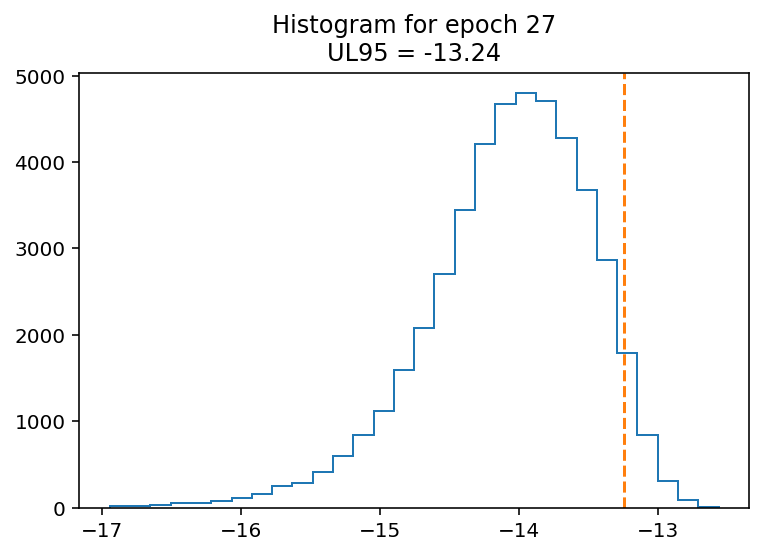

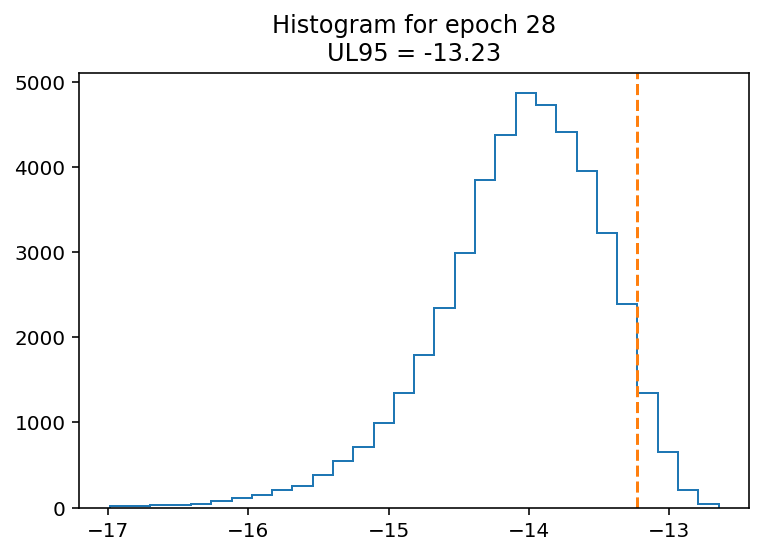

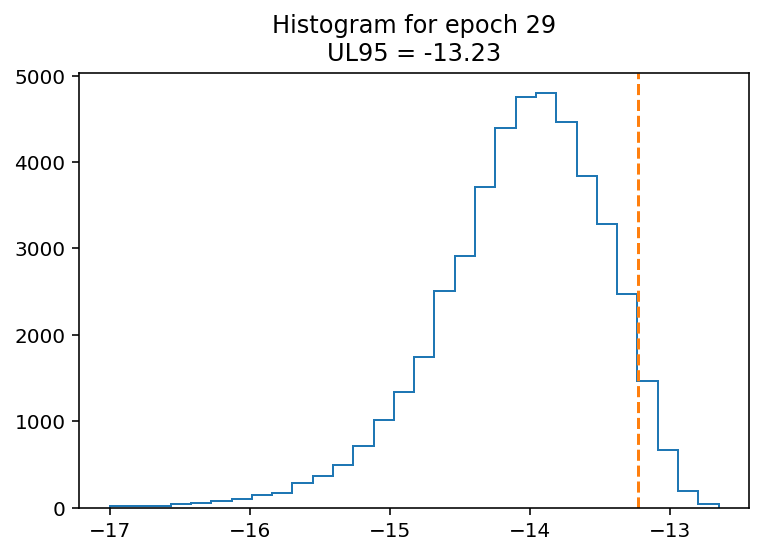

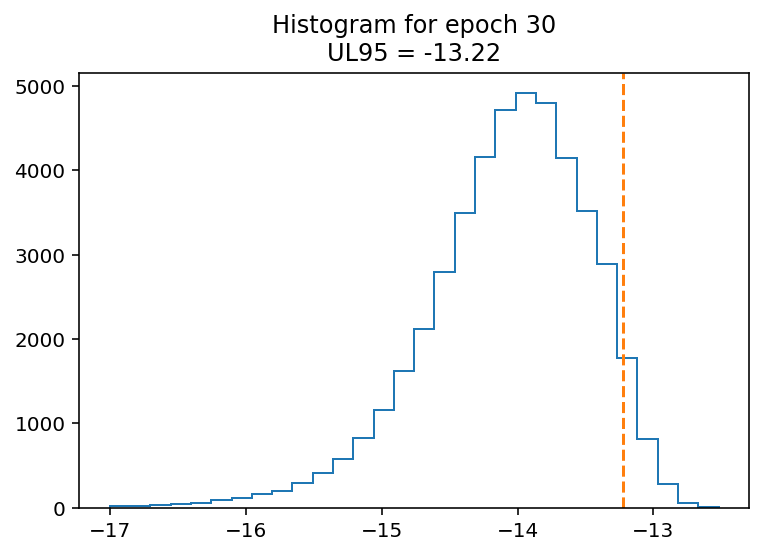

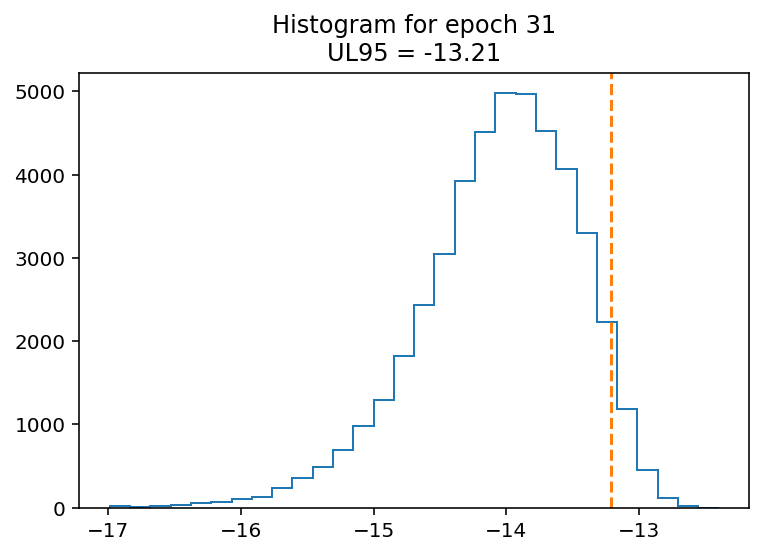

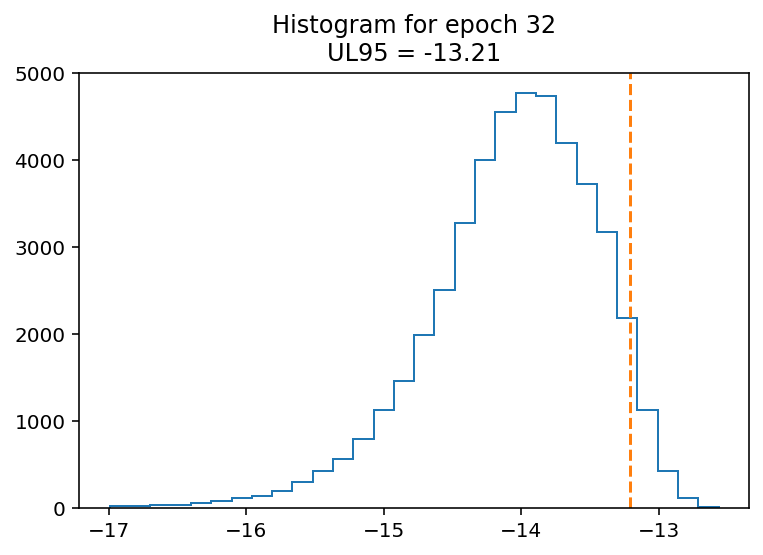

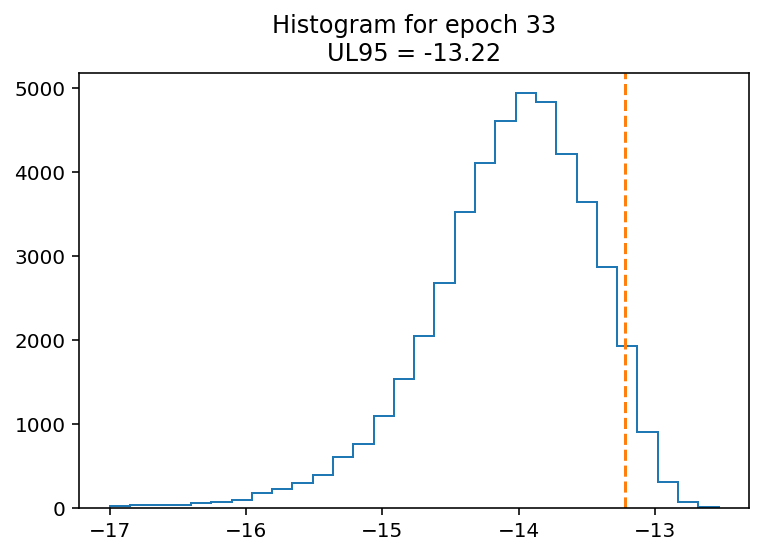

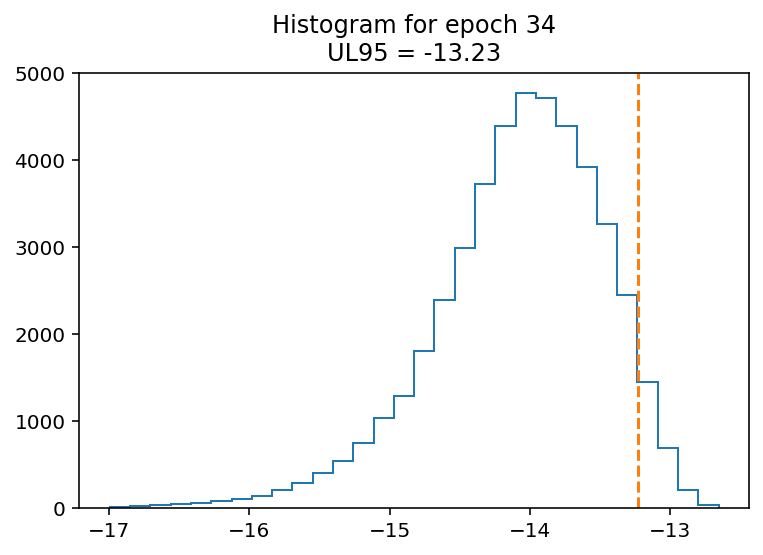

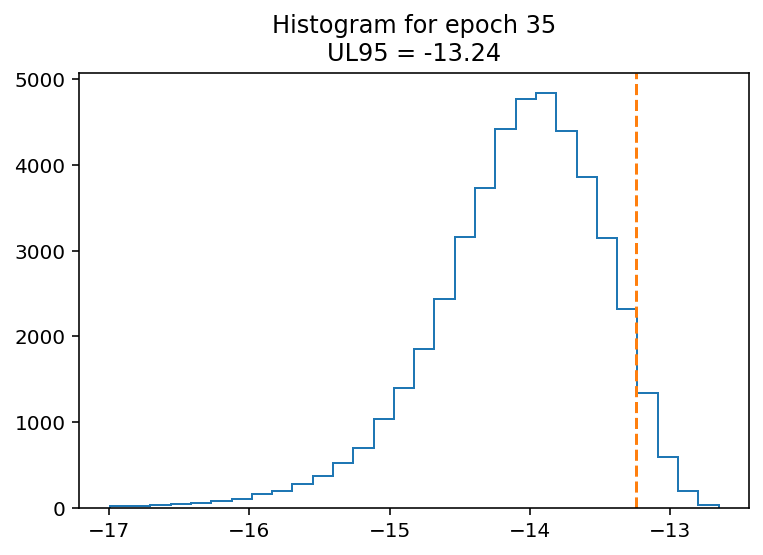

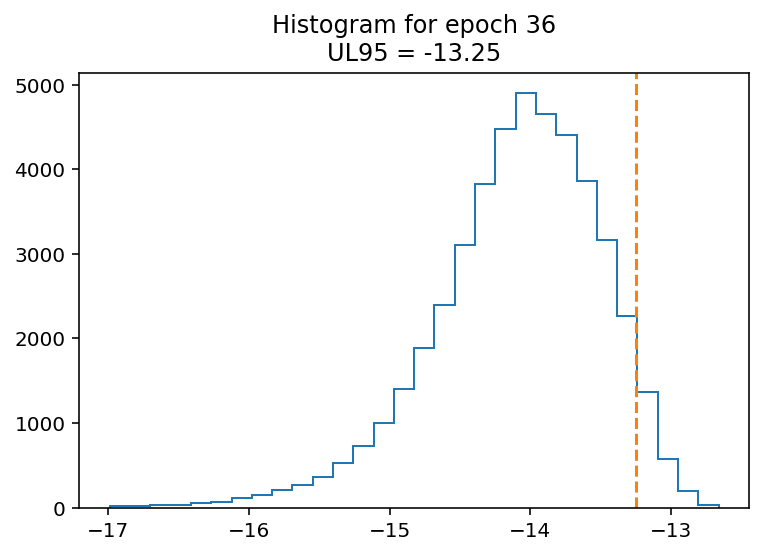

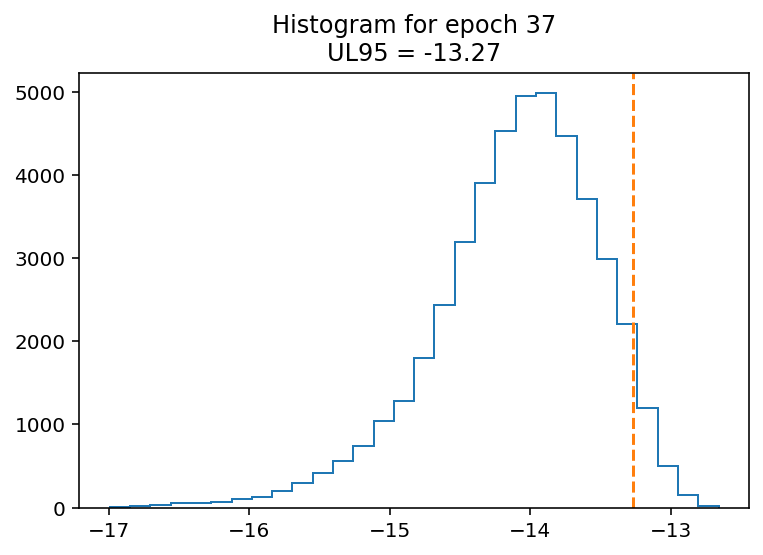

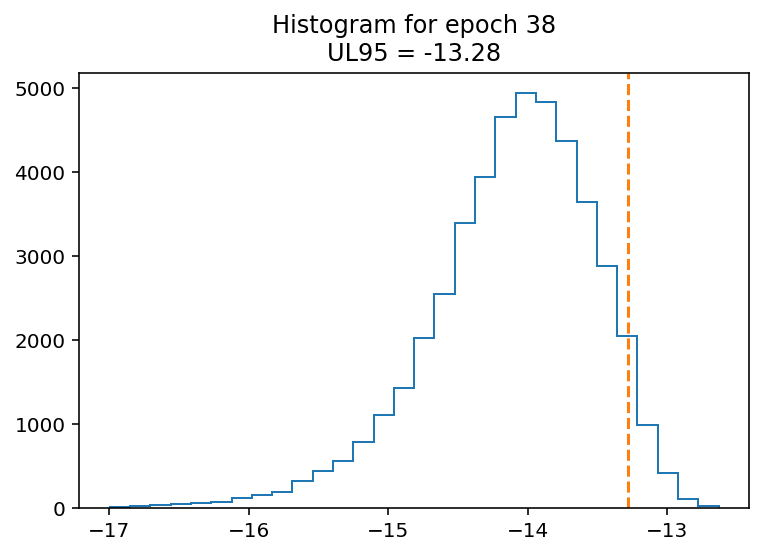

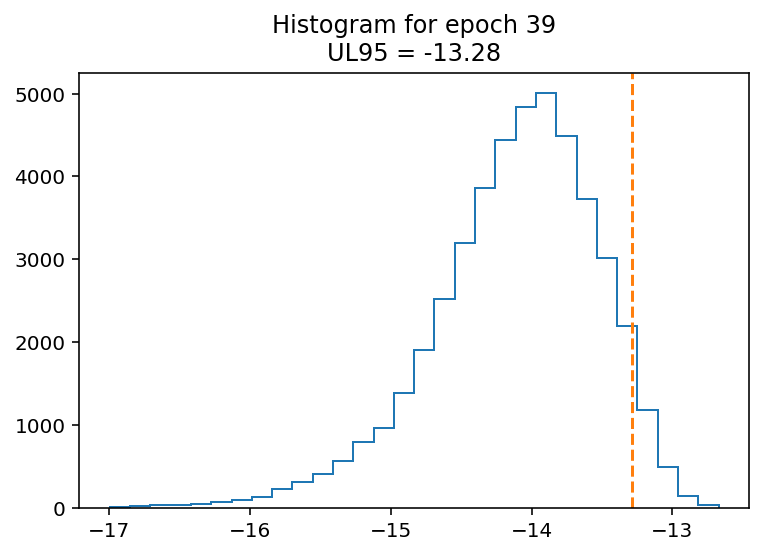

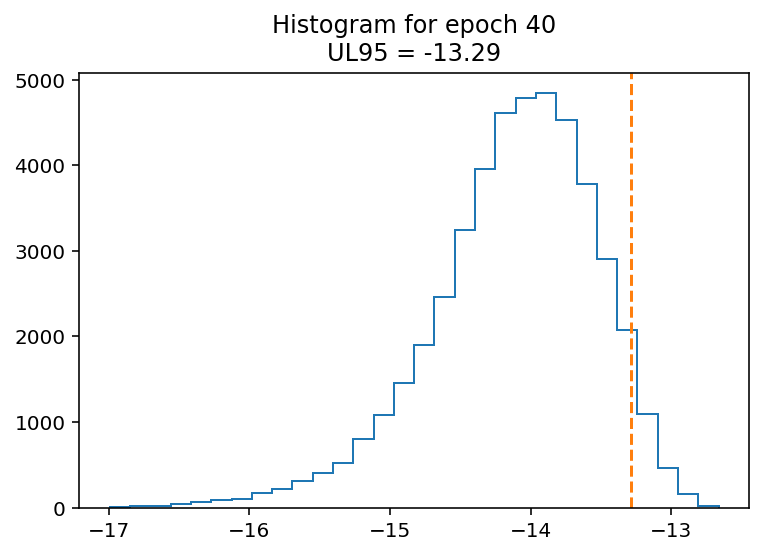

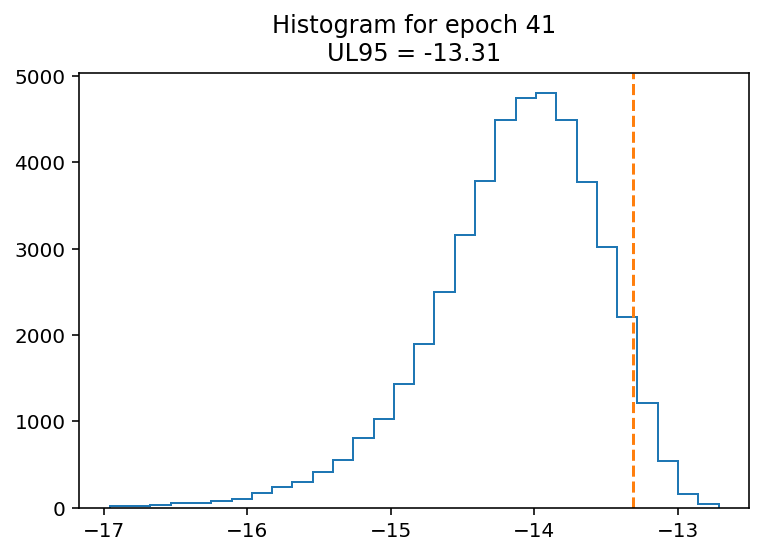

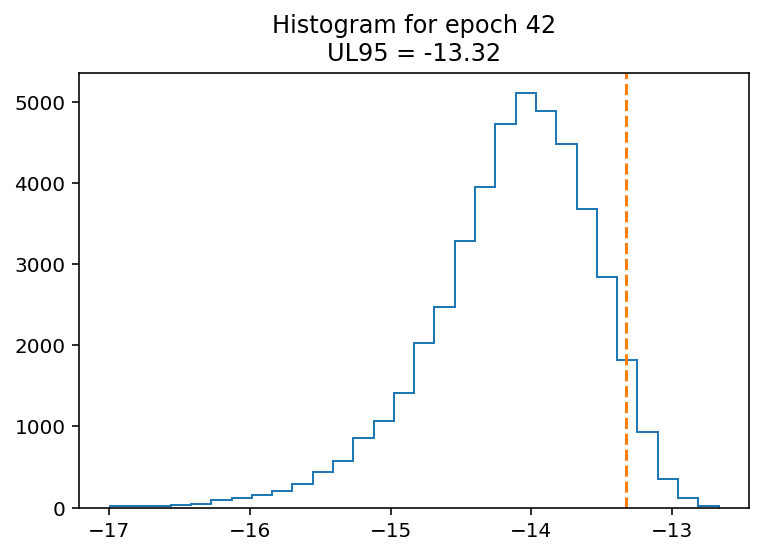

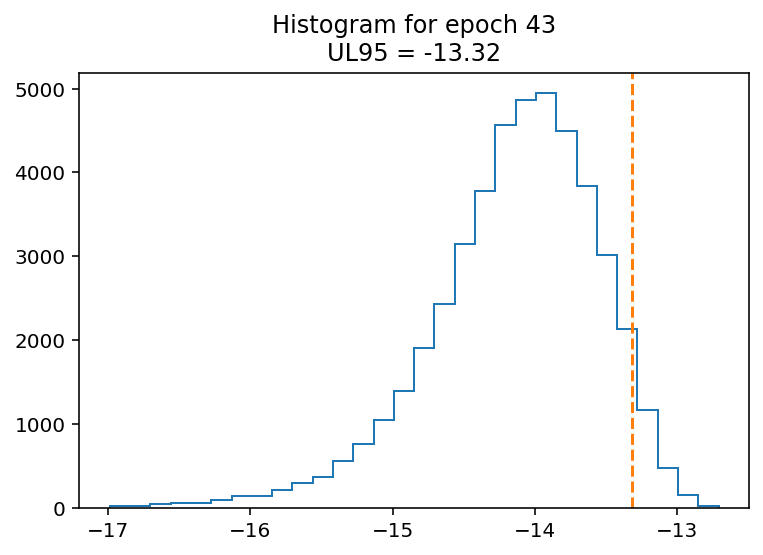

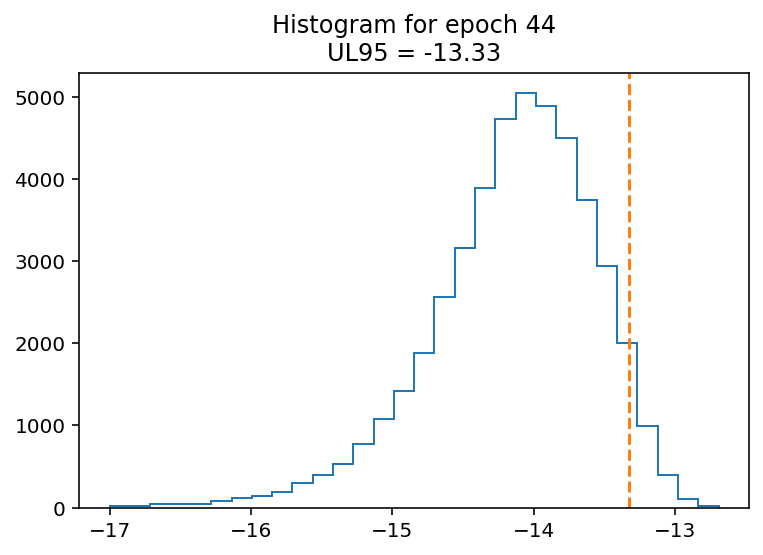

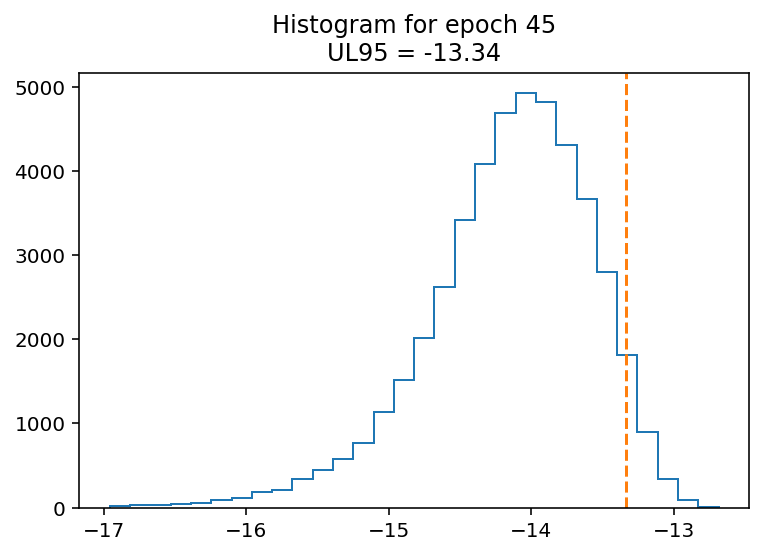

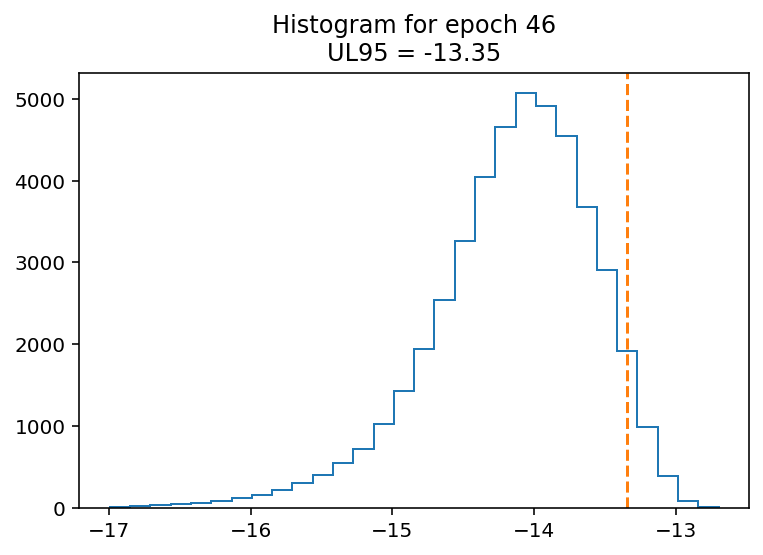

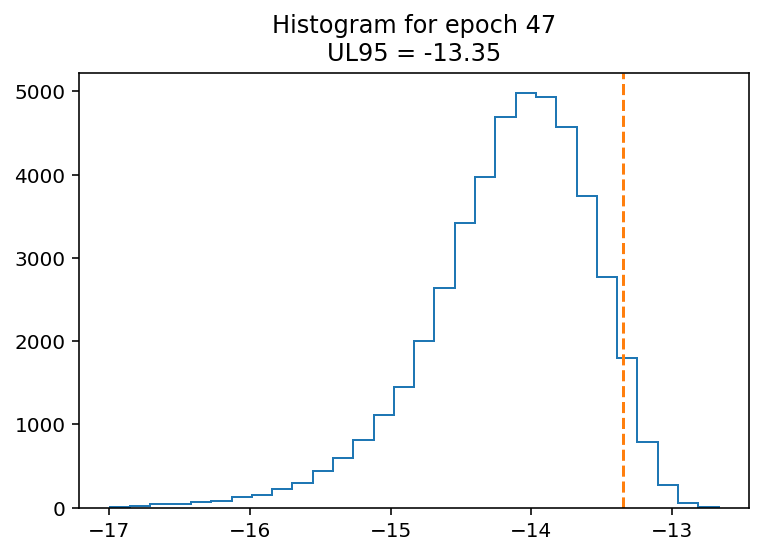

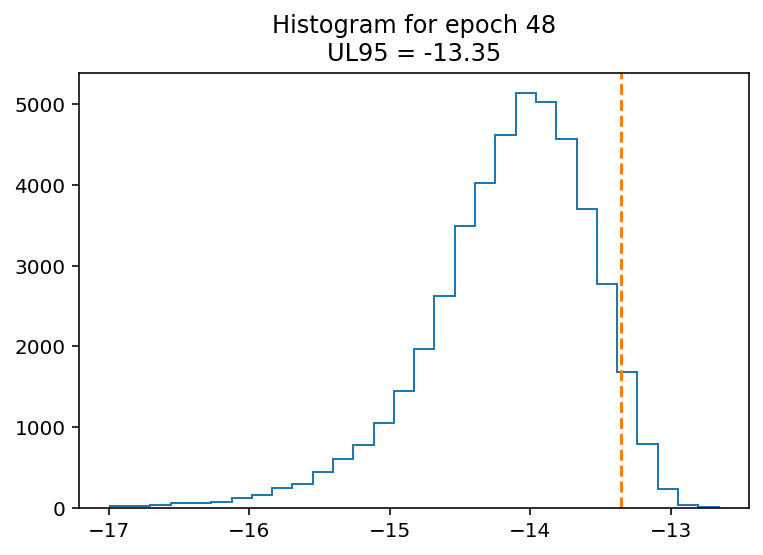

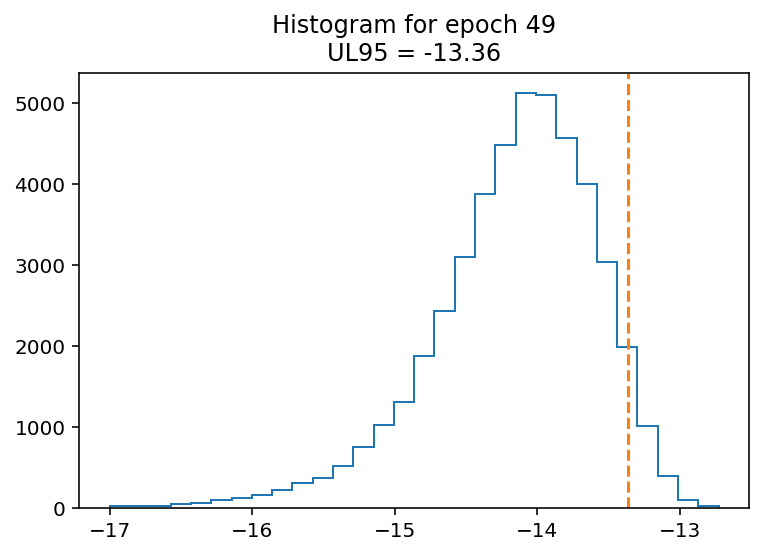

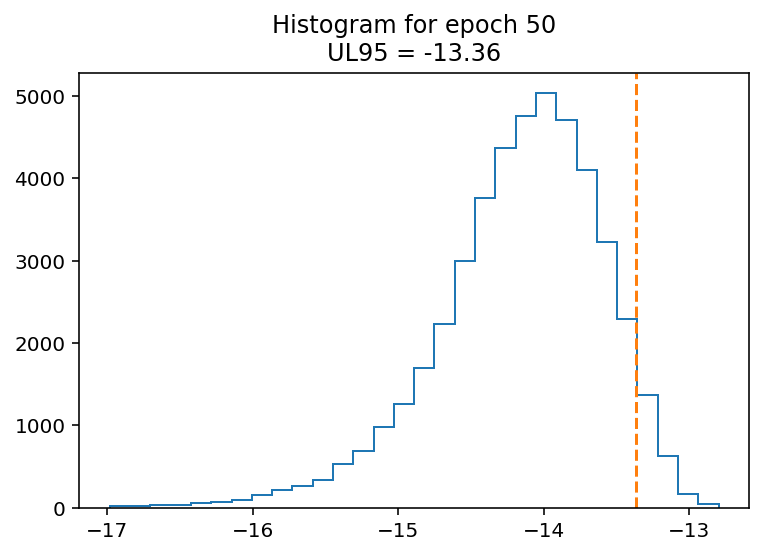

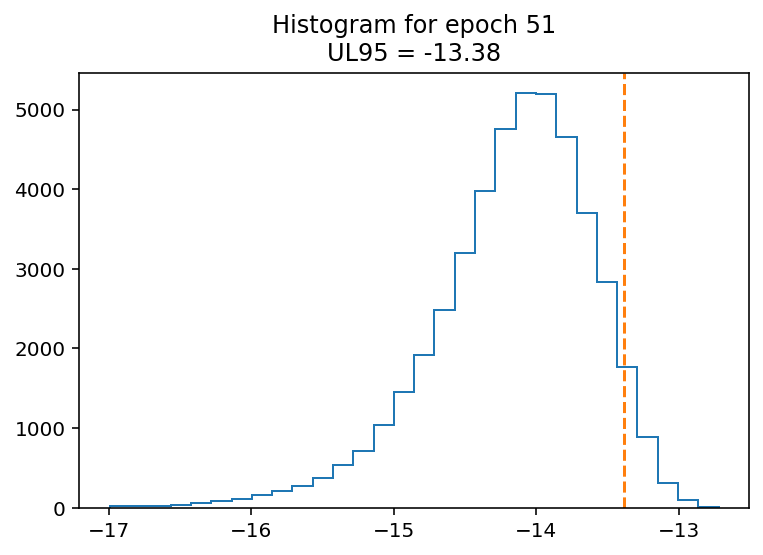

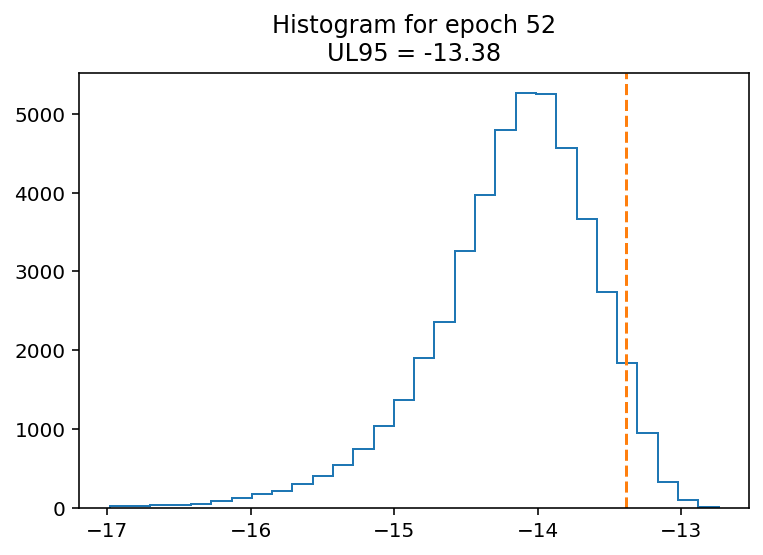

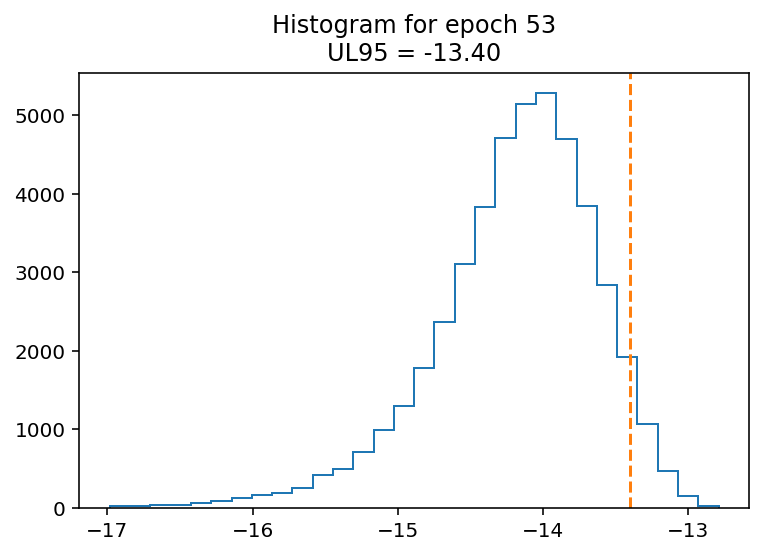

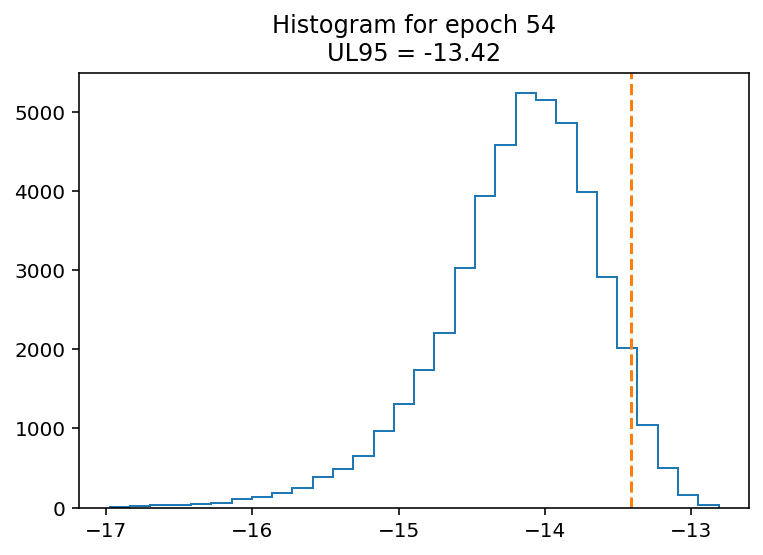

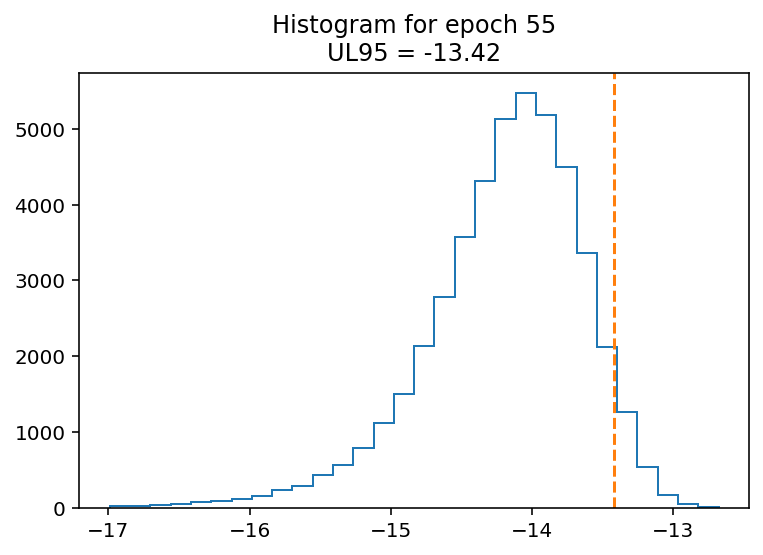

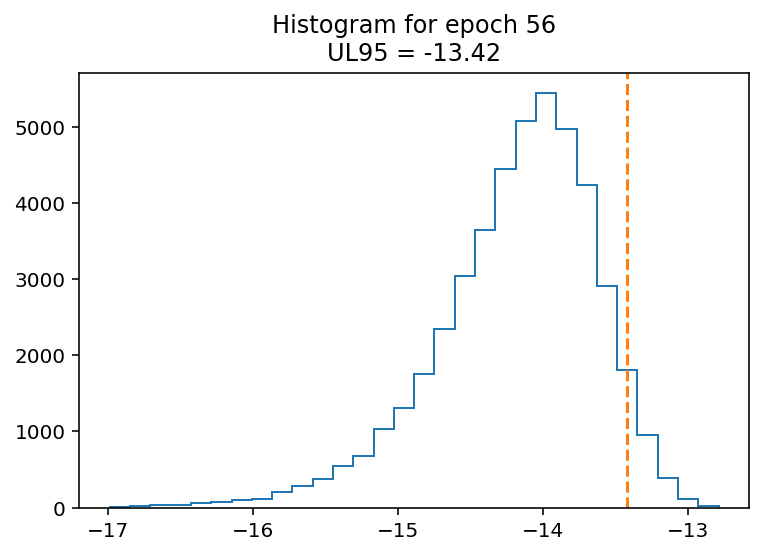

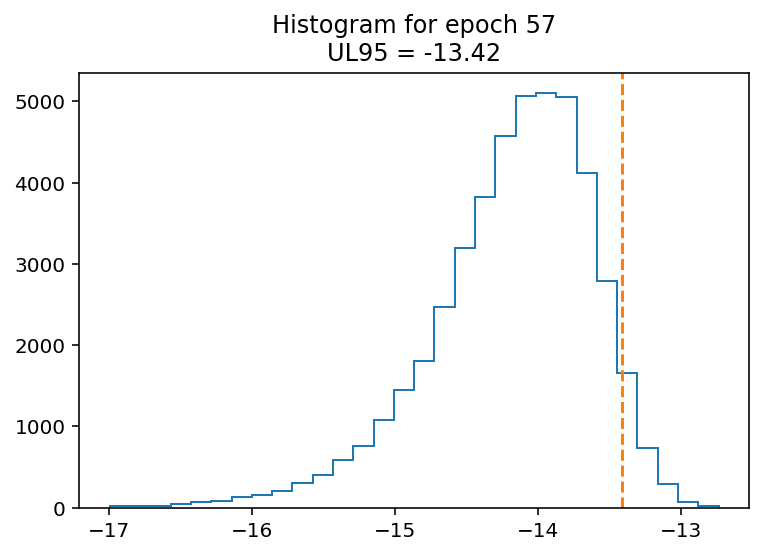

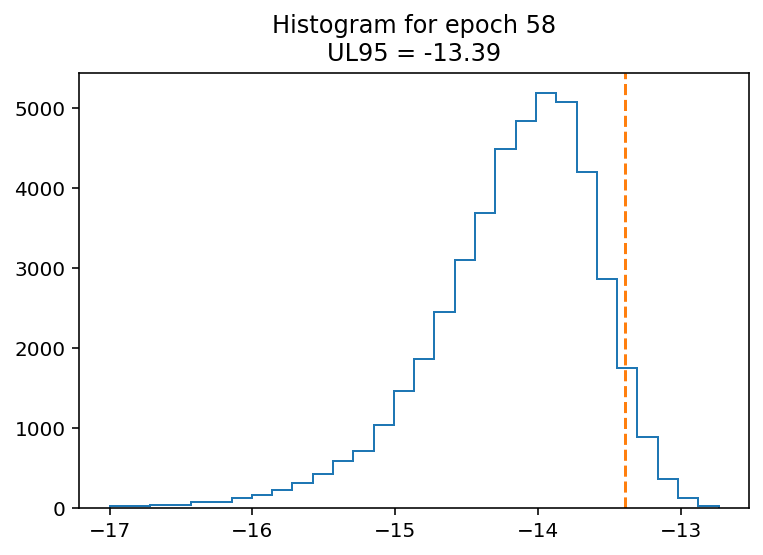

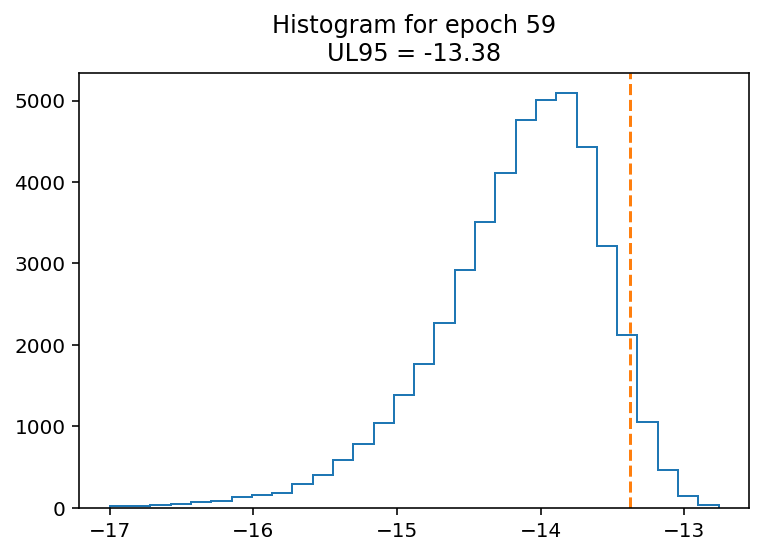

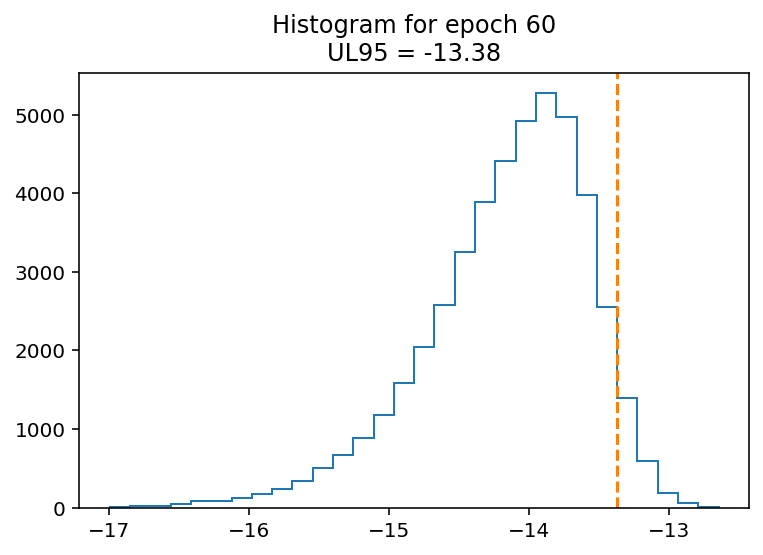

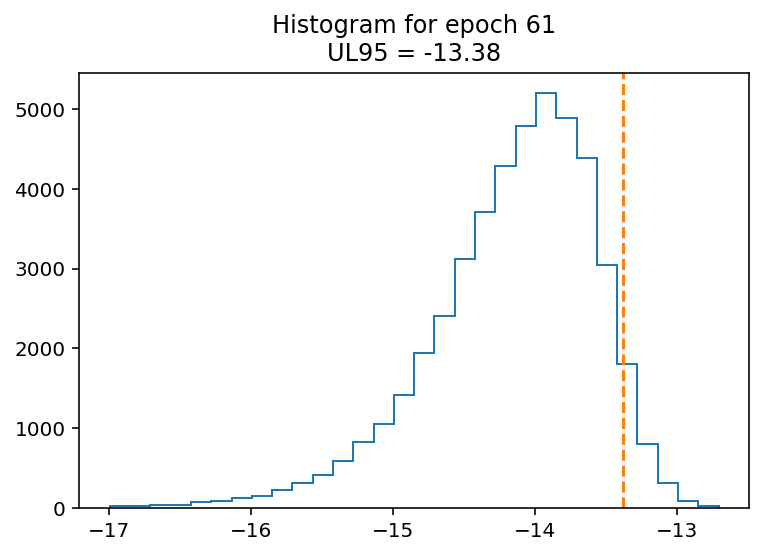

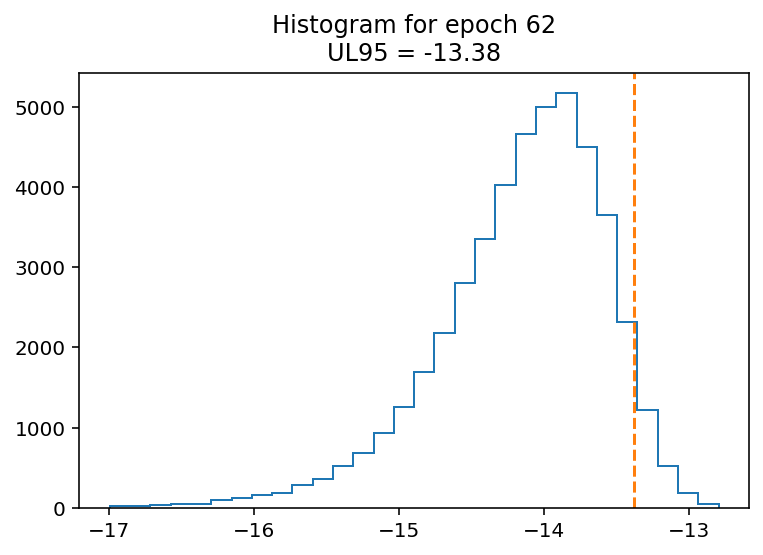

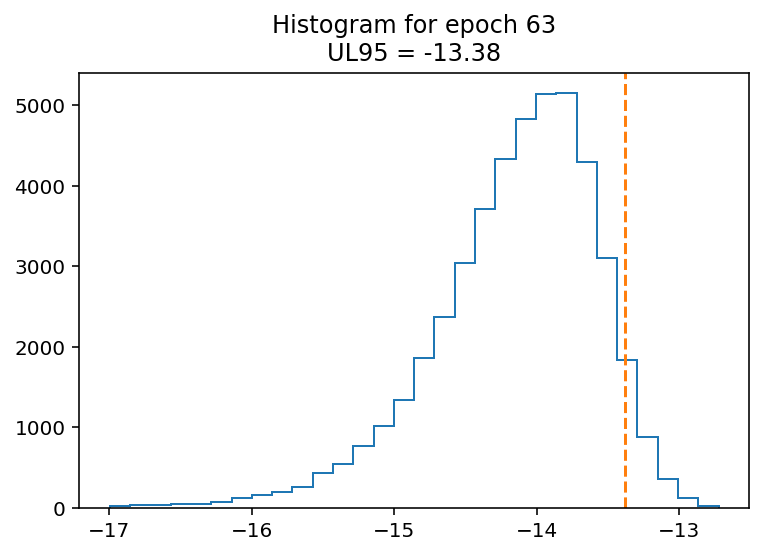

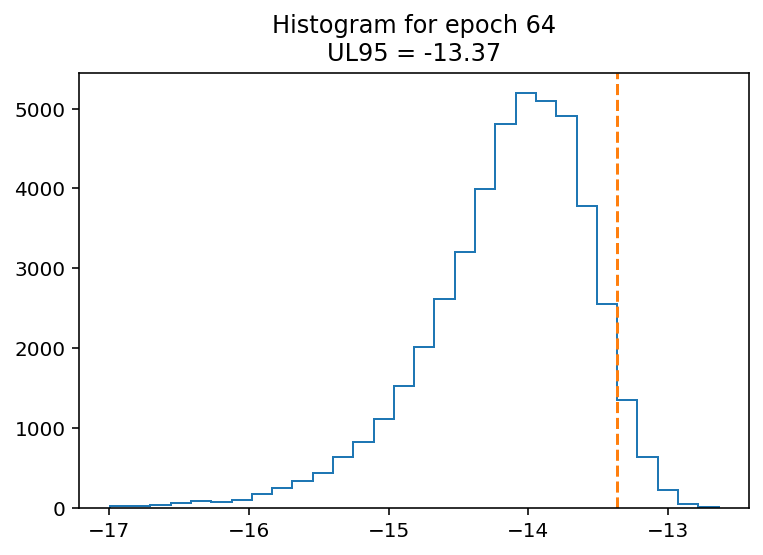

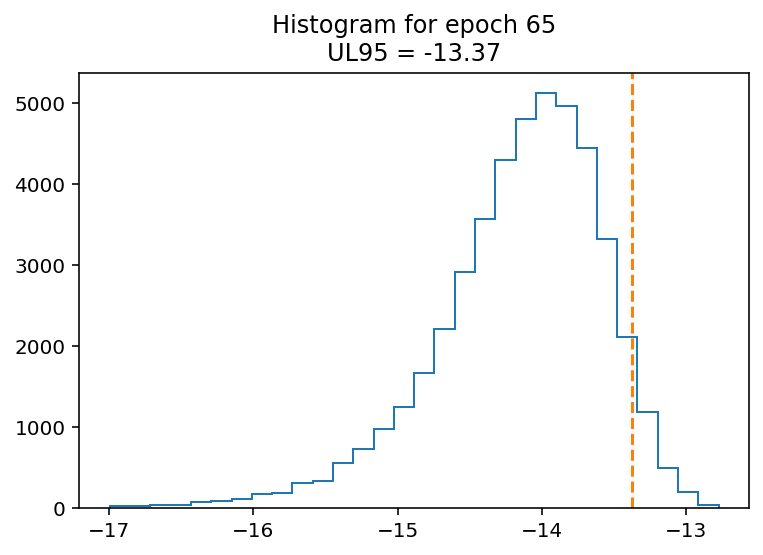

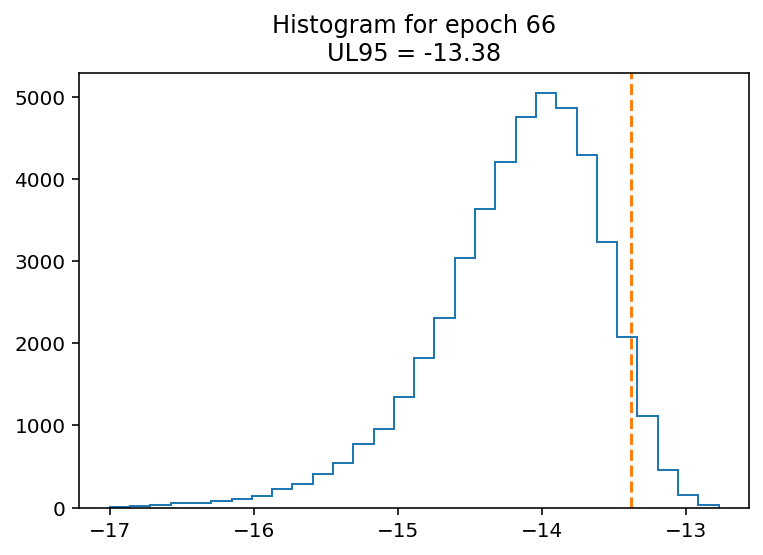

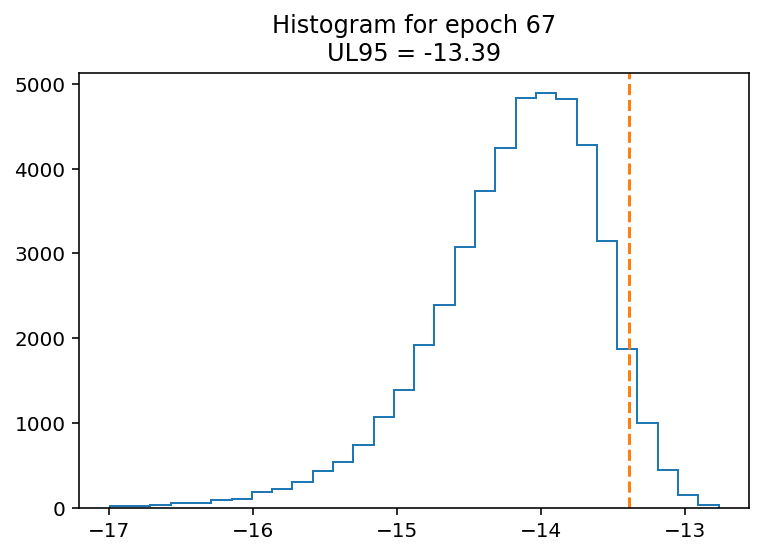

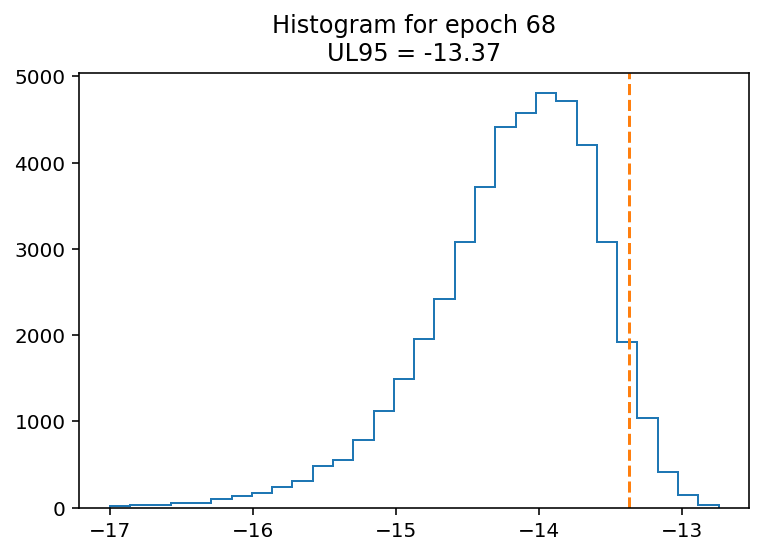

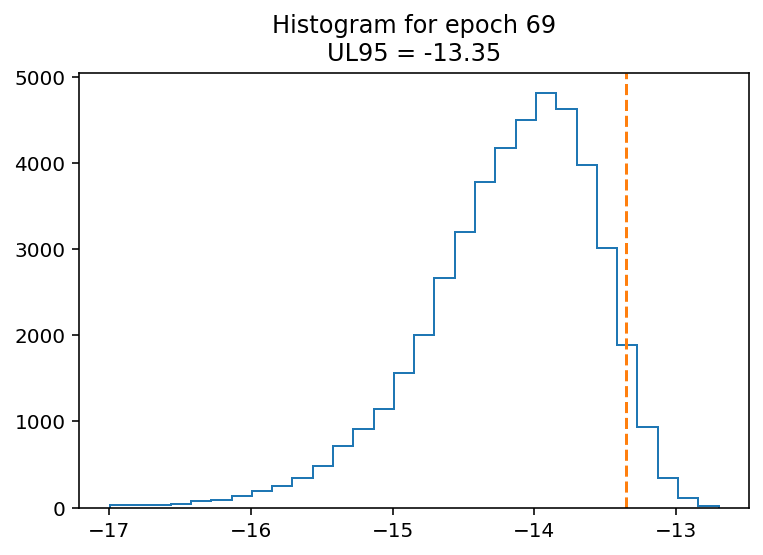

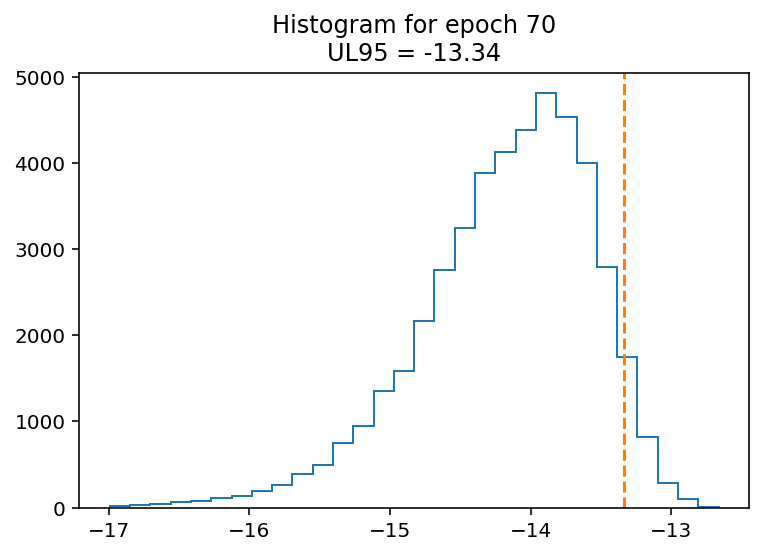

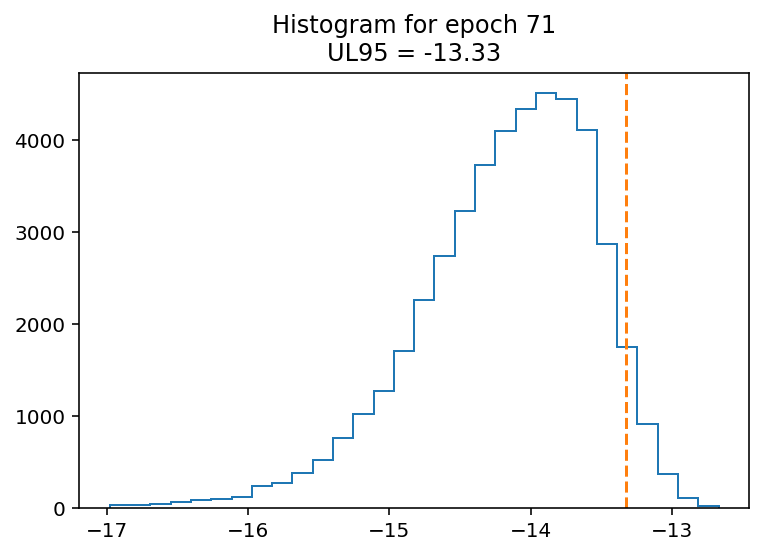

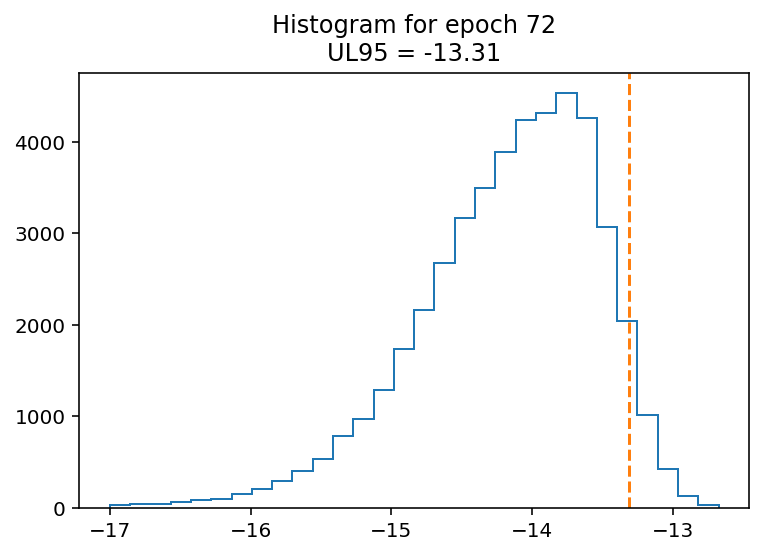

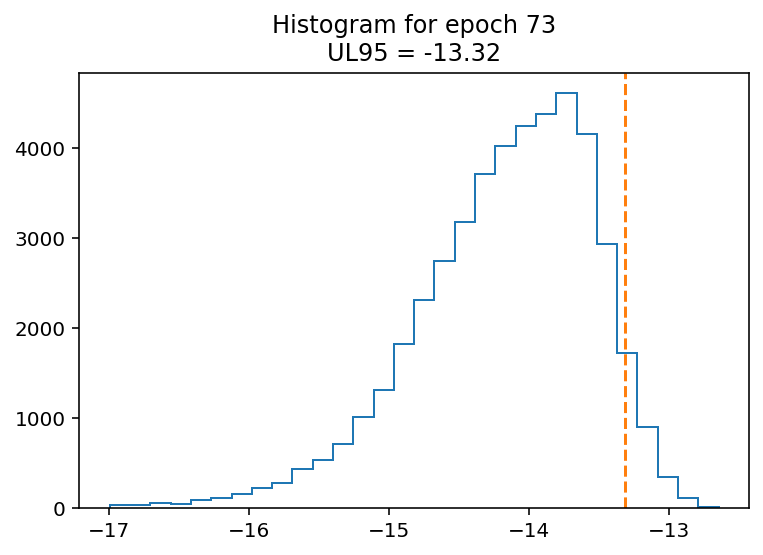

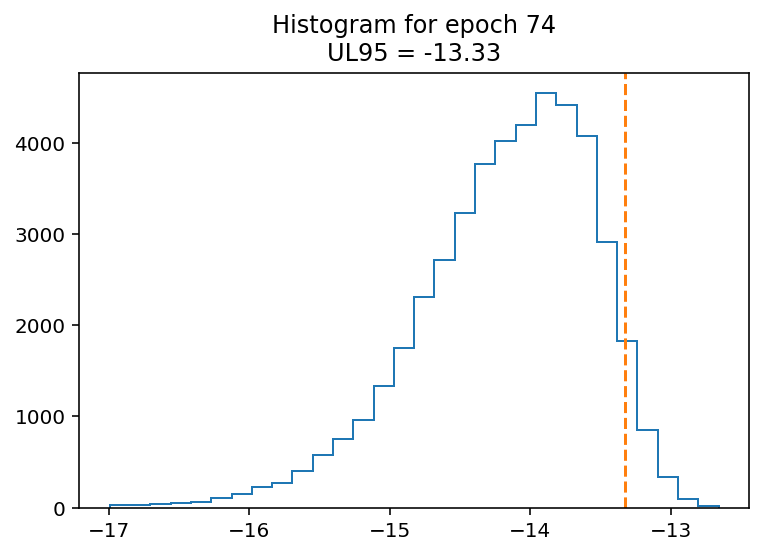

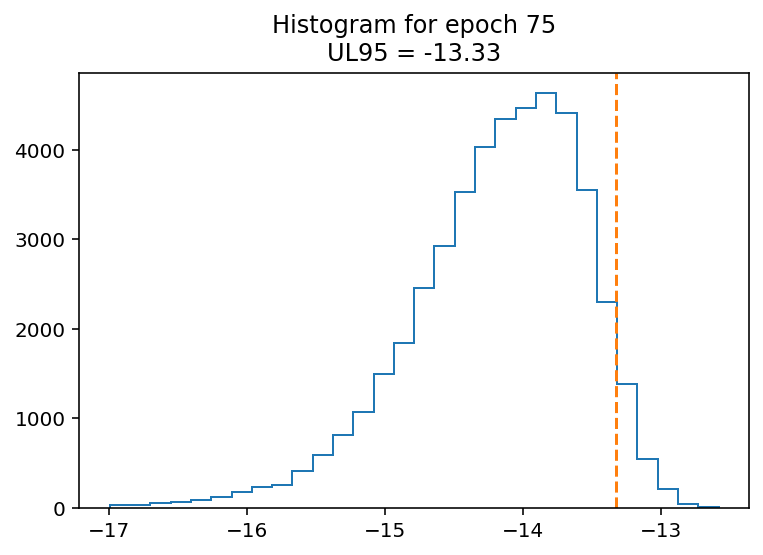

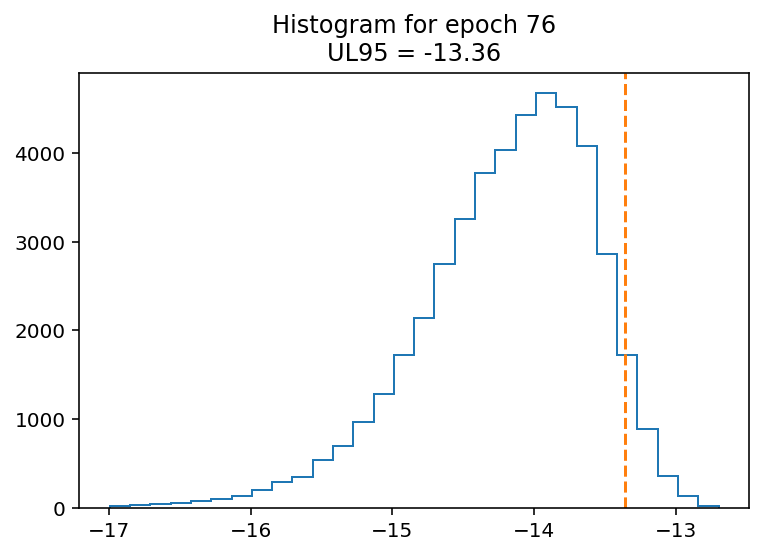

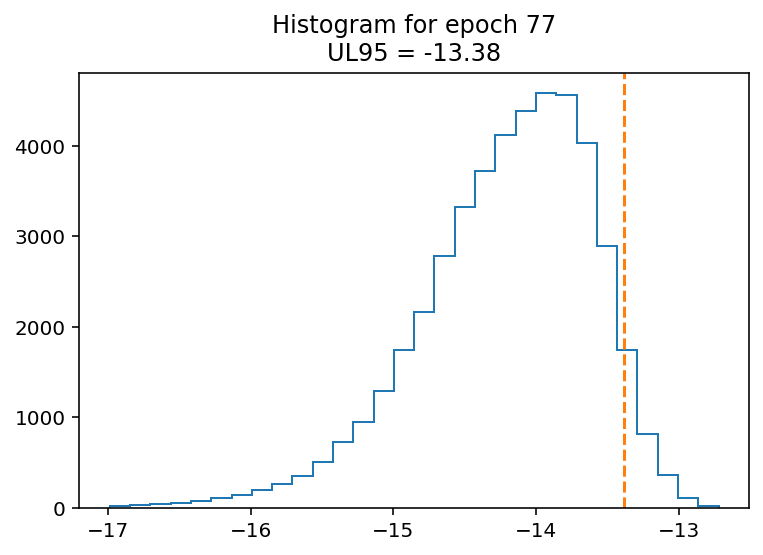

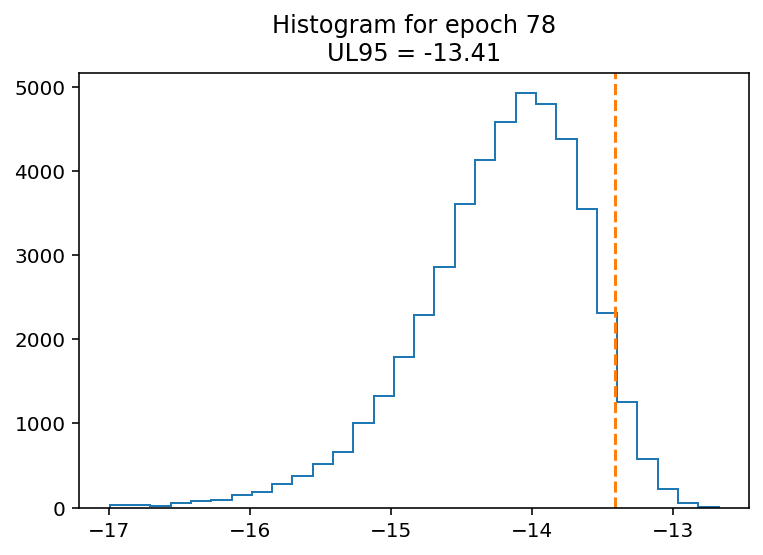

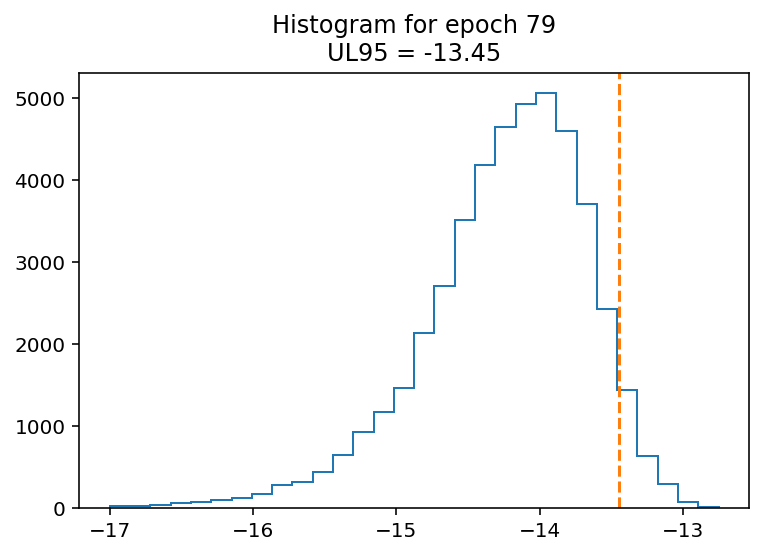

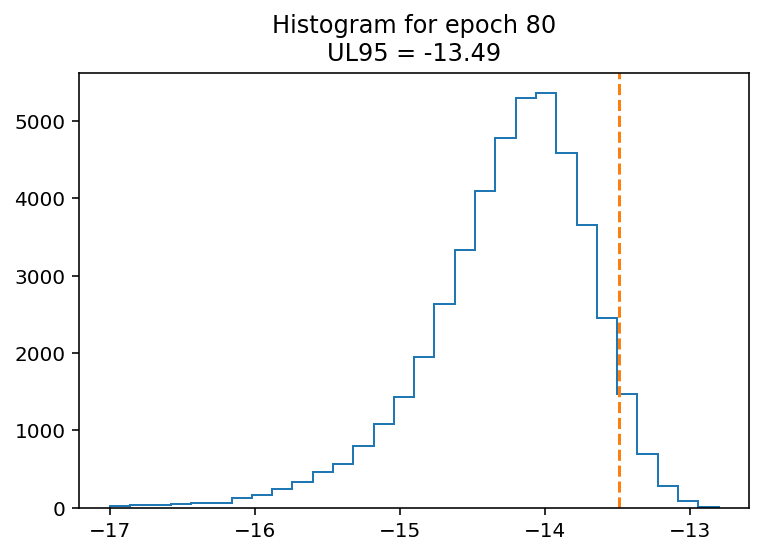

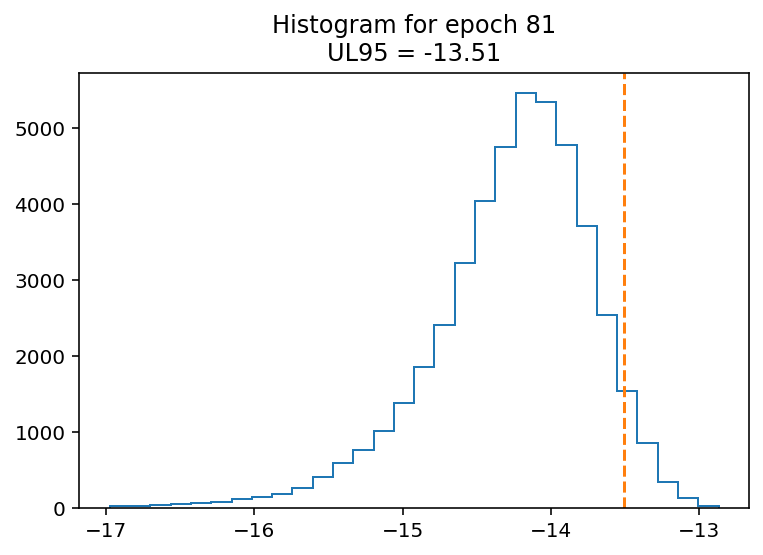

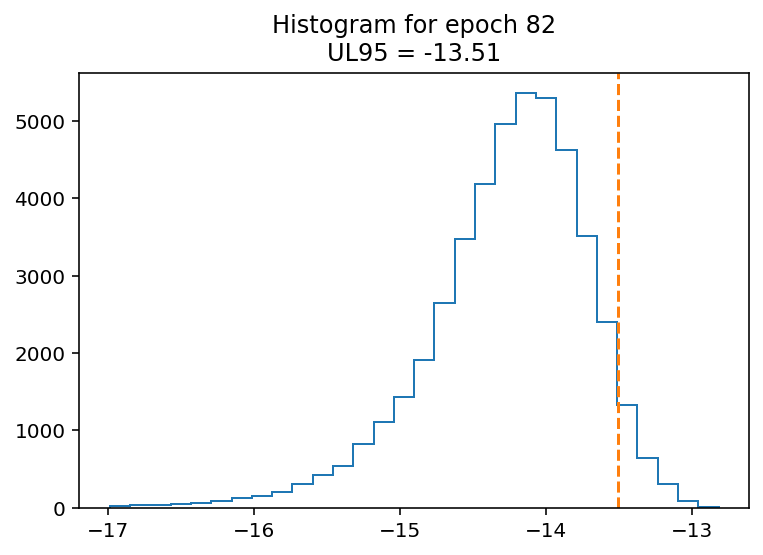

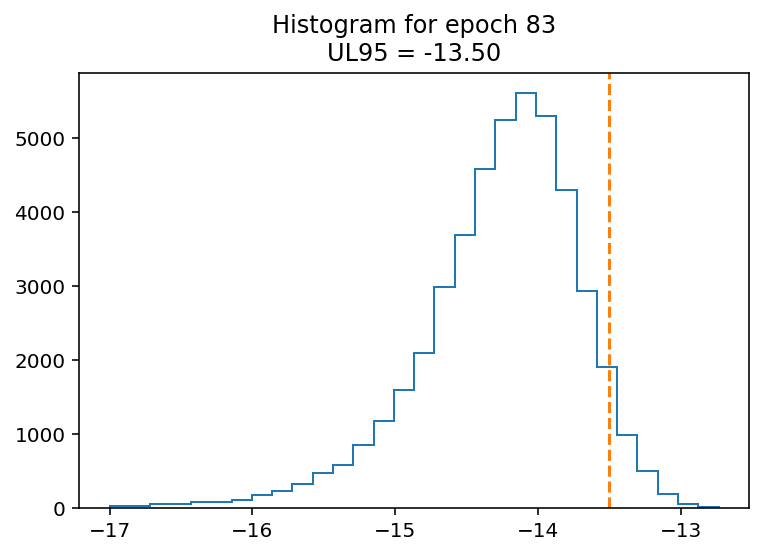

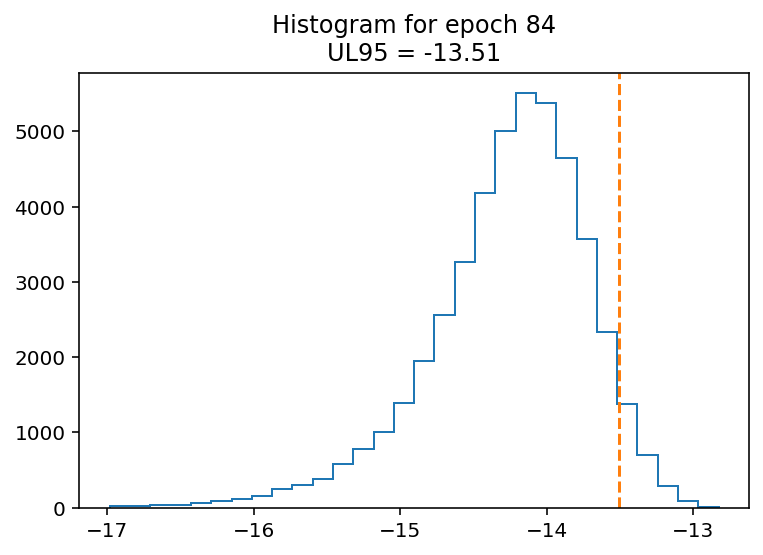

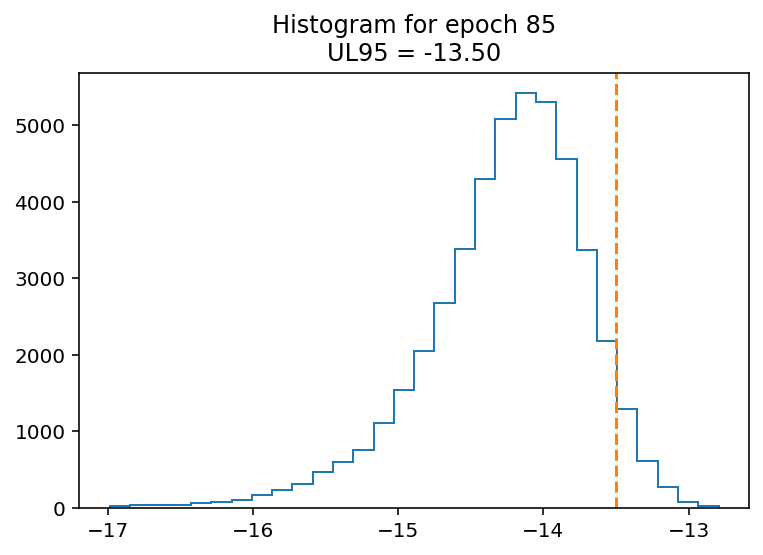

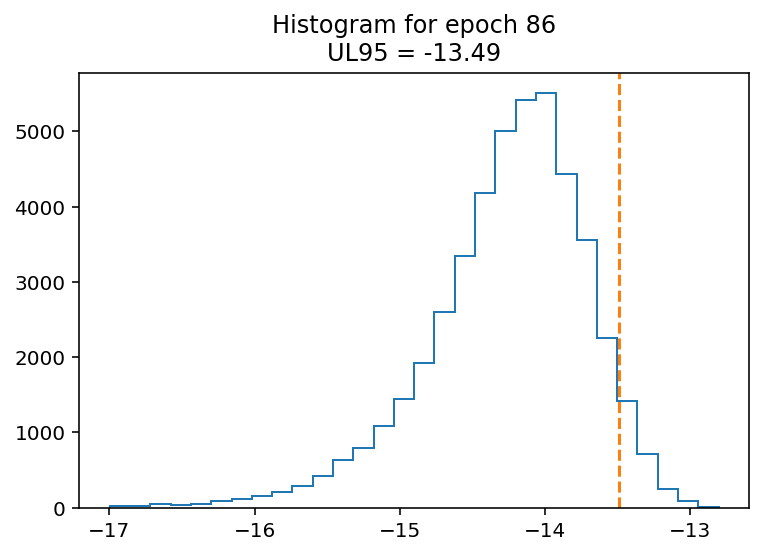

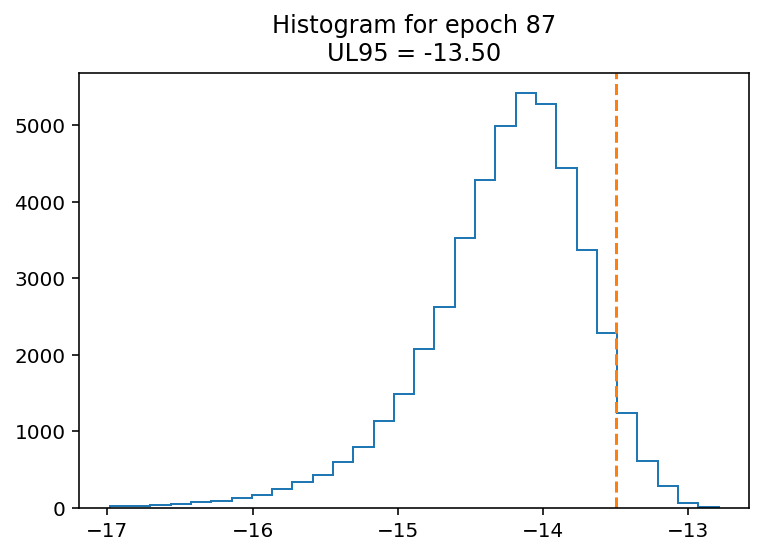

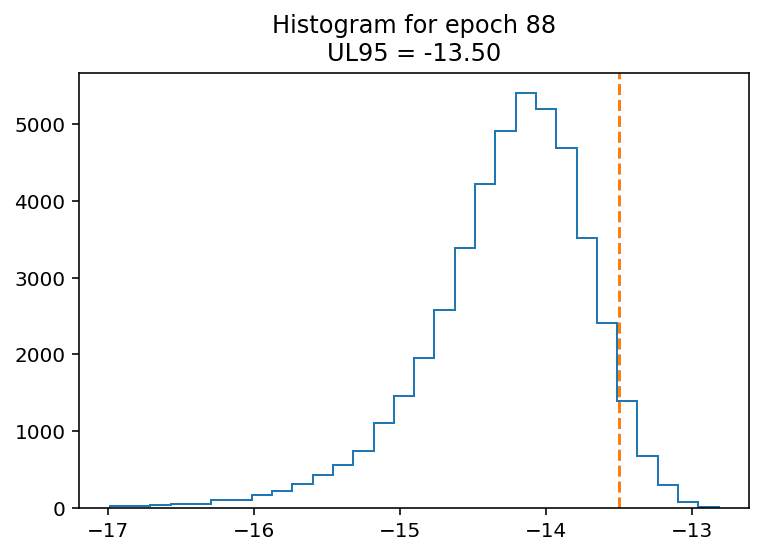

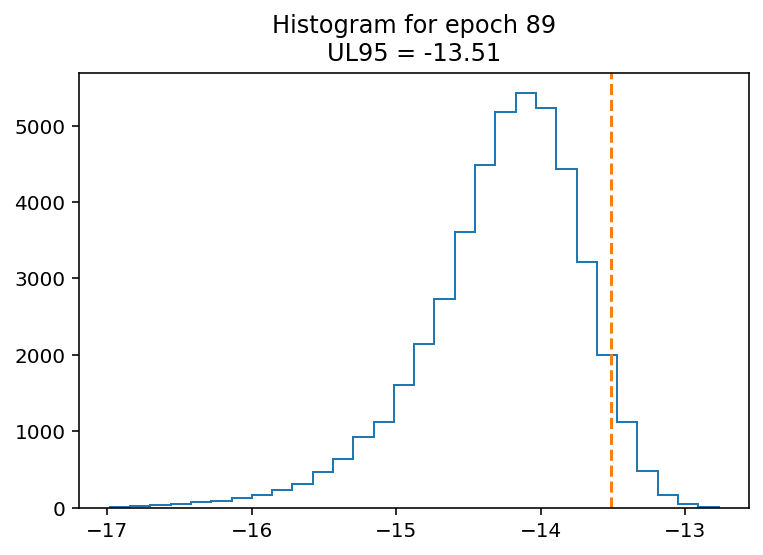

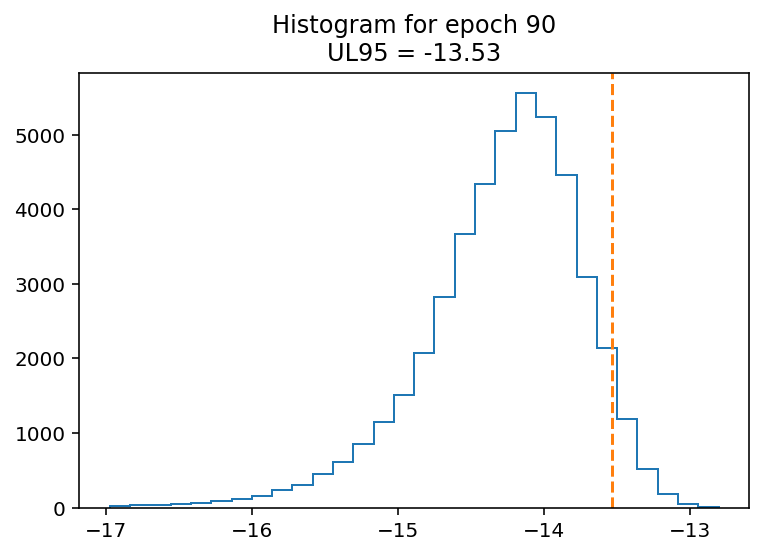

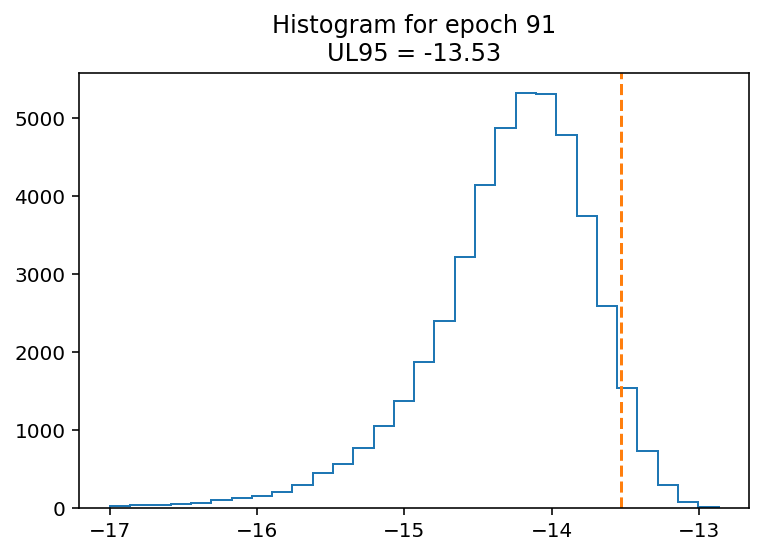

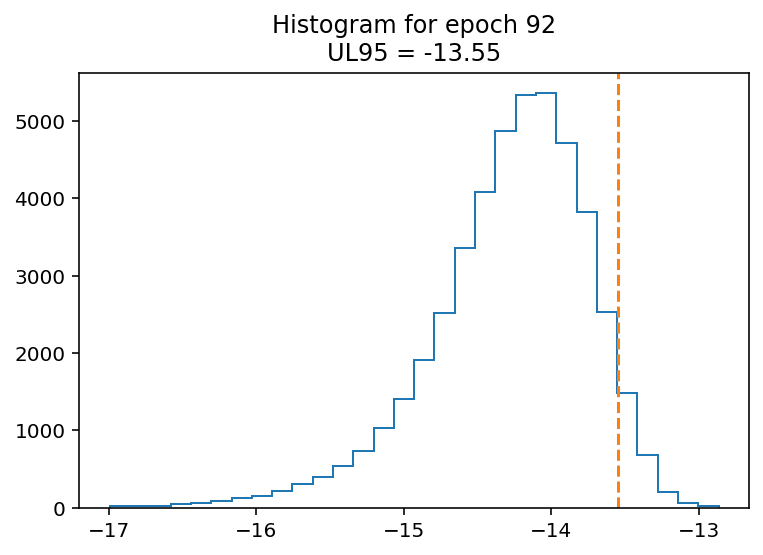

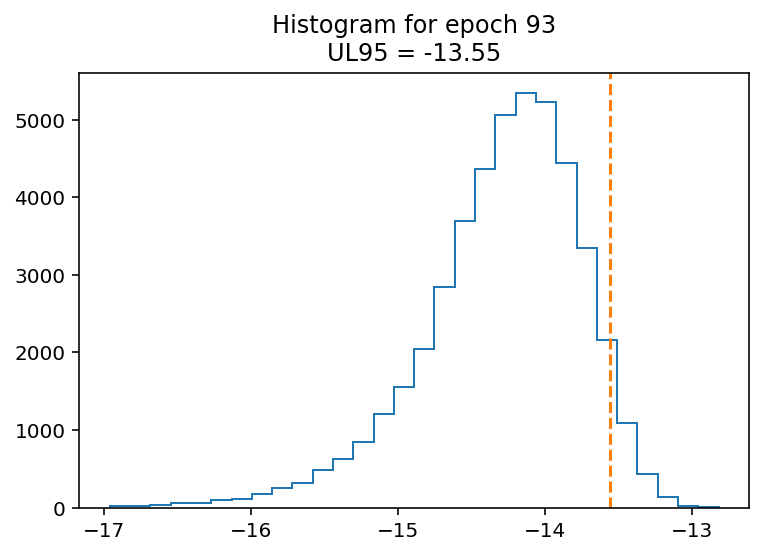

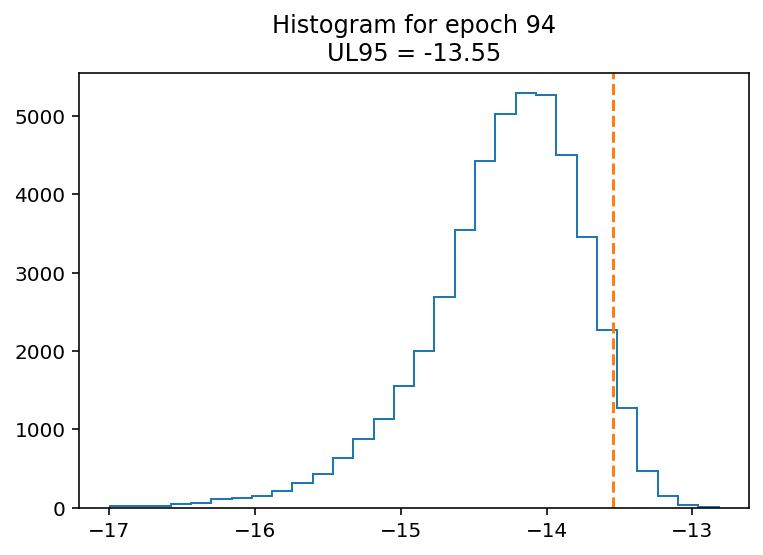

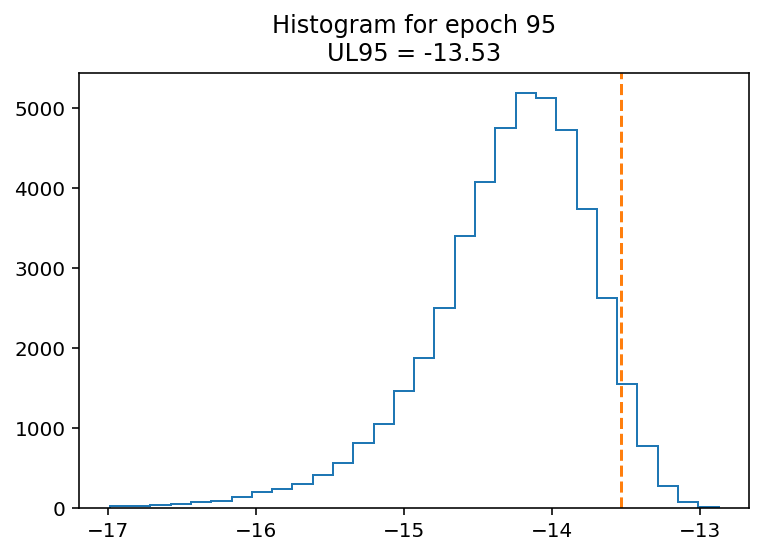

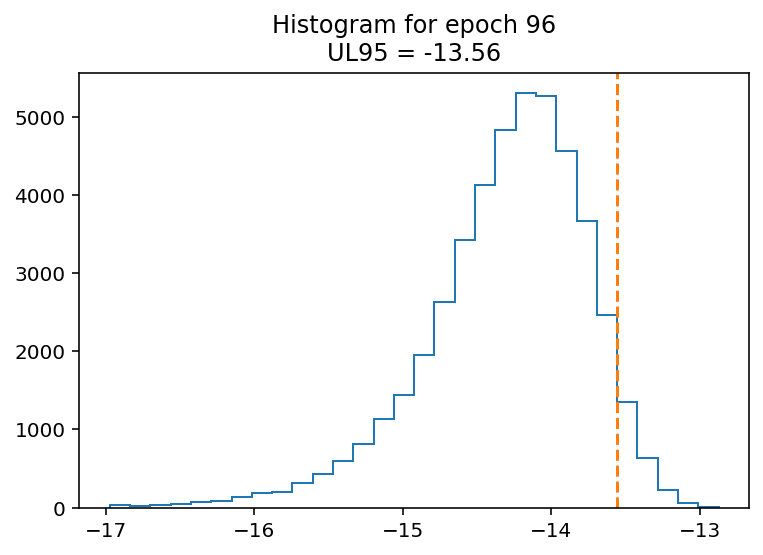

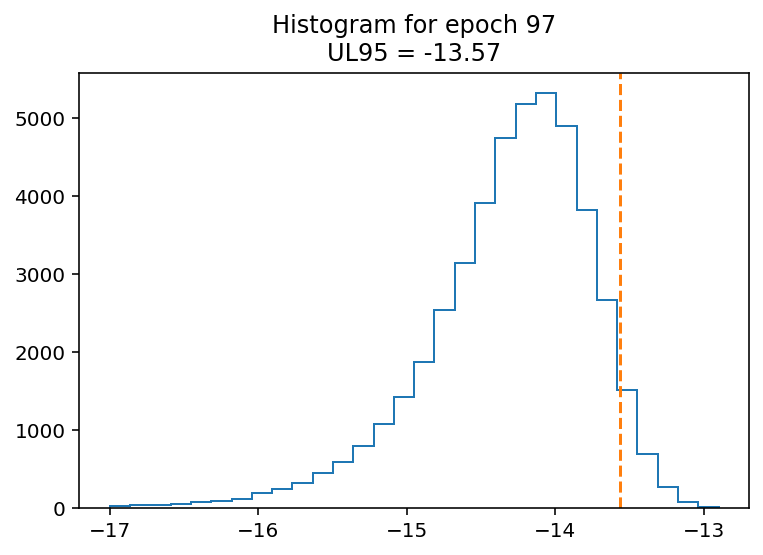

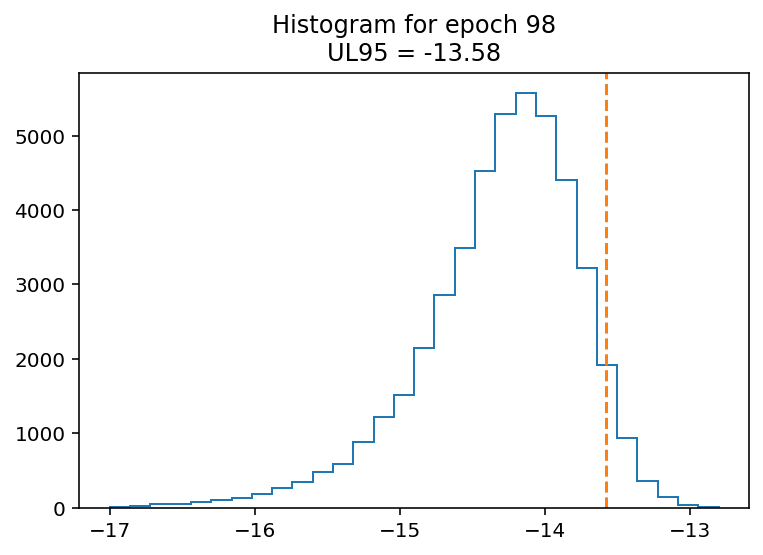

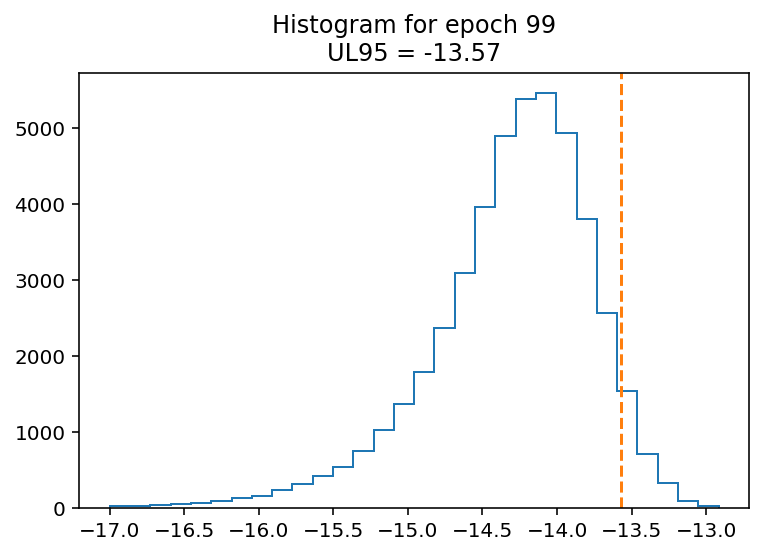

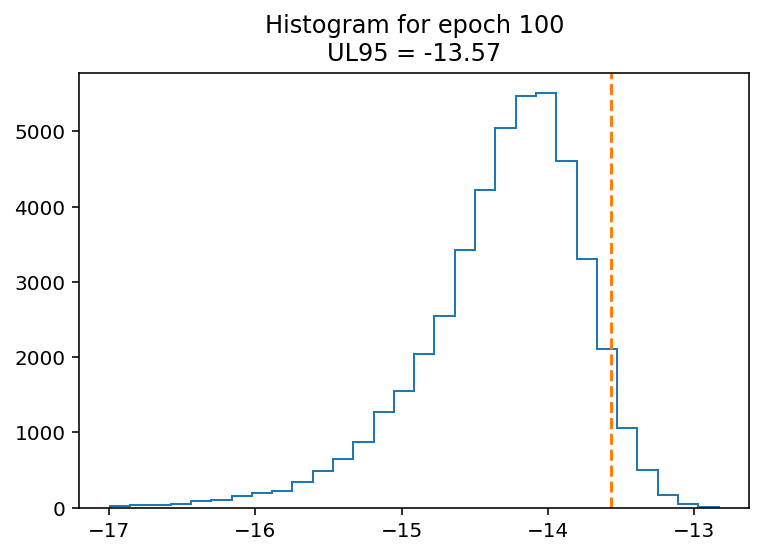

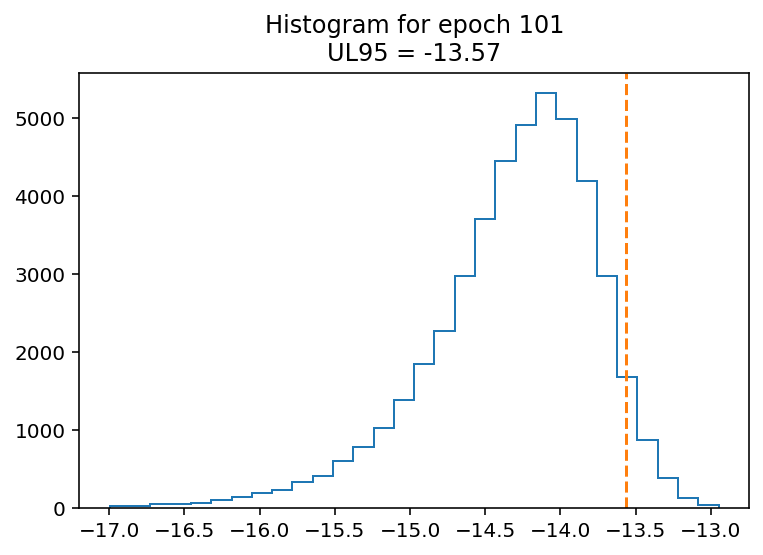

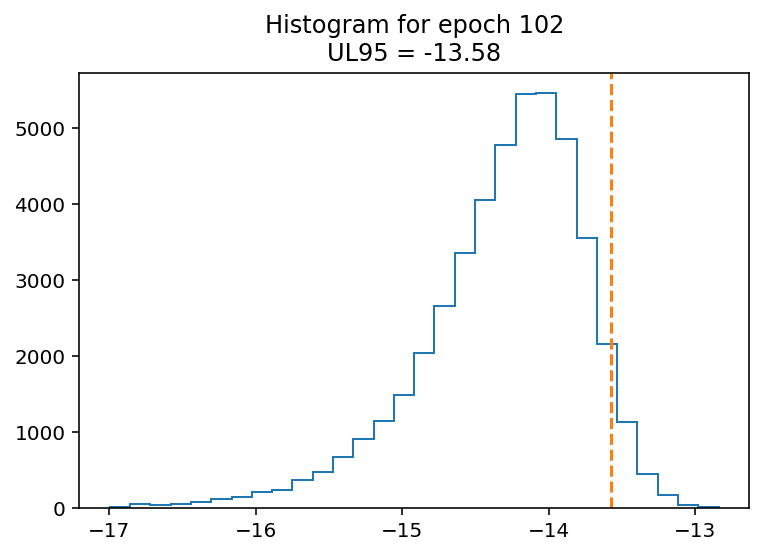

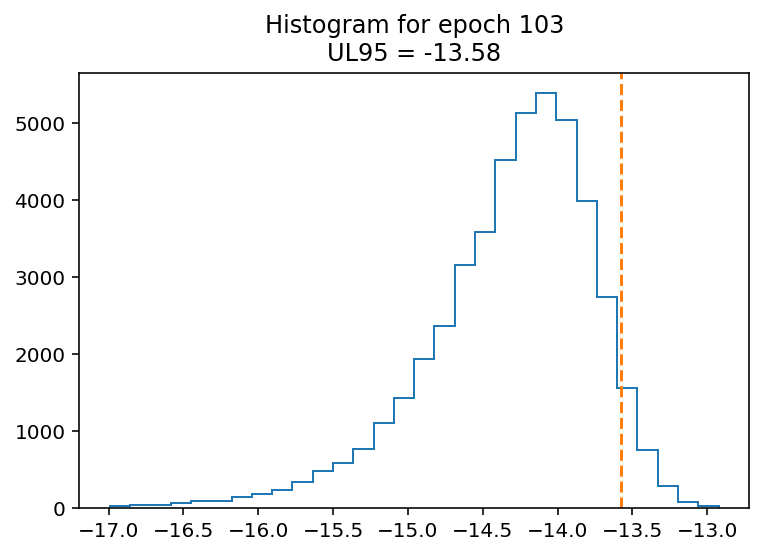

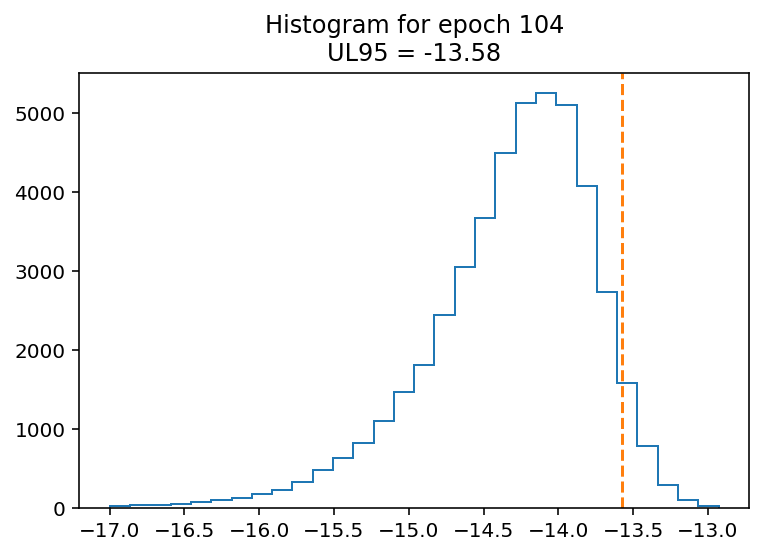

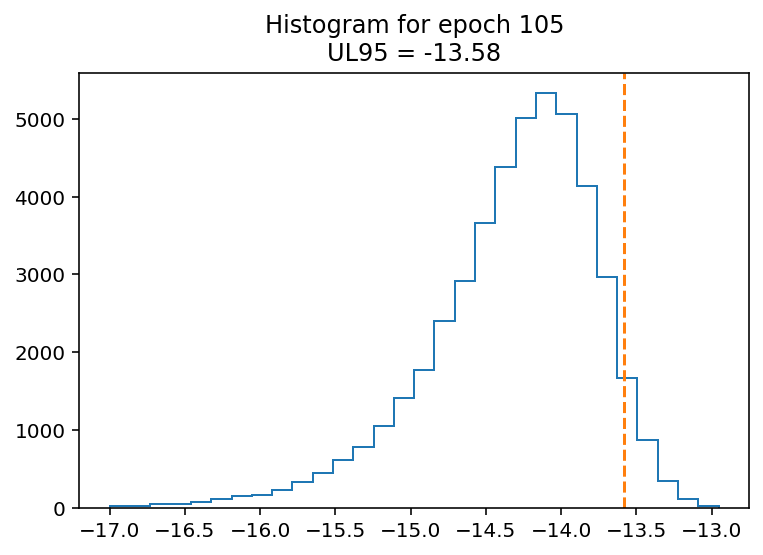

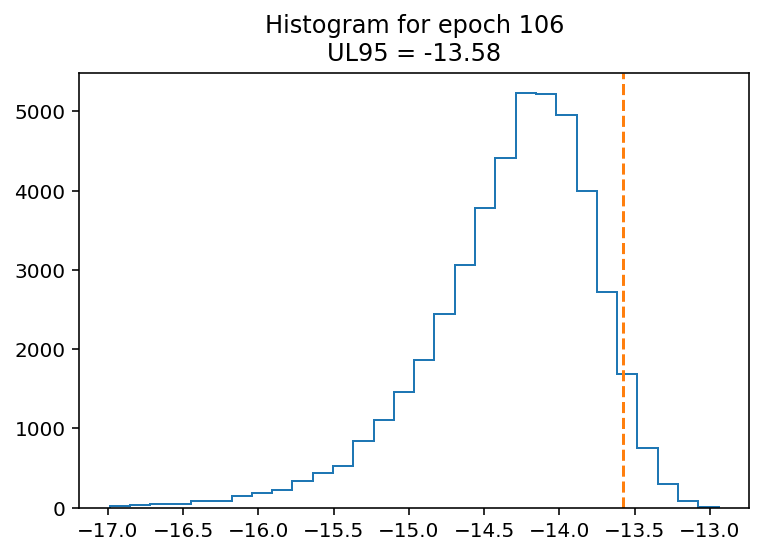

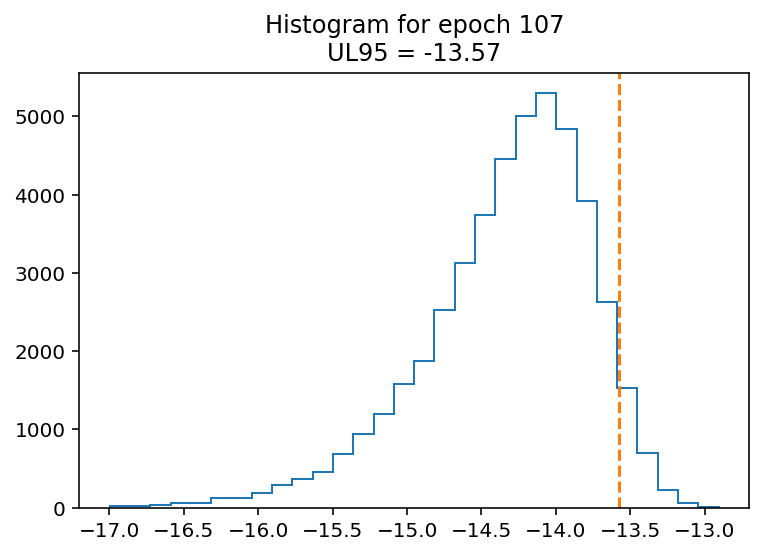

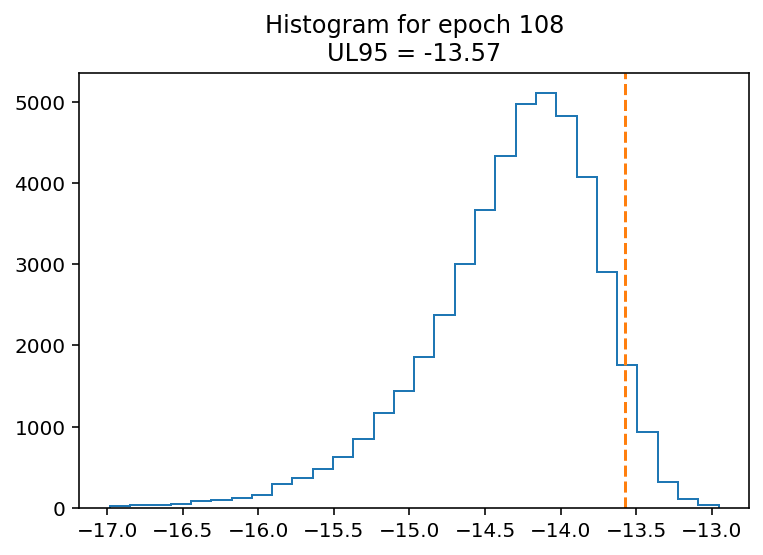

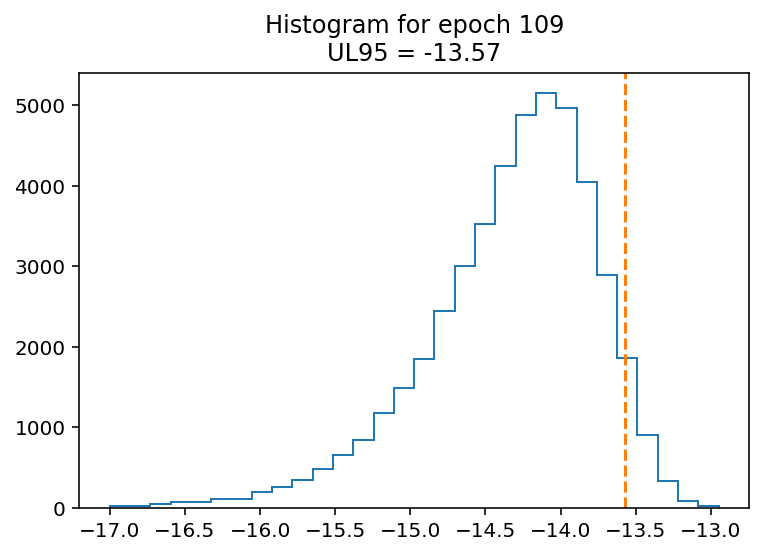

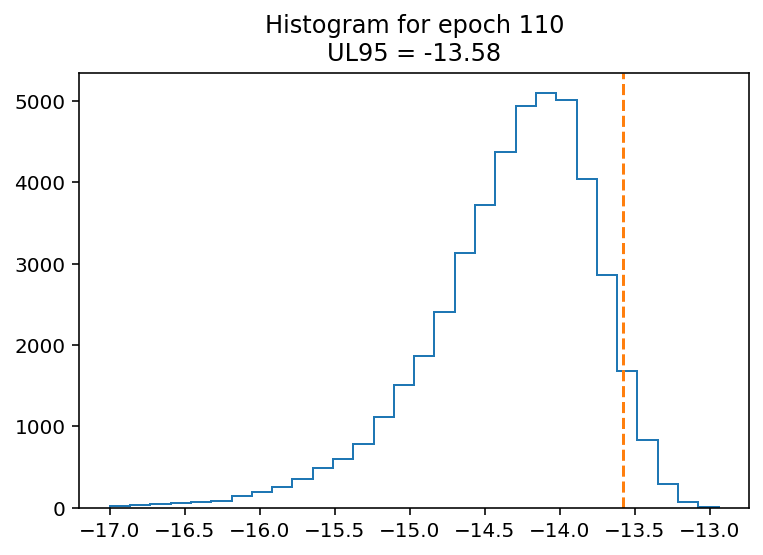

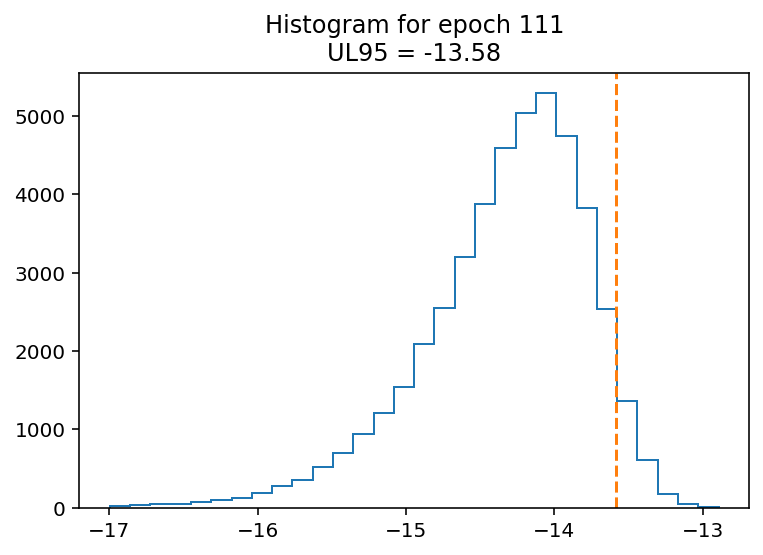

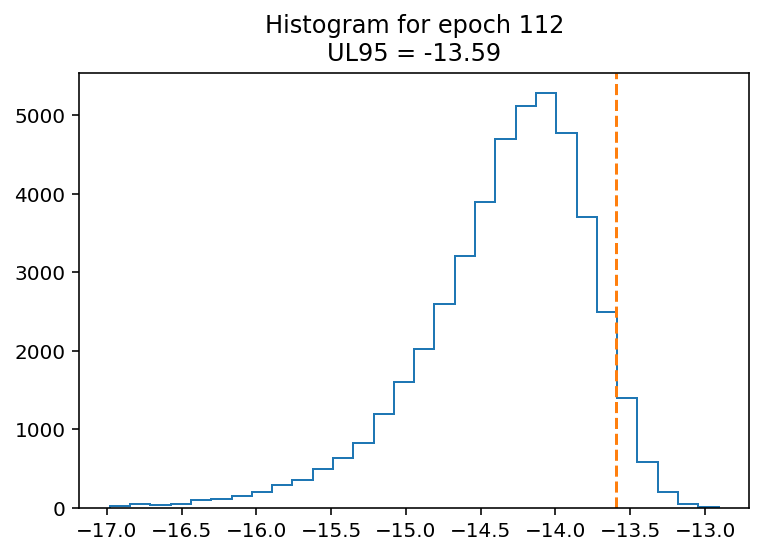

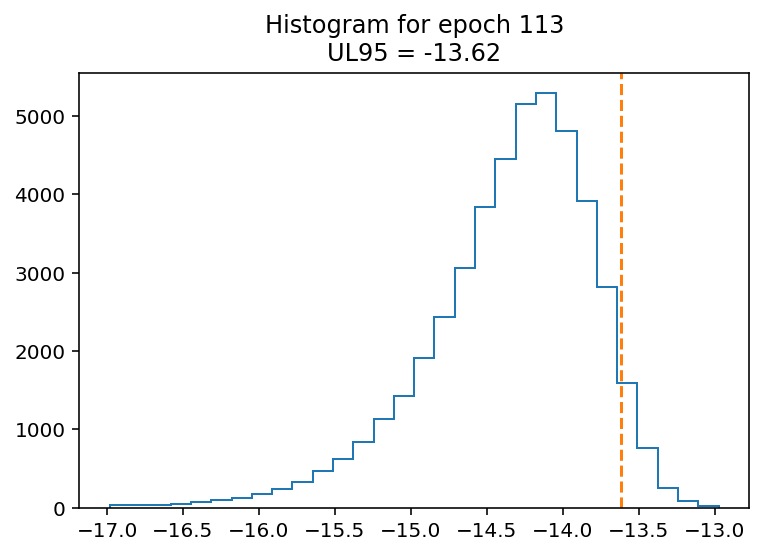

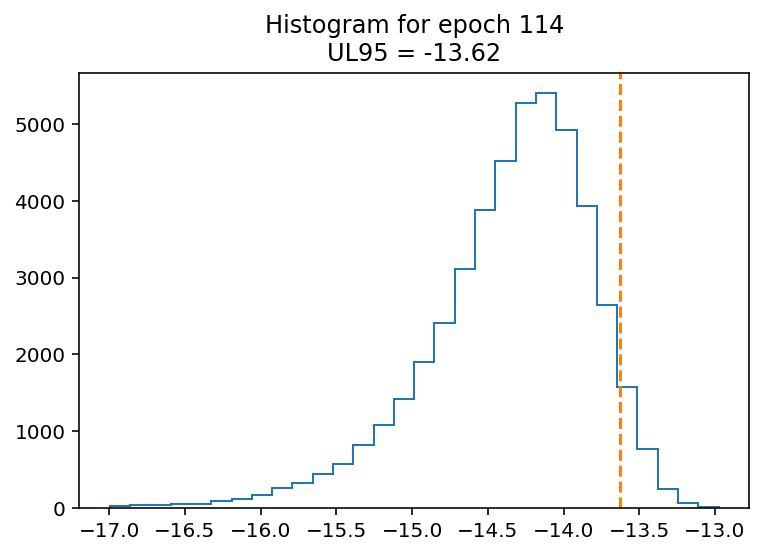

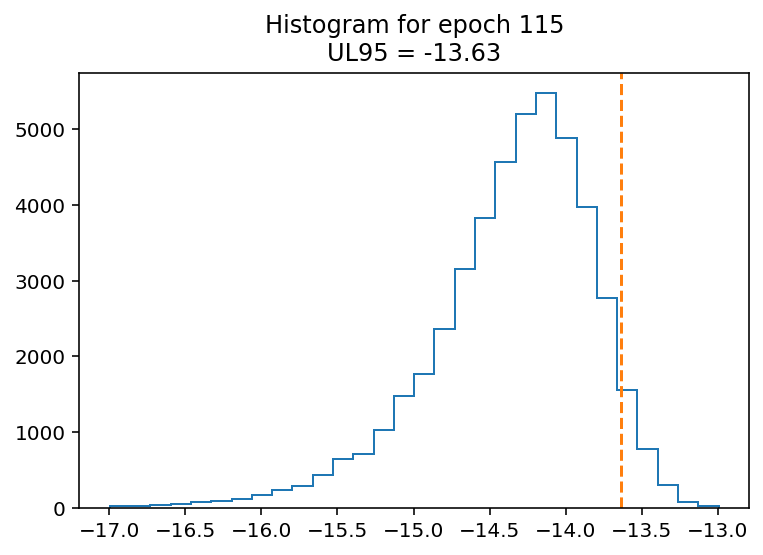

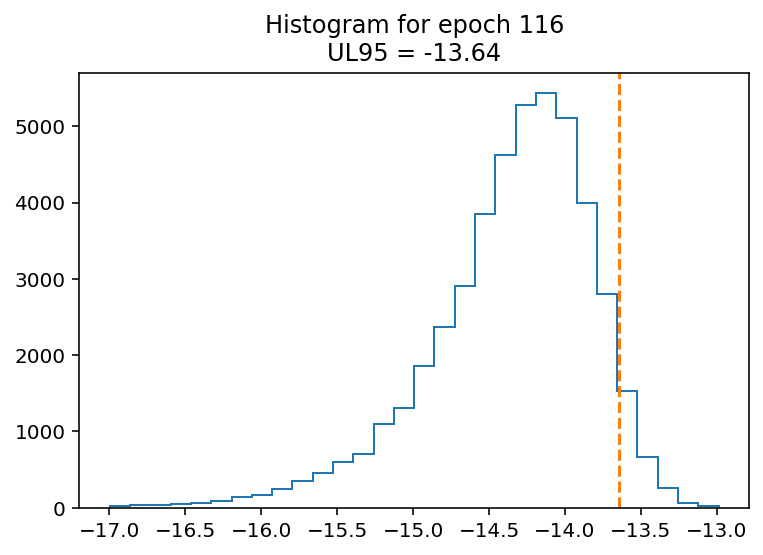

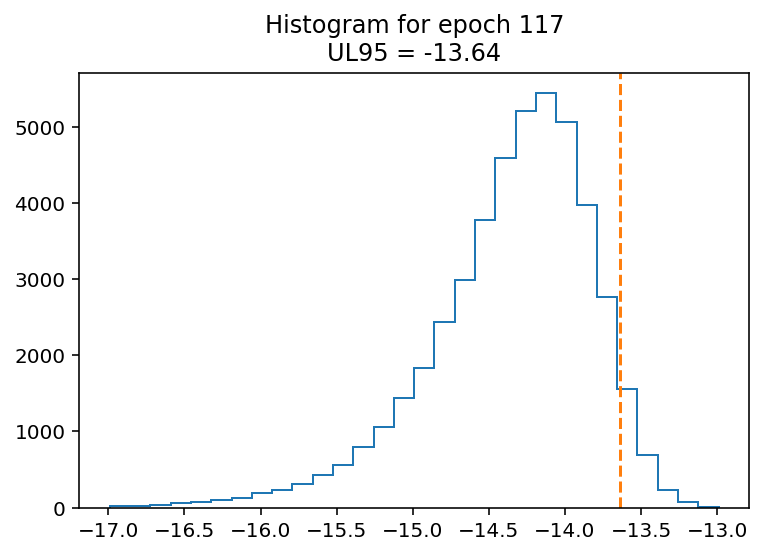

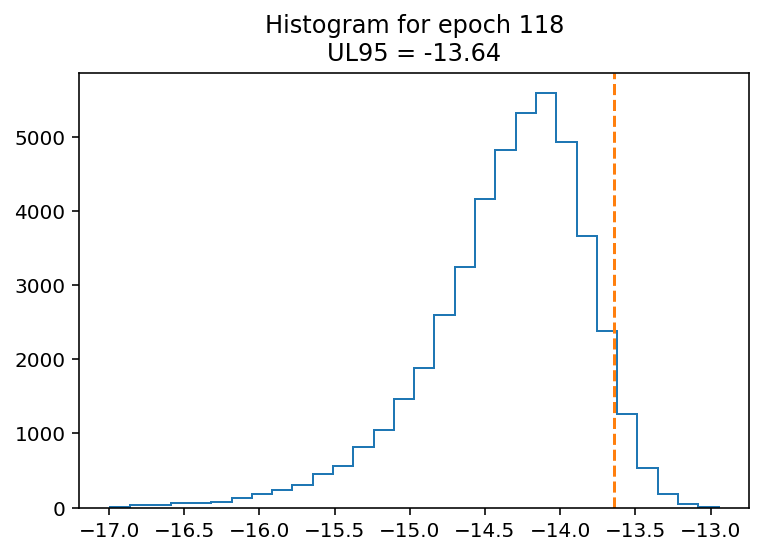

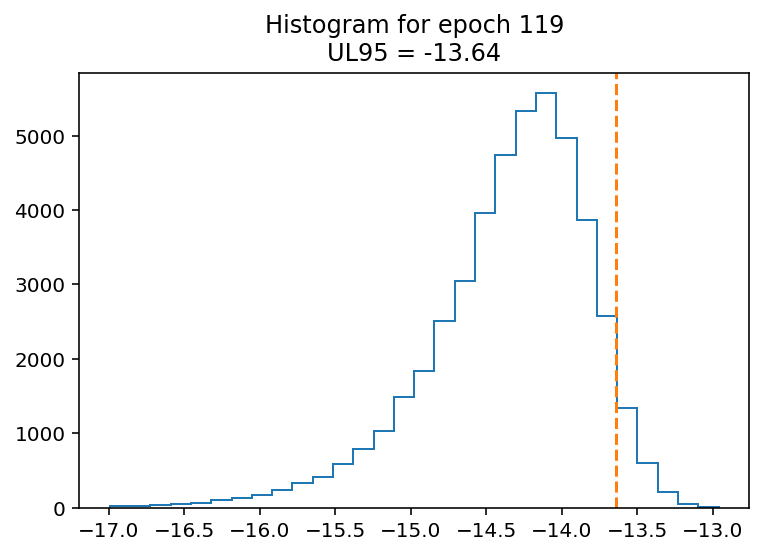

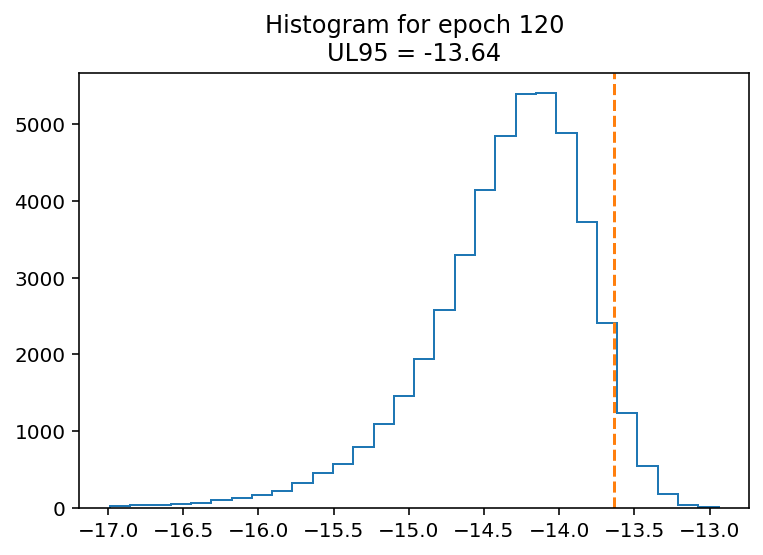

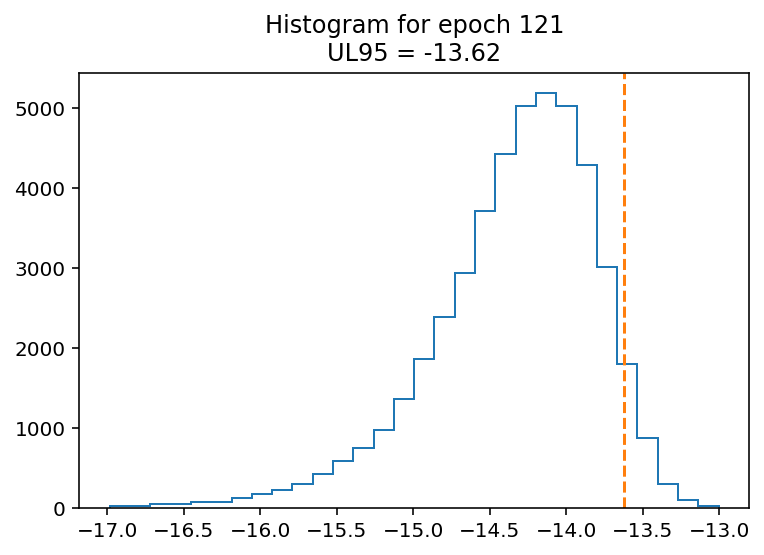

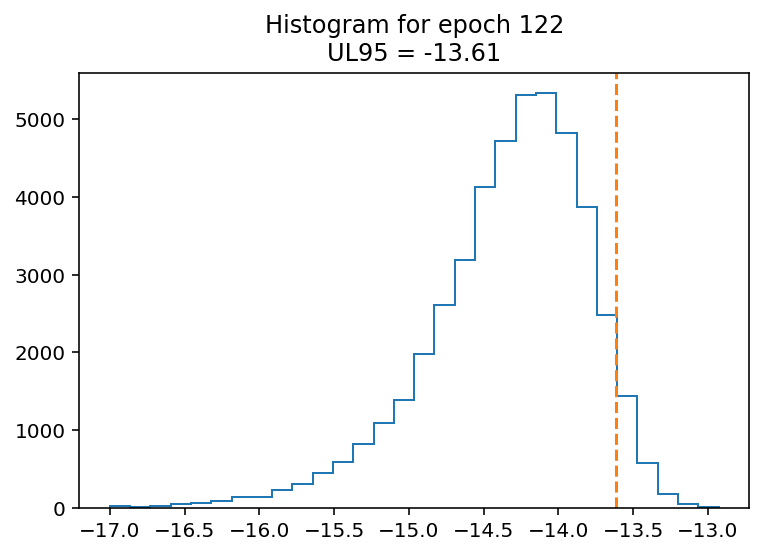

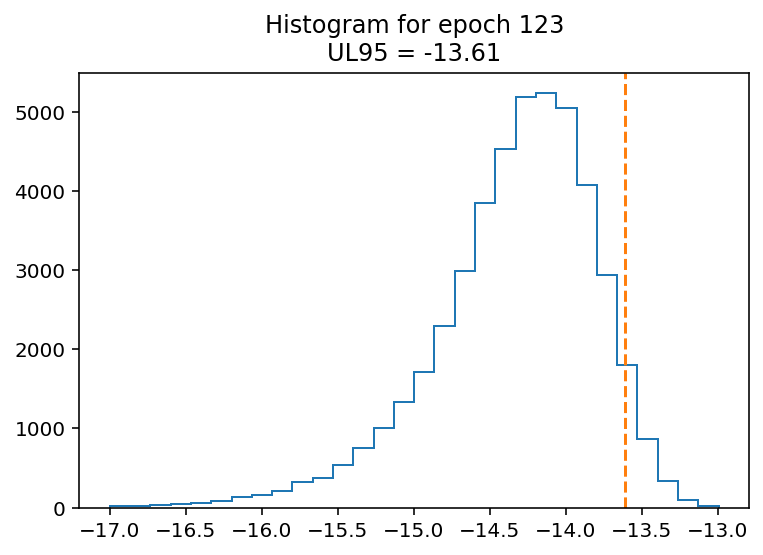

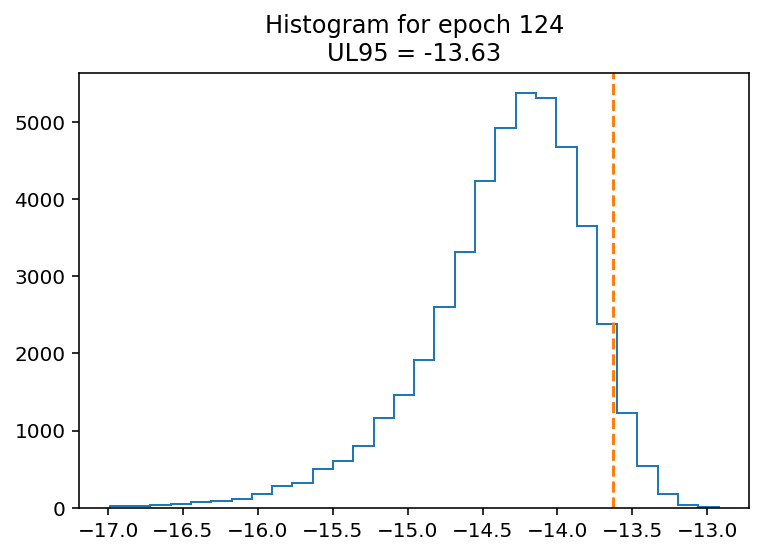

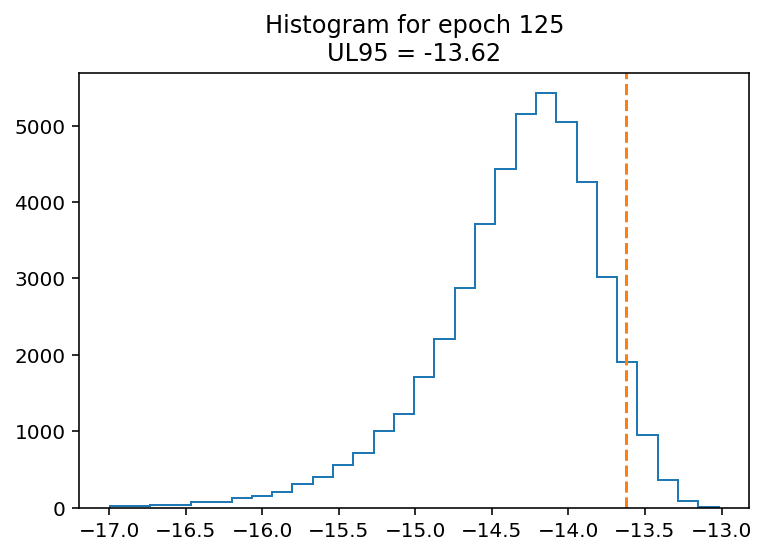

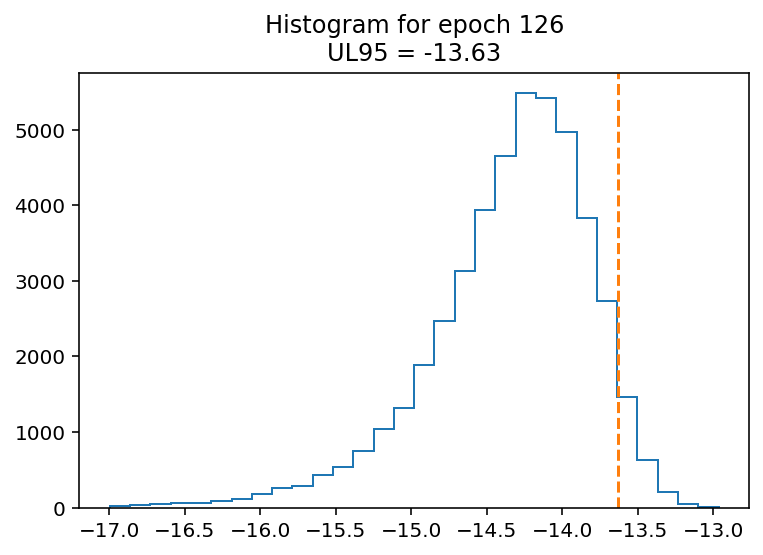

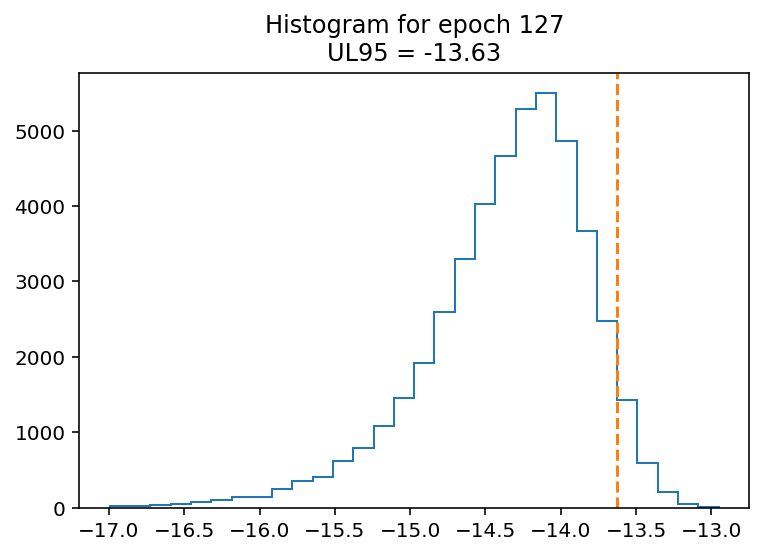

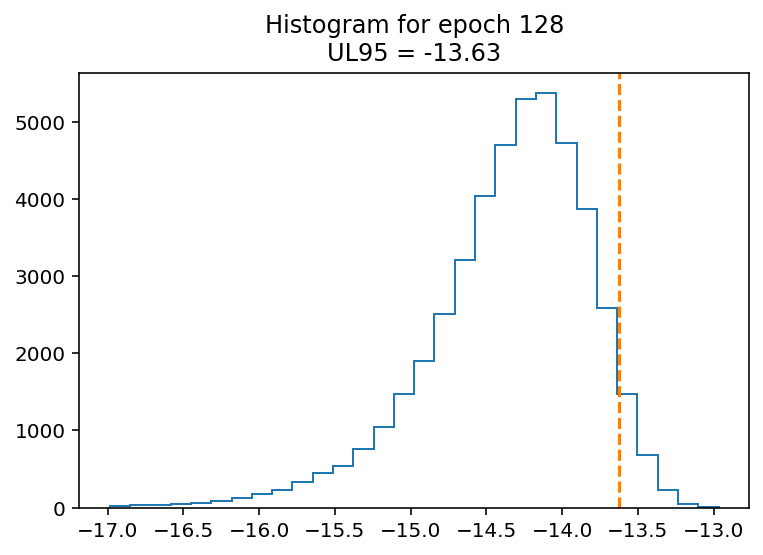

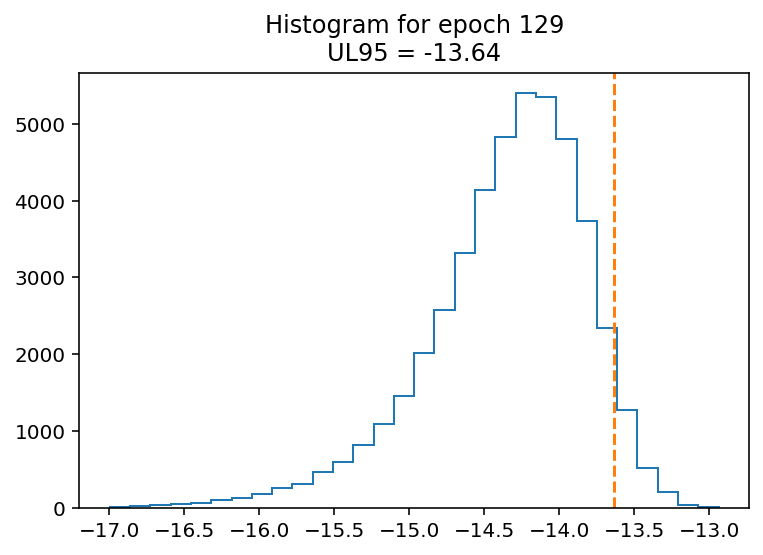

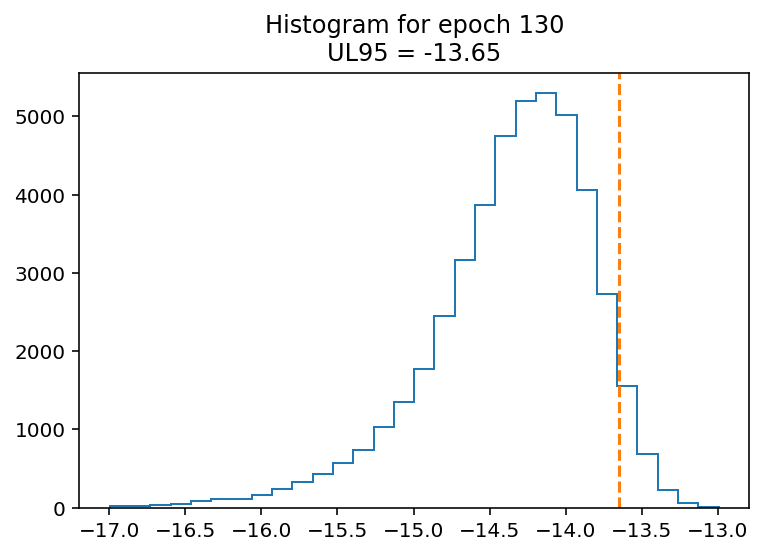

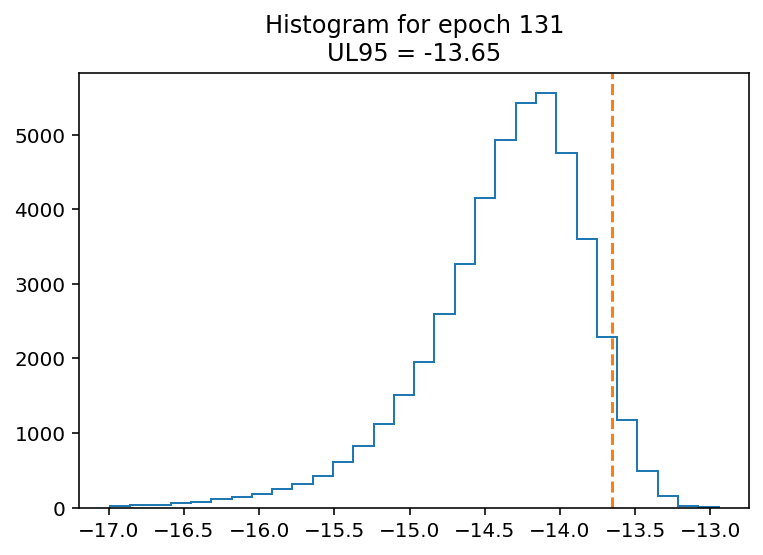

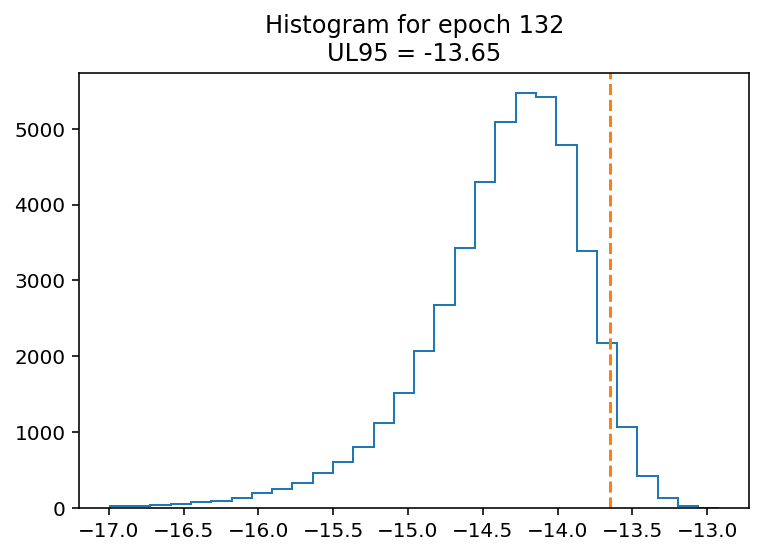

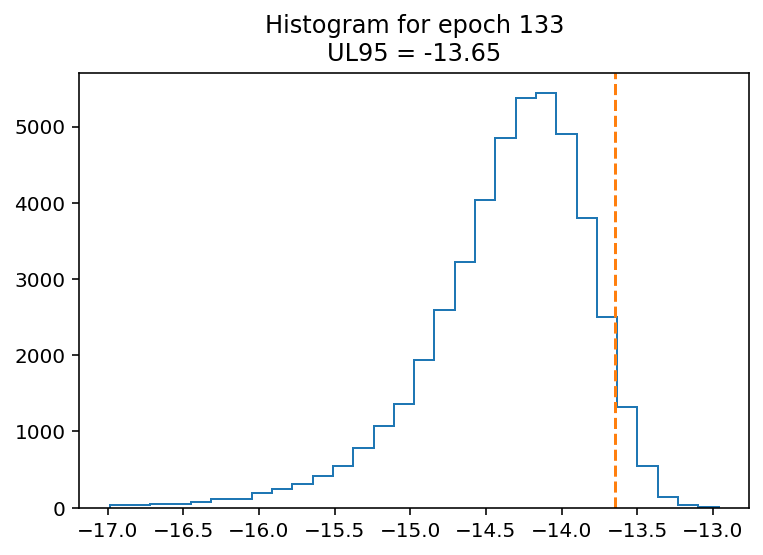

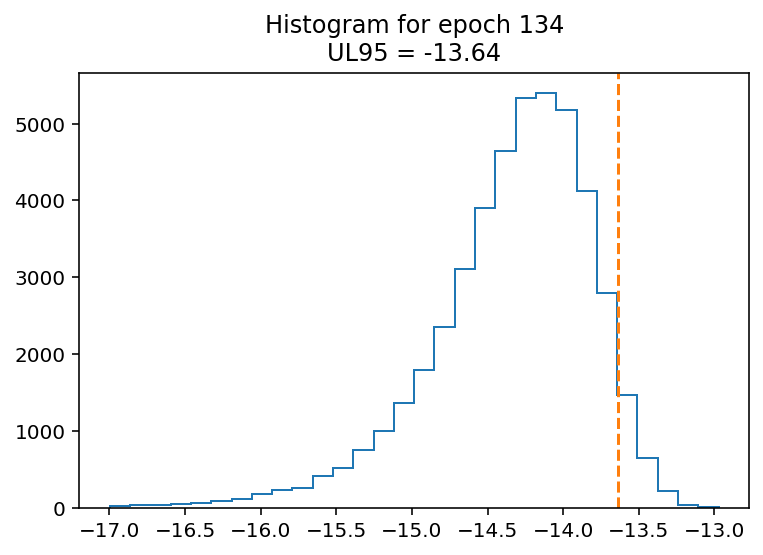

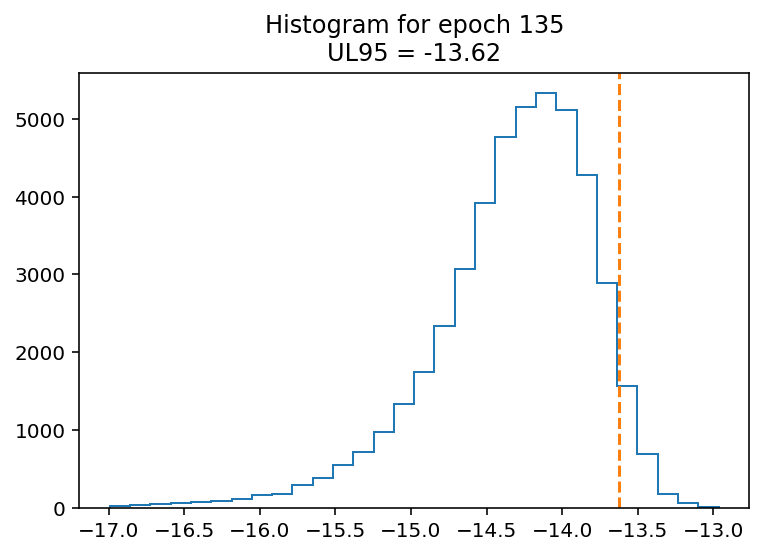

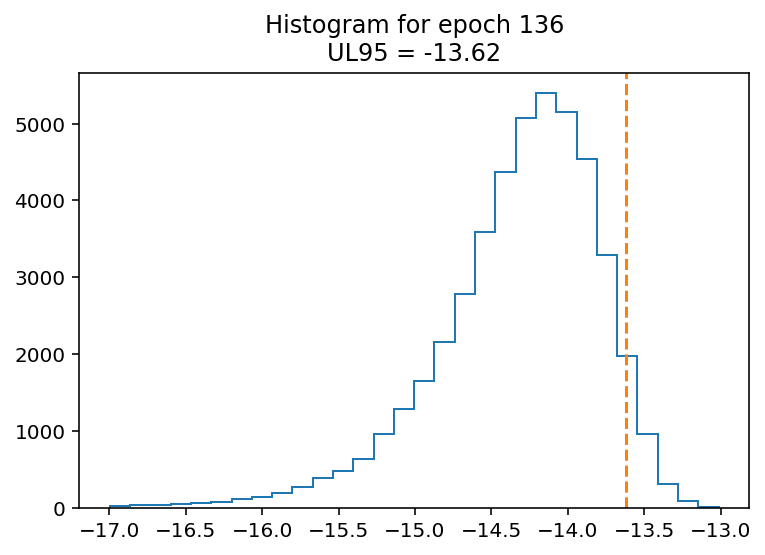

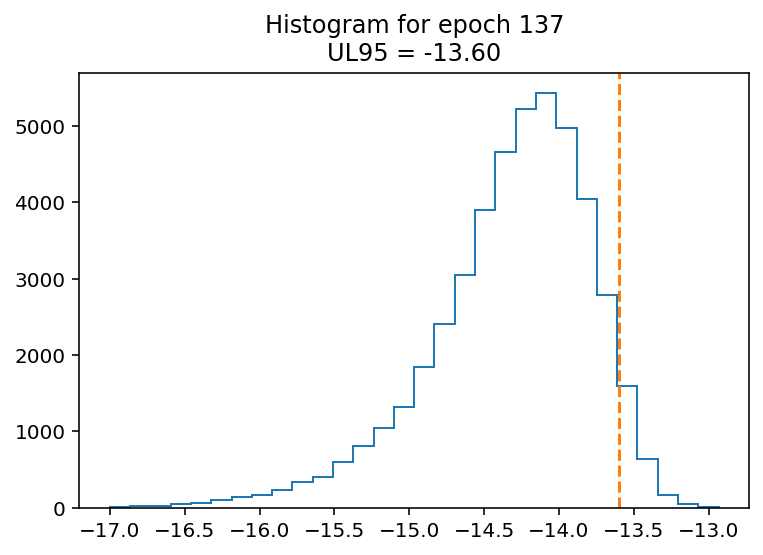

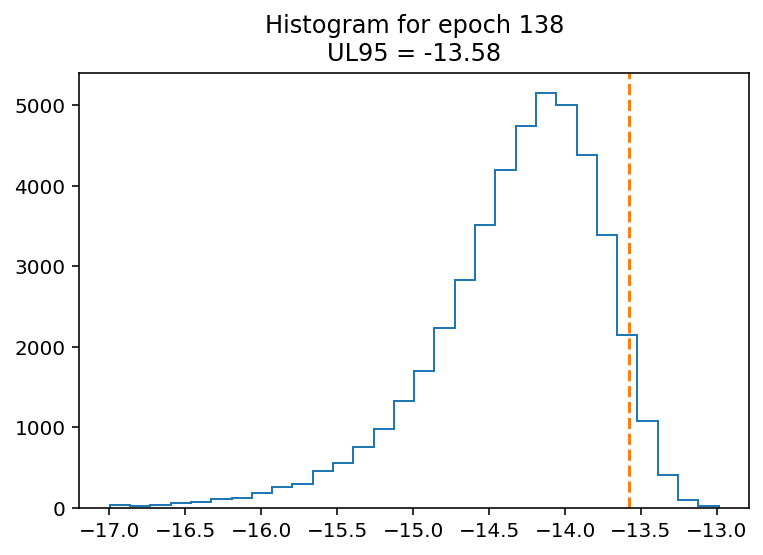

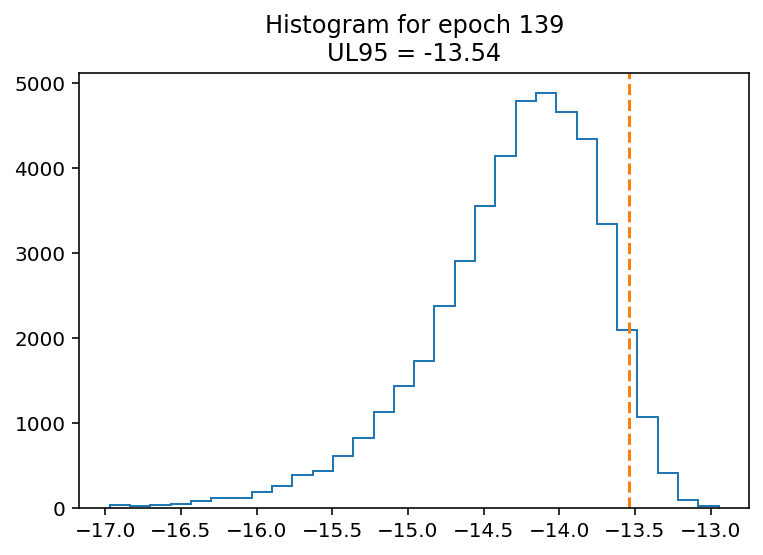

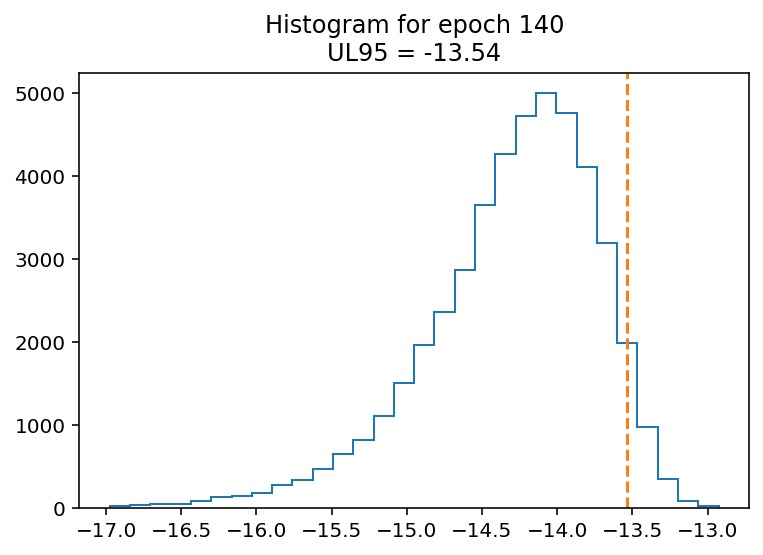

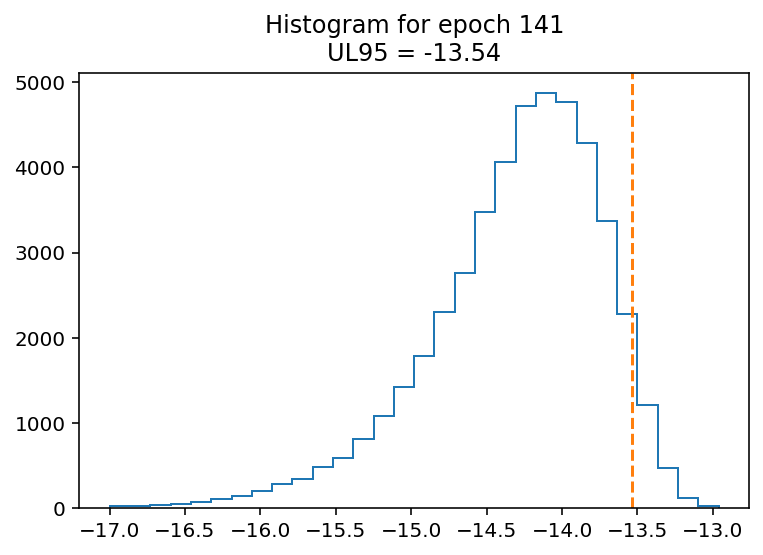

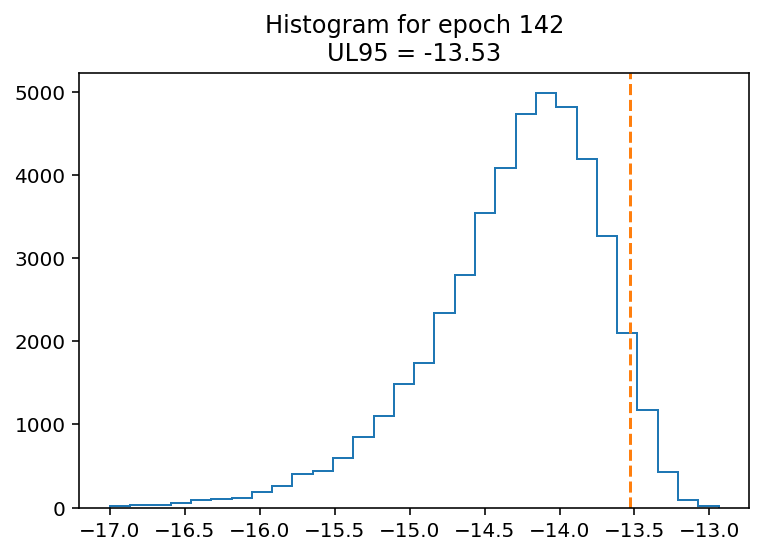

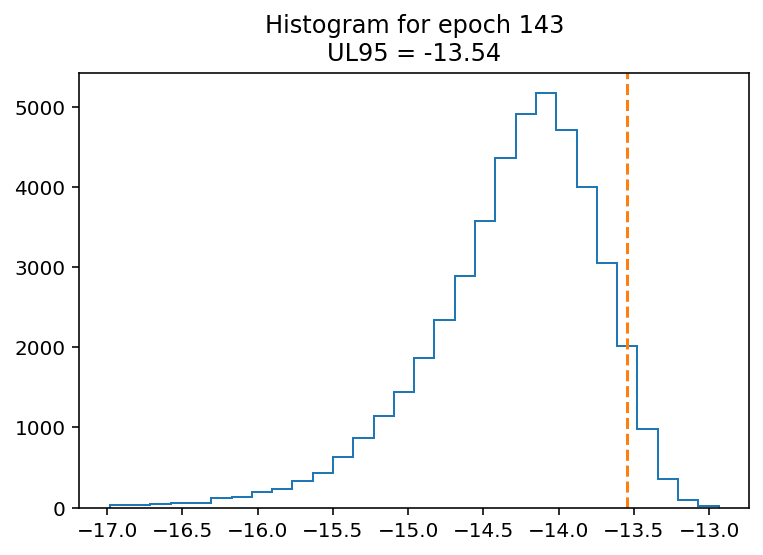

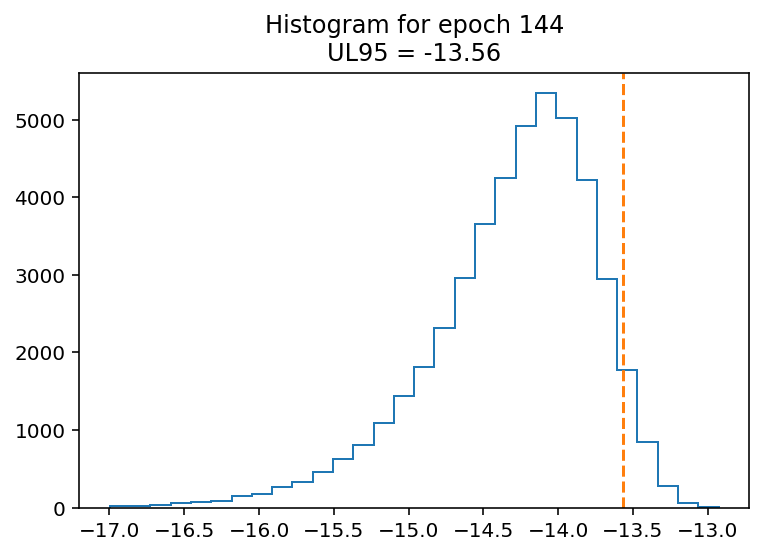

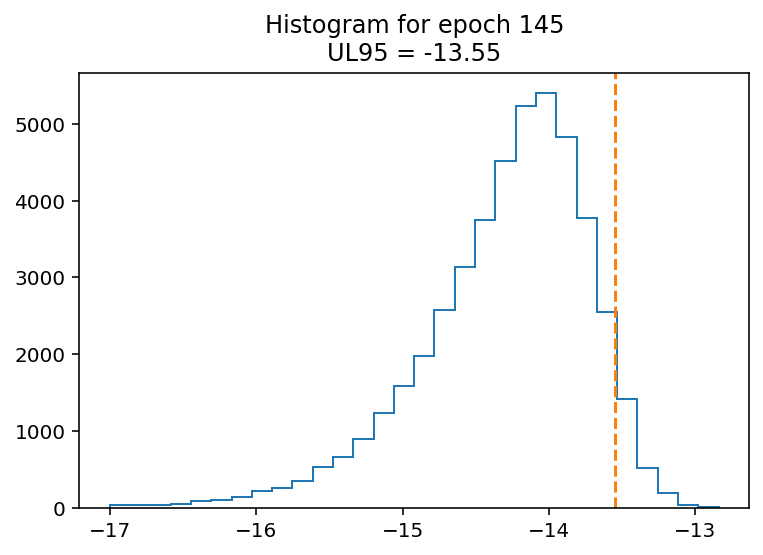

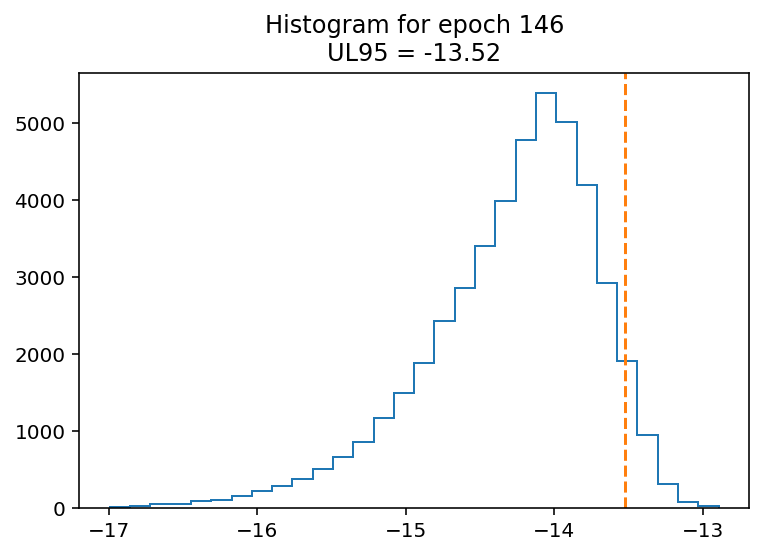

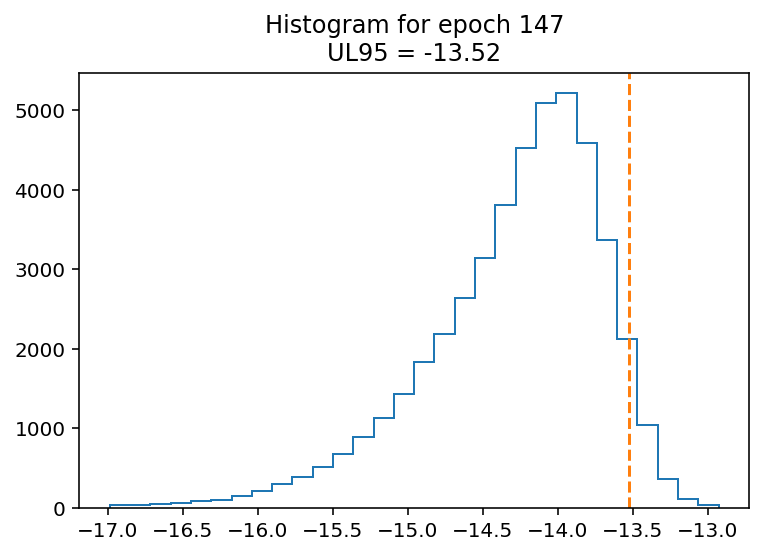

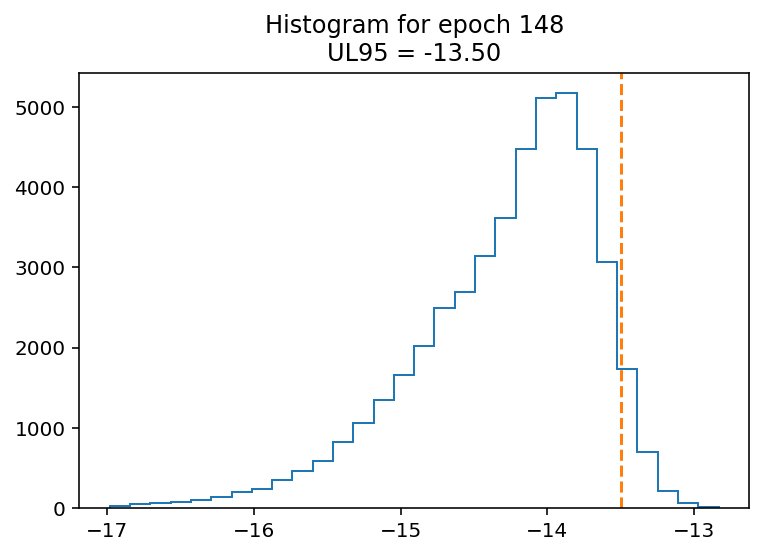

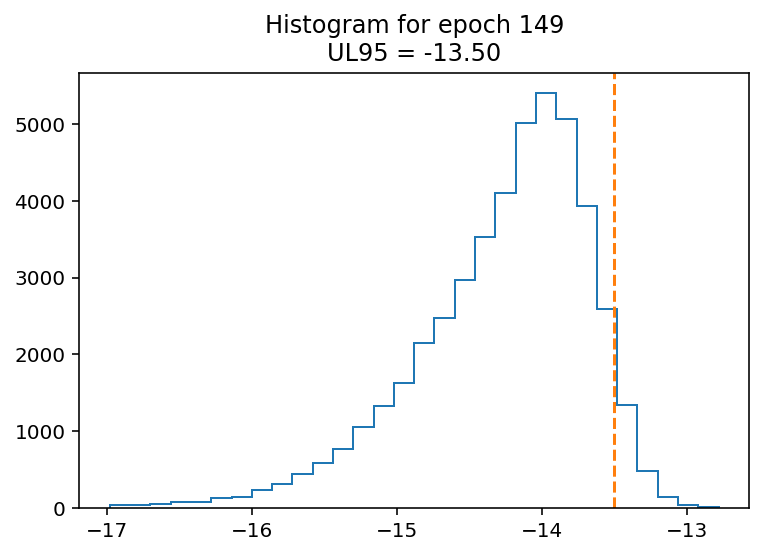

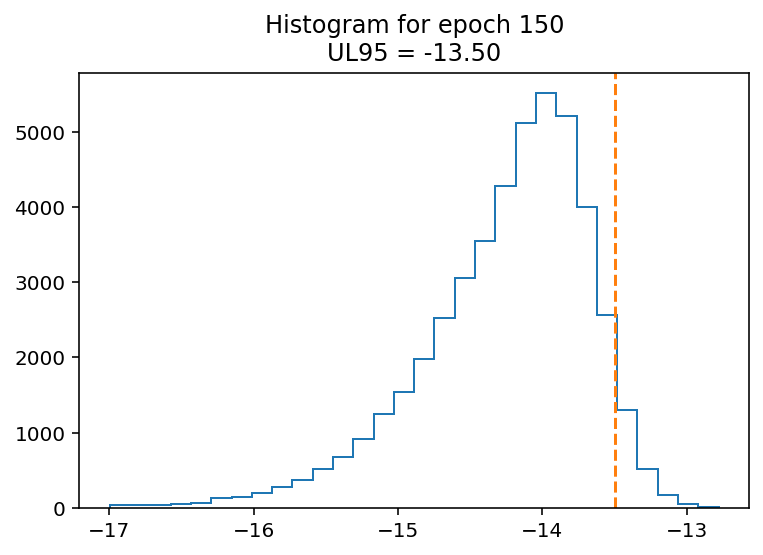

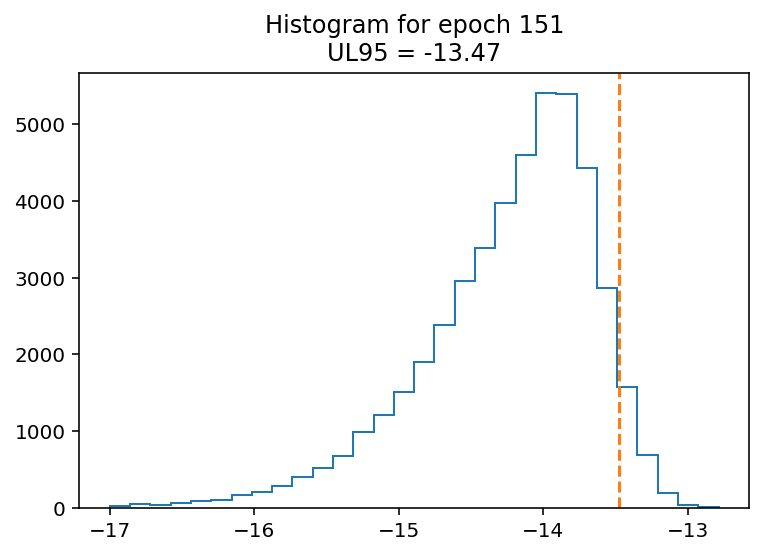

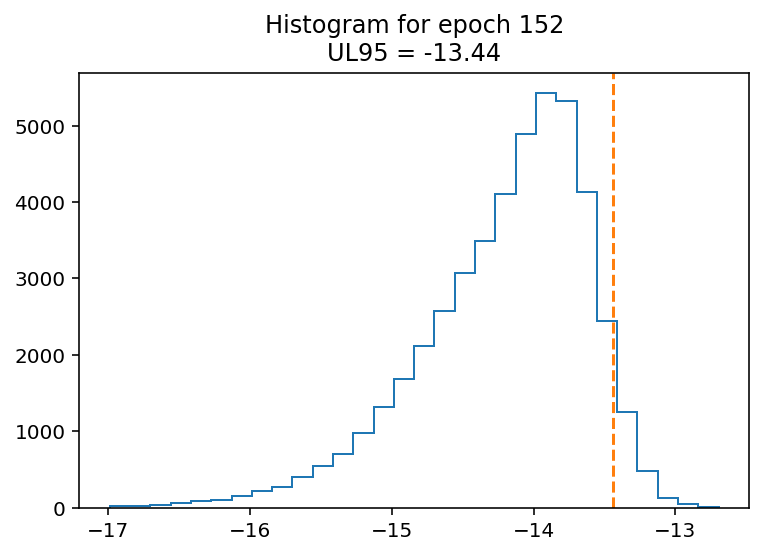

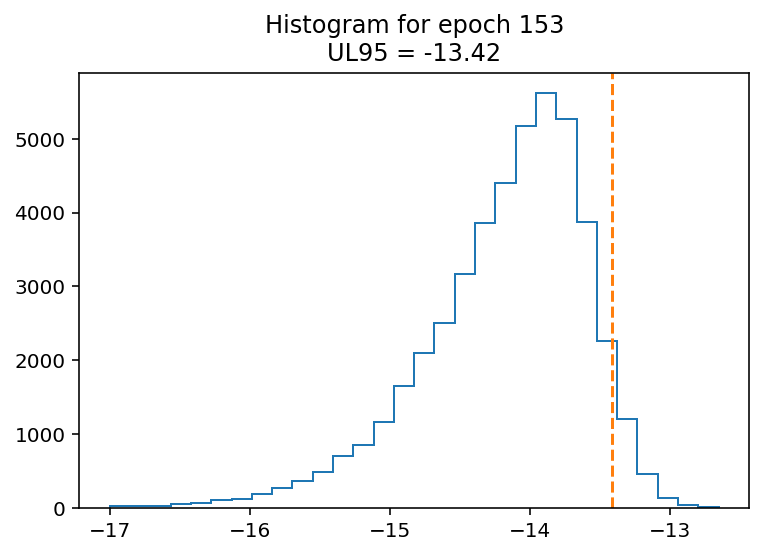

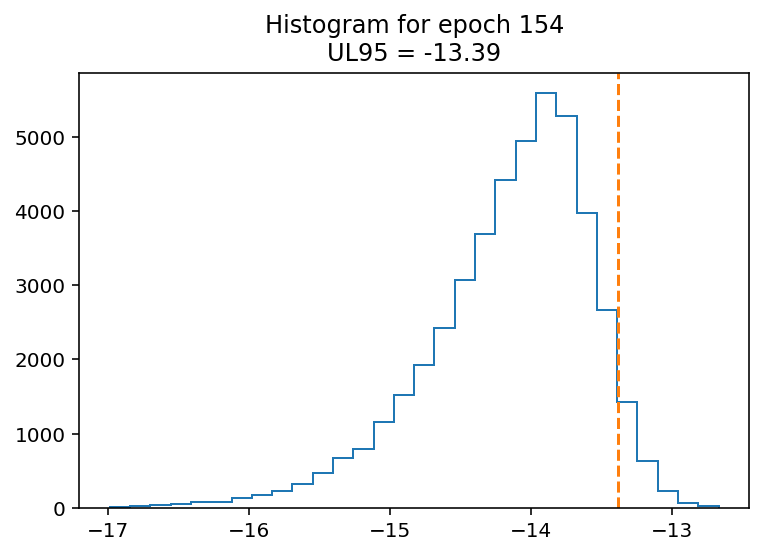

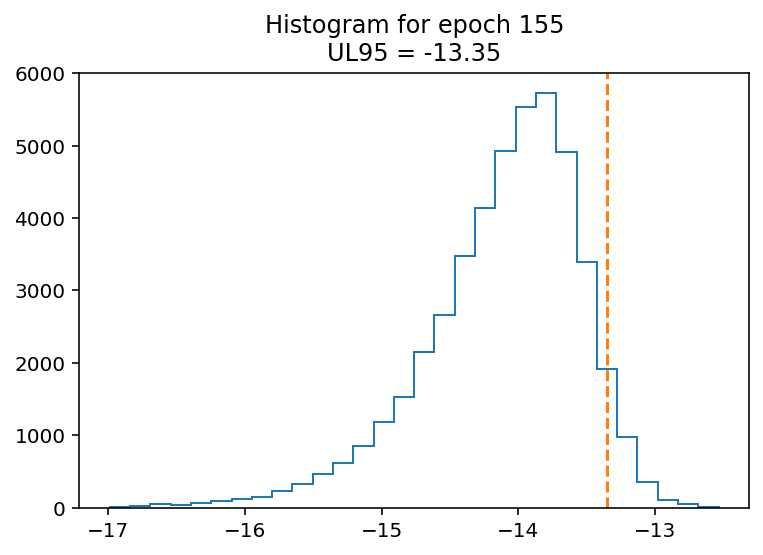

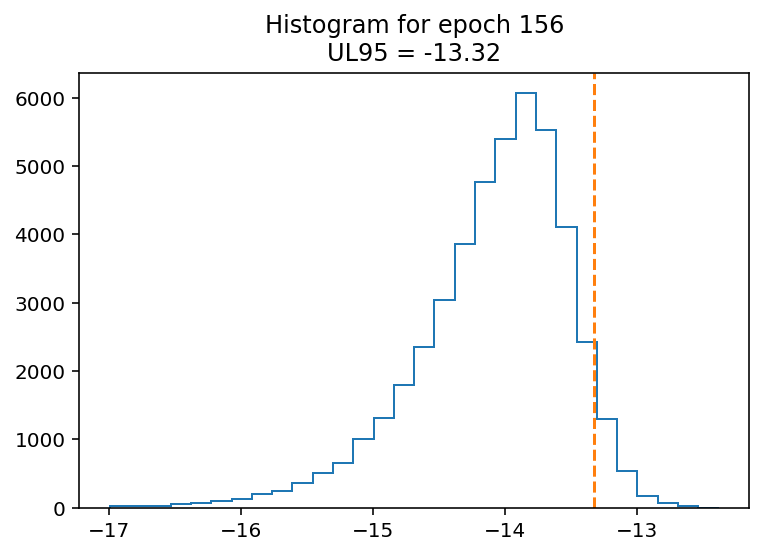

In [19]:
histdir = '/home/nima/nanograv/12p5yr_bwm/ULvT_samples_crnmarg/'
ULvT = np.zeros(len(nano12_Ts))
for epoch_idx, epoch in enumerate(nano12_Ts):
    hist = sorted(np.loadtxt(histdir + "{}.txt".format(epoch_idx)))
    plt.hist(hist,histtype='step', bins=30)

    ul95_idx = int(0.95*len(hist))
    
    ULvT[epoch_idx] = hist[ul95_idx]
    plt.axvline(x=hist[ul95_idx], color='tab:orange', linestyle='--',)
    plt.title("Histogram for epoch {}\nUL95 = {:.02f}".format(epoch_idx, hist[ul95_idx]))
    plt.show()
    

    

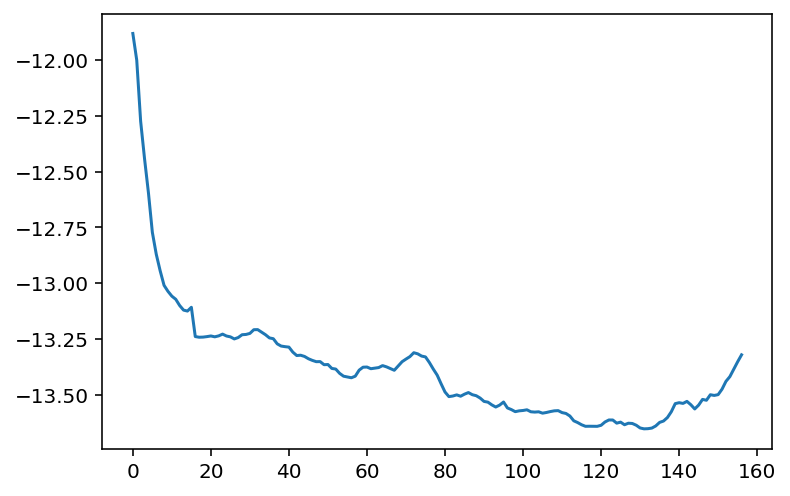

In [20]:
plt.plot(ULvT)

In [21]:
#Load pauls data and see what's up

In [22]:
# binned by source orientation reruns
with open('/home/nima/nanograv/11yr/postproc_nb/11yr_bwm_paper_data/ULs.json', 'r') as fin:
    ULmarg = json.load(fin)

key = 'DE430'
ULs_430 = [x[1] for x in ULmarg[key]]
low_430 = [x[1]-x[2] for x in ULmarg[key]]
high_430 = [x[1]+x[2] for x in ULmarg[key]]

key = 'DE436'
ULs_436 = [x[1] for x in ULmarg[key]]
low_436 = [x[1]-x[2] for x in ULmarg[key]]
high_436 = [x[1]+x[2] for x in ULmarg[key]]

key = 'DE436_BE'
ULs_BE = [x[1] for x in ULmarg[key]]
low_BE = [x[1]-x[2] for x in ULmarg[key]]
high_BE = [x[1]+x[2] for x in ULmarg[key]]

T11 = [x[0] for x in ULmarg[key]]
#T11 = Time(T11, format='mjd').decimalyear


# use BayesEphem for Rate ULs
key = 'DE436_BE'
UL_11 = np.array(ULmarg[key]).T

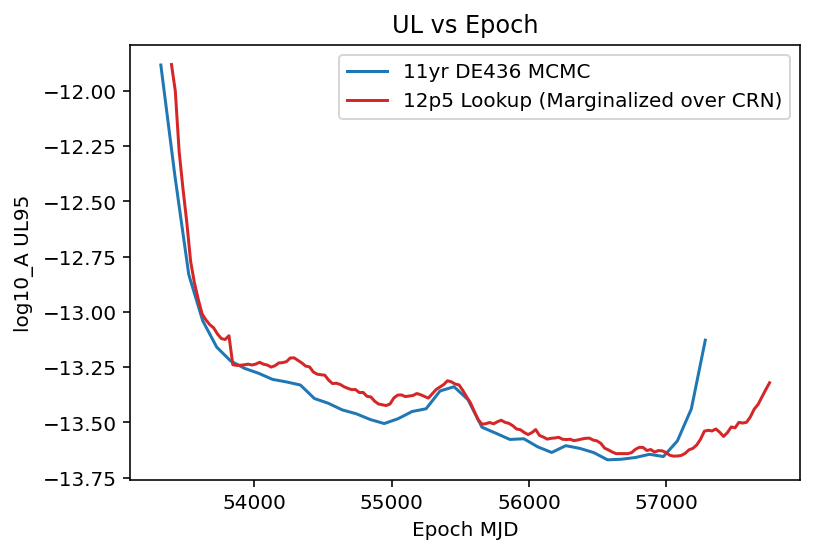

In [24]:
plt.plot(T11, np.log10(ULs_436), label='11yr DE436 MCMC', color = 'tab:blue')
#plt.plot(T11, np.log10(ULs_430), label='DE430 MCMC')
#plt.plot(T11, np.log10(ULs_BE), label='BayesEphem MCMC')
plt.plot(nano12_Ts, ULvT, label='12p5 Lookup (Marginalized over CRN)', color='tab:red')

plt.legend()
plt.title("UL vs Epoch")
plt.ylabel("log10_A UL95")
plt.xlabel('Epoch MJD')
plt.legend(loc='upper right')


In [ ]:
allpsrs[0]

In [ ]:
import scipy
pauls_interp = scipy.interpolate.interp1d(T11, ULs_436)
my_interp = scipy.interpolate.interp1d(nano11_Ts, ULvT)

In [ ]:
UL_pct_diffs = []
for epoch in nano11_Ts:
    diff = 100*(my_interp(epoch) - pauls_interp(epoch))/np.abs(pauls_interp(epoch))
    UL_pct_diffs.append(diff)

plt.plot(nano11_Ts, UL_pct_diffs)
plt.title('Upper Limit % Difference \n(DE436 MCMC - DE436 Lookup)')
plt.xlabel("Burst Epoch (MJD)")
plt.ylabel("% Diff")


In [ ]:
plt.hist(UL_pct_diffs, bins=20)

In [ ]:
plt.legend()

# Check out the chains where we just sort of ignore some epochs

In [ ]:
ignored_epochs_epochsamples = '/home/nima/nanograv/11yr_factlike/ULvT_charts_ignore_epoch/epoch_samples/'
files = os.listdir(ignored_epochs_epochsamples)
epochs = []
for f in files:
    epochs.append(nano11_Ts[int(f.replace('.txt',''))])

In [ ]:
ULs = np.zeros(len(epochs))
for fidx, f in enumerate(files):
    resampled = sorted(np.loadtxt(ignored_epochs_epochsamples + f))
    ULs[fidx] = resampled[int(0.95 * len(resampled))]

In [ ]:
plt.scatter(epochs, ULs)
plt.scatter(T11, np.log10(ULs_436), label='DE436 MCMC', color = 'tab:red')